In [49]:
%run ./DataGen2.ipynb

In [25]:
class Standard_Param():
    def __init__(self, NumberOfClusters = 40):
        # Region of interest :
        self.x_lim = [0, 4] # micrometer
        self.y_lim = [0, 4]

        # Clusters :
        self.NumberOfClusters = NumberOfClusters
        self.LocPerCluster    = [24] * self.NumberOfClusters
        self.r                = [30] * self.NumberOfClusters # nm
        self.cluster_shape    = 'uniform'

        # Noise :
        self.NoisePercentage  = 0.5 # between 0 adnd 0.8
        self.UniformNoise     = True 
        
        # SMLM points : 
        self.mean_uncertainty      = 20
        self.dev_uncertainty       = 3
        self.N_photons             = 15000
        
        # Scales : 
        self.NumberOfScales   = 1
        
        # Random Seed 
        self.RandomSeed  = False

In [26]:
def Call_DataGenerator(p):
    datagen = DataGenerator(x_lim = p.x_lim,
                        y_lim = p.y_lim,
                        NumberOfClusters = p.NumberOfClusters,
                        LocPerCluster = p.LocPerCluster,
                        r = p.r,
                        NoisePercentage = p.NoisePercentage,
                        NumberOfScales = p.NumberOfScales,
                        cluster_shape = p.cluster_shape,
                        UniformNoise = p.UniformNoise, 
                        mean_delta = p.mean_uncertainty, 
                        dev_delta = p.dev_uncertainty,
                        N_photons = p.N_photons,
                        RandomSeed = p.RandomSeed)
    return datagen

def compute_T(N, sigma_s = 40.0, x_lim = [0,4], y_lim = [0,4]):
    csr = CsrGenerator(N=N, x_lim = x_lim, y_lim = y_lim)
    data = csr.GetAllData()
    P = data[['x', 'y']].to_numpy() # select the coordinates columns, and transform into a numpy object
    truelabels = data['labels_1'].to_numpy()
    
    Sigma1          = np.ones((P.shape[0], 2, 2)) * 0
    Sigma1[:, 0, 1] = 0
    Sigma1[:, 1, 0] = 0
    n1              = np.ones((P.shape[0], 1)).ravel()
    
    density_csr, G0 = compute_density(P, Sigma1, sigma_s)
    
    # Computing the standard T 
    av = np.mean(density_csr)
    sd = np.std(density_csr)
    T = av + 2 * sd
    if (T>= 1):
        print('T = ', T, ' is bigger than 1. There is a problem. ')
        return 0.99
    see_histogram(density_csr, T, 'vertical method')
    
    # Computing the horizontal T
    histo = plt.hist(density_csr, bins = 50)
    min_ = min(histo[0])
    max_ = max(histo[0])
    v = min_ + (max_ - min_)/10

    T_h = 1 # default value in case it is not found
    for i, x in enumerate(histo[1]):
        if i>0:
            if (histo[0][i-1] <= v):
                T_h = histo[1][i]
                break
    see_histogram(density_csr, T_h, 'horizontal method')
    
    return T, T_h

def compute_T_90_95(N, sigma_s = 40.0, x_lim = [0,4], y_lim = [0,4]):
    csr = CsrGenerator(N=N, x_lim = x_lim, y_lim = y_lim)
    data = csr.GetAllData()
    P = data[['x', 'y']].to_numpy() # select the coordinates columns, and transform into a numpy object
    truelabels = data['labels_1'].to_numpy()
    
    Sigma1          = np.ones((P.shape[0], 2, 2)) * 0
    Sigma1[:, 0, 1] = 0
    Sigma1[:, 1, 0] = 0
    n1              = np.ones((P.shape[0], 1)).ravel()
    
    density_csr, G0 = compute_density(P, Sigma1, sigma_s)
    
    # Computing T for 90% and for 95% 
    T90 = np.quantile(density_csr, 0.90)
    T95 = np.quantile(density_csr, 0.95)
    
        
    see_histogram(density_csr, T90, '90')
    see_histogram(density_csr, T95, '95')
    
    return T90, T95

def compute_T_95(N, sigma_s = 40.0, x_lim = [0,4], y_lim = [0,4]):
    csr = CsrGenerator(N=N, x_lim = x_lim, y_lim = y_lim)
    data = csr.GetAllData()
    P = data[['x', 'y']].to_numpy() # select the coordinates columns, and transform into a numpy object
    truelabels = data['labels_1'].to_numpy()
    
    Sigma1          = np.ones((P.shape[0], 2, 2)) * 0
    Sigma1[:, 0, 1] = 0
    Sigma1[:, 1, 0] = 0
    n1              = np.ones((P.shape[0], 1)).ravel()
    
    density_csr, G0 = compute_density(P, Sigma1, sigma_s)
    
    # Computing T 
    T = np.quantile(density_csr, 0.95)
        
    see_histogram(density_csr, T, '0.95 quantile')
    
    return T

<Figure size 720x576 with 0 Axes>

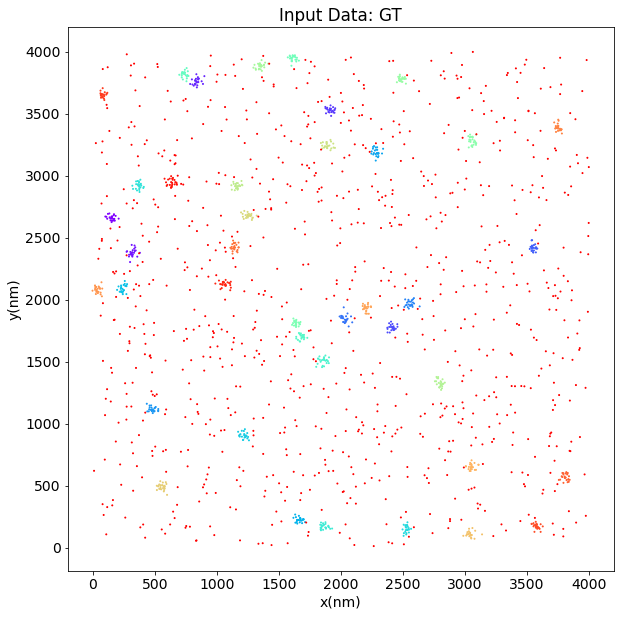

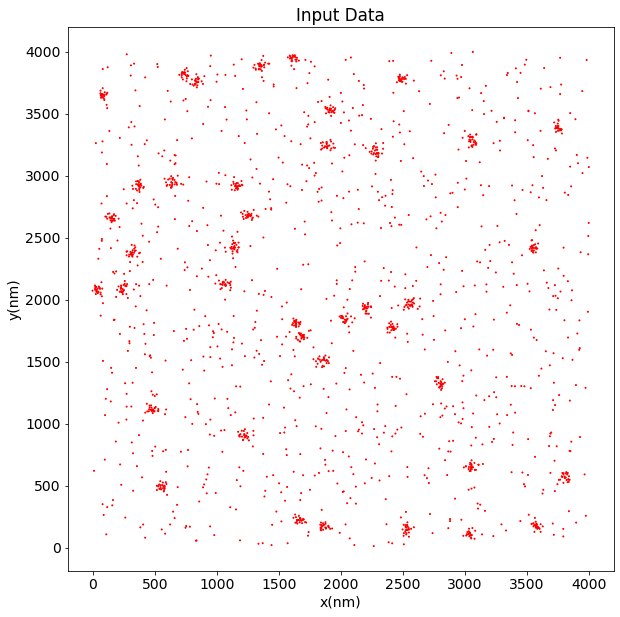

In [27]:
plt.rcParams.update({'font.size': 18})
p = Standard_Param()
p.RandomSeed = True
datagen = Call_DataGenerator(p)
plt.figure(figsize=(10,8))
datagen.plot_points()

<Figure size 720x576 with 0 Axes>

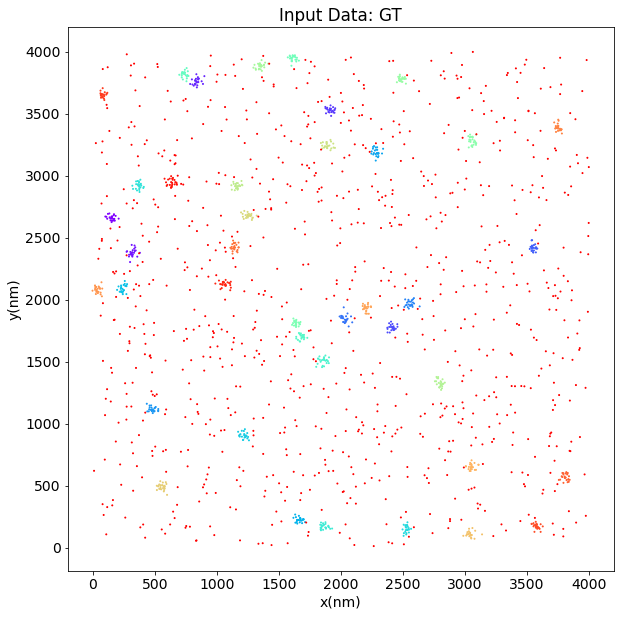

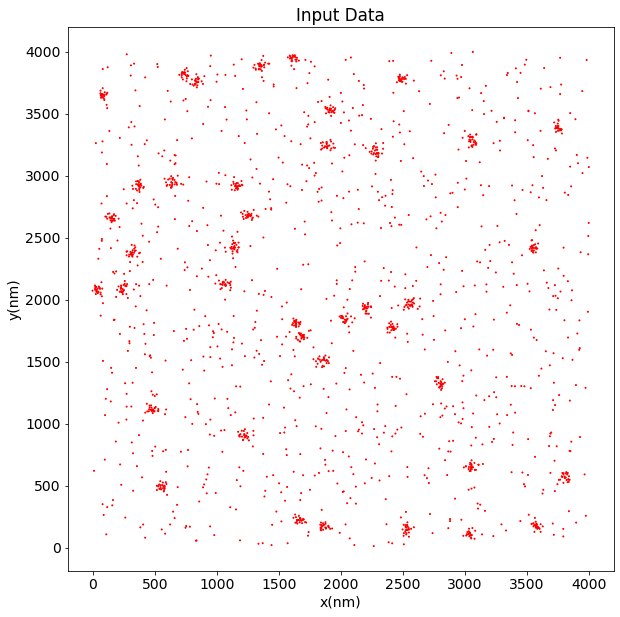

In [28]:
plt.rcParams.update({'font.size': 18})
p = Standard_Param()
p.RandomSeed = True
datagen = Call_DataGenerator(p)
plt.figure(figsize=(10,8))
datagen.plot_points()

In [29]:
saving_path = '/Users/Eliana/Documents/PDM/Codes/My_codes/automatic_T/'

(Text(0.5, 0, 'x [nm]'), Text(0, 0.5, 'y [nm]'))

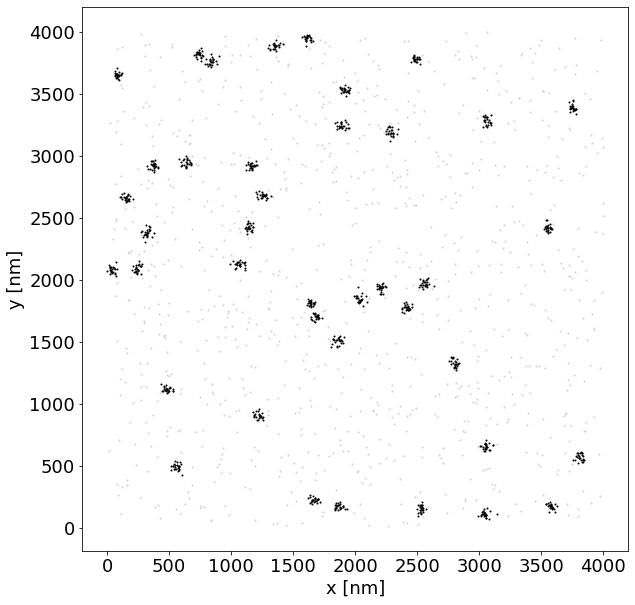

In [99]:
plt.rcParams.update({'font.size': 18})

filename   = 'standard_GT'
P              = np.asarray(datagen.GetPointsCoord())
labels         = np.asarray(datagen.GetPointsLabels())


not_noise_idx = np.where(labels != 0)
noise_idx = np.where(labels == 0)

plt.figure(figsize = (10,10))
plt.scatter(P[noise_idx,0], P[noise_idx,1], c = 'lightgray', s = 1)
#plt.scatter(P[not_noise_idx, 0], P[not_noise_idx, 1], c = labels[not_noise_idx], cmap = 'rainbow_r', s = 1)
plt.scatter(P[not_noise_idx, 0], P[not_noise_idx, 1], c = 'black', s = 1)
plt.gca().set_aspect('equal')
plt.xlabel('x [nm]'), plt.ylabel('y [nm]')

#plt.savefig(saving_path + filename + '.pdf')


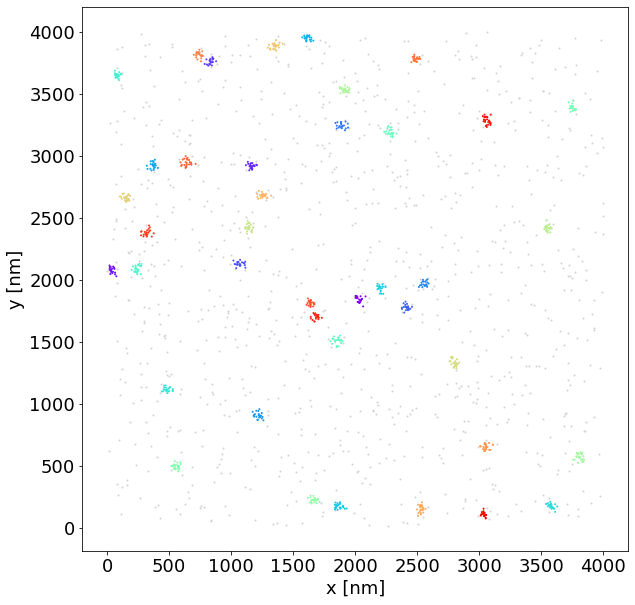

In [94]:
plt.rcParams.update({'font.size': 18})

filename   = 'graphic_result'
P              = datagen.GetPointsCoord()

plt.figure(figsize = (10,10))

not_noise_idx = np.where(labels_clean != 0)
noise_idx = np.where(labels_clean == 0)


plt.scatter(P[noise_idx,0], P[noise_idx,1], c = 'lightgray', s = 1)
plt.scatter(P[not_noise_idx, 0], P[not_noise_idx, 1], c = labels_clean[not_noise_idx], cmap = 'rainbow_r', s = 1)
plt.gca().set_aspect('equal')
plt.xlabel('x [nm]'), plt.ylabel('y [nm]')

plt.savefig(saving_path + filename + '.pdf')

(Text(0.5, 0, 'x[nm]'), Text(0, 0.5, 'y[nm]'))

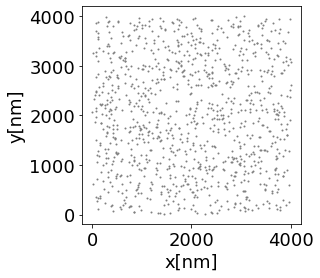

In [82]:
noise_i = np.where(labels_clean == 0)


plt.scatter(P[noise_i,0], P[noise_i,1], c = 'gray', s = 1)

plt.gca().set_aspect('equal')
plt.xlabel('x[nm]'), plt.ylabel('y[nm]')



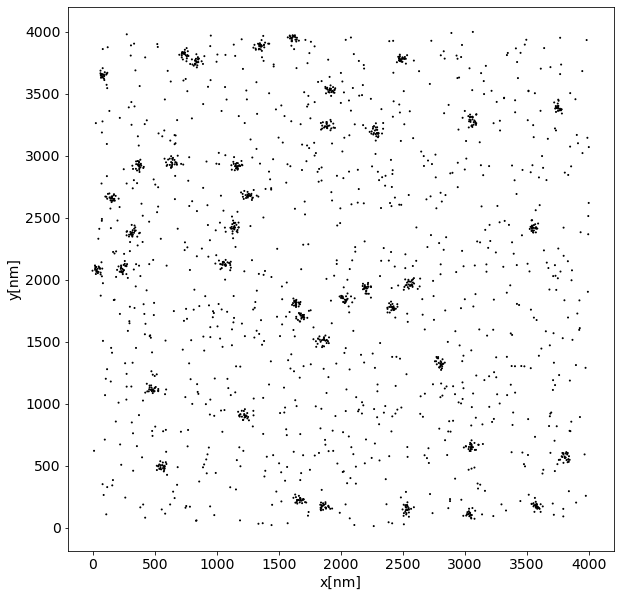

In [31]:
plt.rcParams.update({'font.size': 18})

filename   = 'standard'
P              = datagen.GetPointsCoord()
labels         = datagen.GetPointsLabels()

plt.figure(figsize = (10,10))

new_labels = ['black' for lab in labels]

plt.scatter(P[:,0], P[:,1], c = new_labels, s = 1)
plt.gca().set_aspect('equal')
plt.xlabel('x[nm]'), plt.ylabel('y[nm]')

plt.savefig(saving_path + filename + '.pdf')

In [32]:
N = len(datagen.GetPoints())
csr = CsrGenerator(N = N, x_lim = [0,4], y_lim = [0,4])
Sigma = datagen.GetPointsCovMatrix()

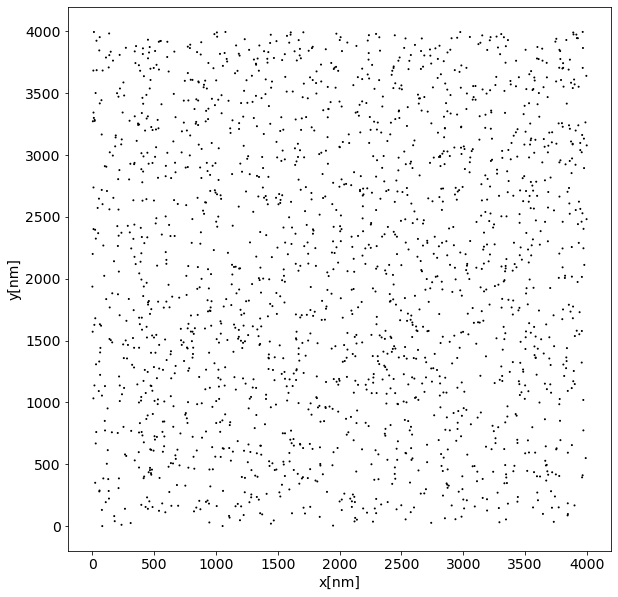

In [34]:
filename      = 'csr'
Pcsr          = csr.GetPointsCoord()

plt.figure(figsize = (10,10))

new_labels = ['black' for i in Pcsr]

plt.scatter(Pcsr[:,0], Pcsr[:,1], c = new_labels, s = 1)
plt.gca().set_aspect('equal')
plt.xlabel('x[nm]'), plt.ylabel('y[nm]')

plt.savefig(saving_path + filename + '.pdf')

In [35]:
sigma_s = 32

In [124]:
%run ./DataGen2.ipynb

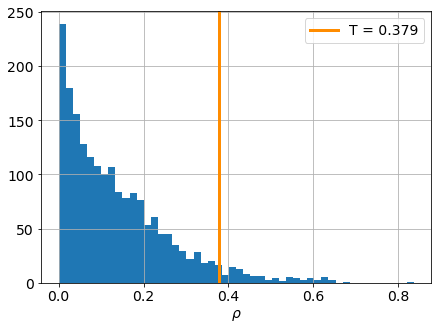

In [55]:
T = compute_T_95(N, Sigma,  sigma_s = sigma_s, x_lim = [0,4], y_lim = [0,4])

In [51]:
plt.savefig(saving_path + 'T_csr'+ '.pdf')

<Figure size 432x288 with 0 Axes>

In [64]:
df = datagen.GetAllData()
P = df[['x', 'y']].to_numpy()
Sigma = np.asarray(datagen.GetPointsCovMatrix())
density, G = compute_density(P, Sigma, sigma_s)

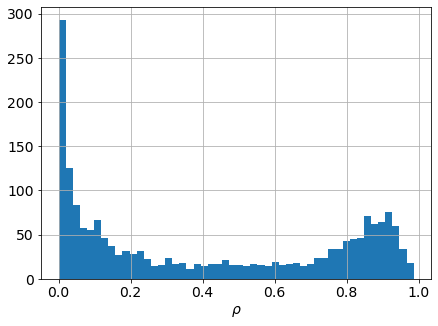

In [65]:
plt.figure(figsize = (7,5))
plt.hist(density, bins = 50)
plt.xlabel(r'$\rho$')
plt.grid()
plt.savefig(saving_path + 'histo'+ '.pdf')

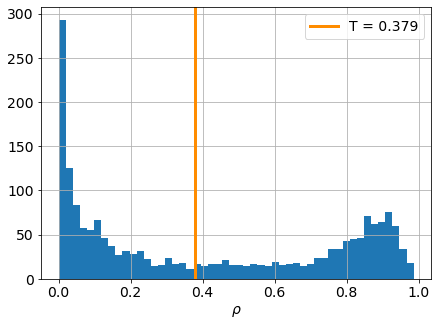

In [66]:
see_histogram(density, T, '')

La prochaine cellule est une démonstration pour le standard, cette fois ci avec les incertitudes prises en compte. 

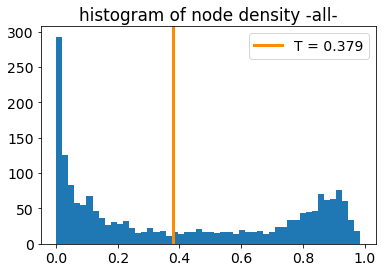

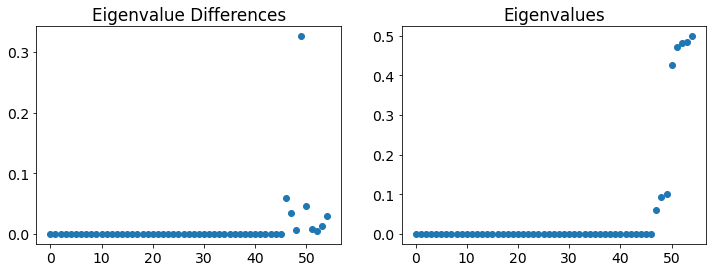

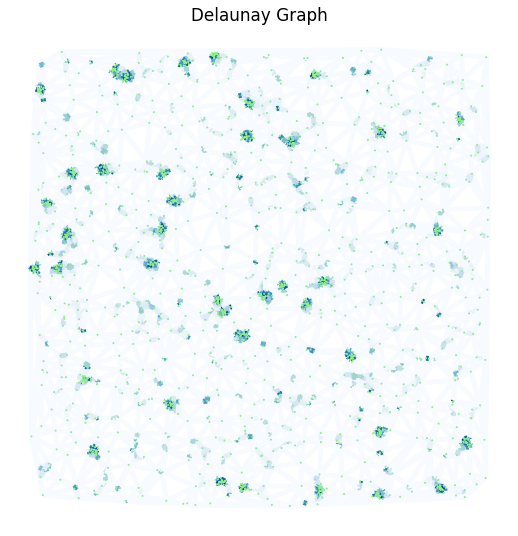

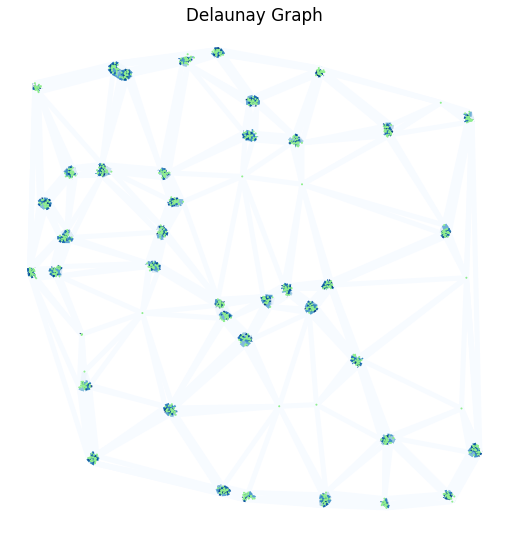

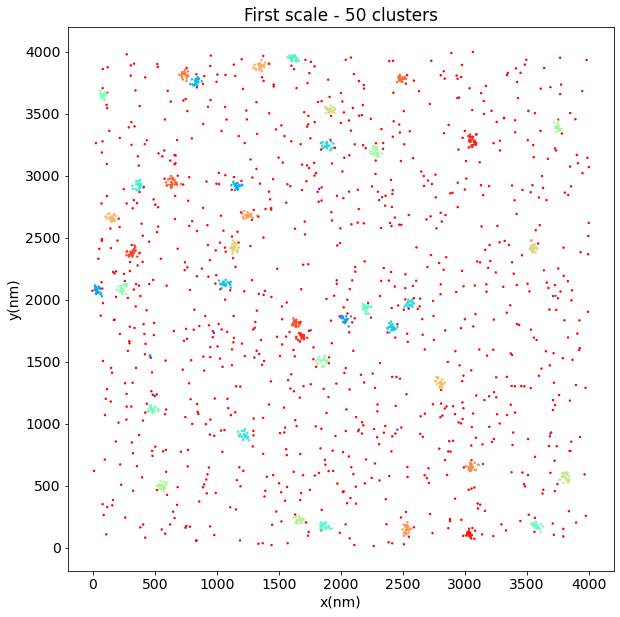

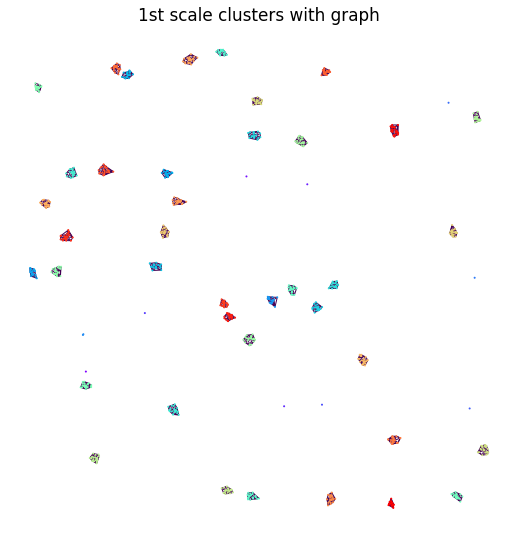

In [67]:
# thershold vertical 
labels = calling_graphic(df, sigma_s, T)

#threshold horizontal 
#calling_graphic(df, sigma_s, hT)

In [68]:
labels_clean = remove_small_clusters(labels, 5)

In [69]:
#GT = datagen.GetAllData()
truelabels = np.asarray(datagen.GetPointsLabels())
#truelabels = GT['labels_1'].to_numpy()

In [115]:
FMI  = metrics.fowlkes_mallows_score(truelabels, labels_clean)

In [116]:
FMI

0.9530323275460869

In [117]:
NumberOfClusters_graphic = len(np.unique(labels_clean))-1
print(NumberOfClusters_graphic)

40


# T en fonction du nombre de N, pour plusieurs sigmas. 

0.8725188370772616


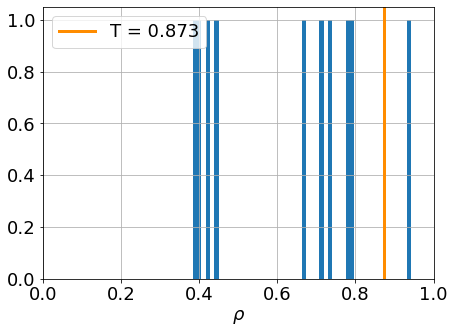

In [117]:
N = 10
sigma_s = 32
uncertainties = np.random.normal(20, 3, N)
cov_matrices = [ np.array([[u**2, 0], [0, u**2]]) for u in uncertainties]

T = compute_T_95(N, cov_matrices, sigma_s = sigma_s, x_lim = [0,0.1], y_lim = [0, 0.1])
print(T)

In [147]:
Ns = np.arange(600, 3001, 400)

sigma_ss = [20, 70, 120, 170]

n_sim = 1

In [148]:
all_T_sd = []
all_T_av = []

for sigma_s in sigma_ss:
    print(sigma_s)
    T_N_sd = []
    T_N_av = []
    for N in Ns:
        uncertainties = np.random.normal(20, 3, N)
        cov_matrices = [ np.array([[u**2, 0], [0, u**2]]) for u in uncertainties]
        print('N = ', N)
        Ts = []
        for i in range(nsim):
            T = compute_T_95(N, cov_matrices, sigma_s, x_lim = [0,4], y_lim = [0,4])
            Ts.append(T)
        Ts    = np.asarray(Ts)
        T_std = np.std(Ts)/ np.sqrt(nsim) * 1.96
        T_avg = np.mean(Ts)

        T_N_sd.append(T_std)
        T_N_av.append(T_avg)
    all_T_sd.append(T_N_sd)
    all_T_av.append(T_N_av)
    

20
N =  600
N =  1000
N =  1400
N =  1800
N =  2200
N =  2600
N =  3000
70
N =  600
N =  1000
N =  1400
N =  1800
N =  2200
N =  2600
N =  3000
120
N =  600
N =  1000
N =  1400
N =  1800
N =  2200
N =  2600
N =  3000
170
N =  600
N =  1000
N =  1400
N =  1800
N =  2200
N =  2600
N =  3000


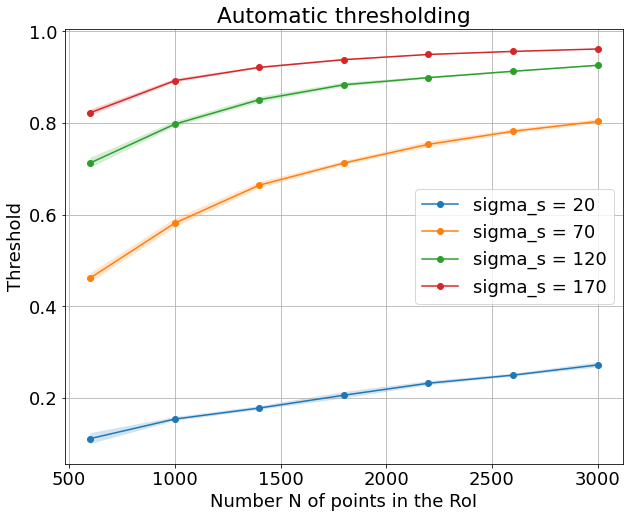

In [149]:
filename = 'automatic_thersholding'

x = Ns
plt.figure(figsize = (10,8))

linestyle = 'o-'
labels = ['sigma_s = ' + str(s) for s in sigma_ss]
for i, av in enumerate(all_T_av):
    av = np.asarray(av)
    sd = np.asarray(all_T_sd[i]) 
    plt.plot(x,av, linestyle, label = labels[i])
    plt.fill_between(x, (av - sd), (av + sd), alpha=.2)

plt.title('Automatic thresholding')
plt.xlabel('Number N of points in the RoI')
plt.ylabel('Threshold')
plt.legend()
plt.grid()
plt.savefig(saving_path + filename + '.pdf')

0


# Cas de low density et high noise.. 

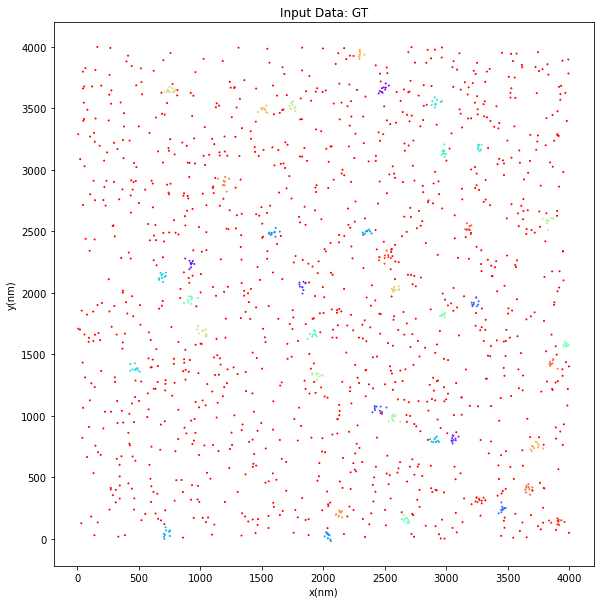

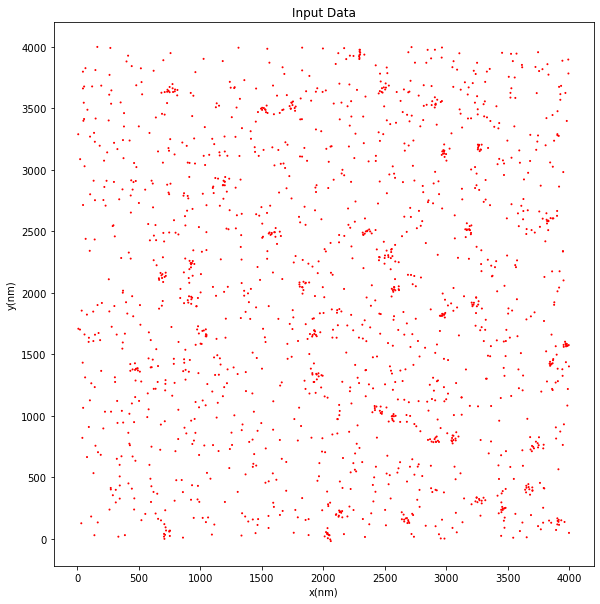

In [15]:
p_low = Standard_Param()
p_low.LocPerCluster = [10] * p_low.NumberOfClusters
p_low.NoisePercentage = 0.75
DataGen = Call_DataGenerator(p_low)
DataGen.plot_points()

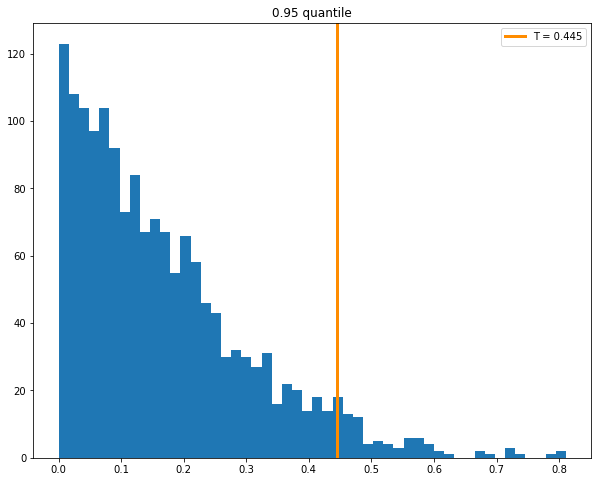

In [16]:
N = len(DataGen.GetPoints())
T = compute_T_95(N)

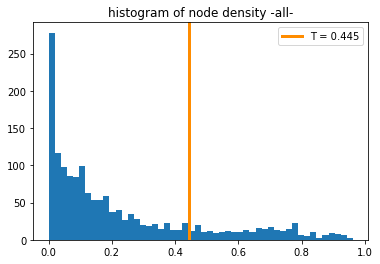

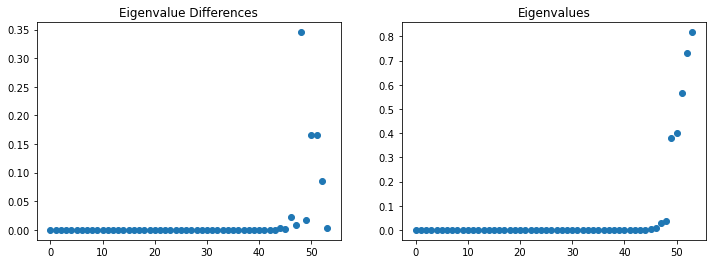

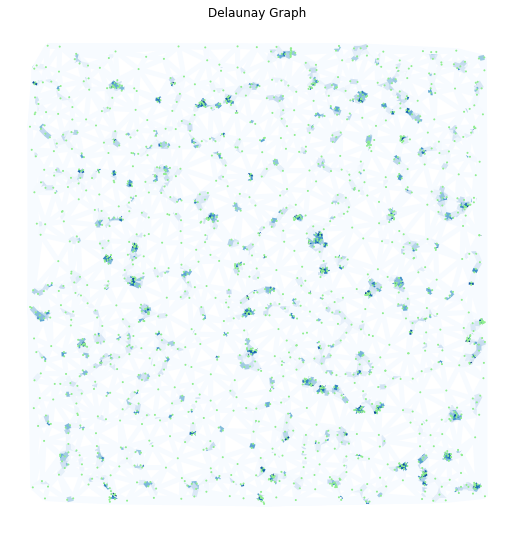

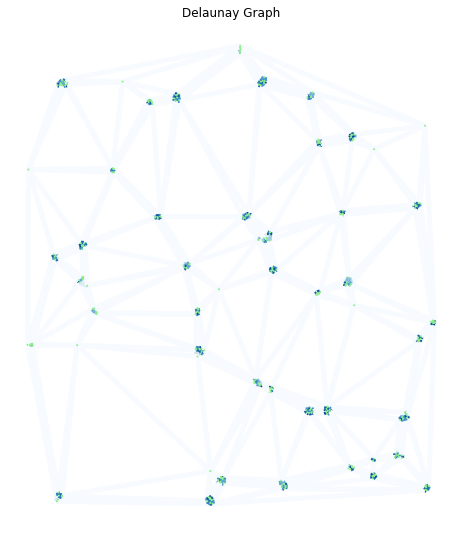

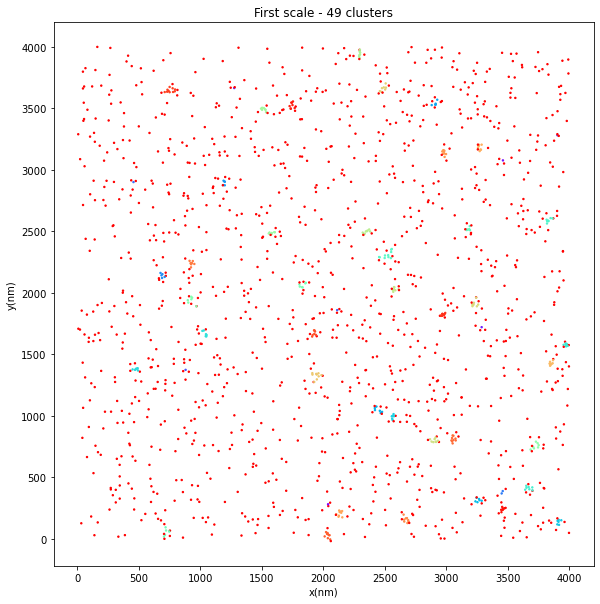

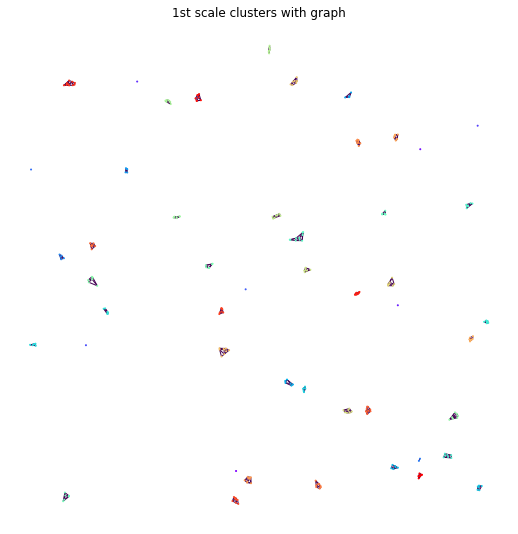

In [17]:
data = DataGen.GetAllData()
l = calling_graphic(data, sigma_s = 35., noise_thresh = T)

In [12]:
help(calling_graphic)

Help on function calling_graphic in module __main__:

calling_graphic(data, sigma_s=30.0, noise_thresh=0.5)



10
N =  150
N =  200
N =  250
N =  300
N =  350
N =  400
N =  450
N =  500
N =  550
N =  600
N =  650
N =  700
N =  750
55
N =  150
N =  200
N =  250
N =  300
N =  350
N =  400
N =  450
N =  500
N =  550
N =  600
N =  650
N =  700
N =  750
100
N =  150
N =  200
N =  250
N =  300
N =  350
N =  400
N =  450
N =  500
N =  550
N =  600
N =  650
N =  700
N =  750


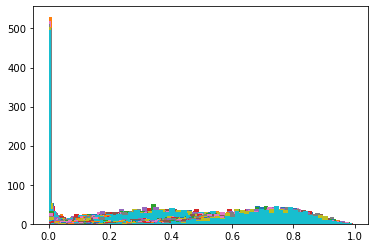

In [60]:
Sigma_s_s = [10, 55, 100]
Ns = np.arange(150, 751, 50).tolist()
#Ns = np.arange(1000, 2000, 200).tolist()

all_T_sd = []
all_T_av = []

for sigma_s in Sigma_s_s:
    print(sigma_s)
    T_N_sd = []
    T_N_av = []
    for N in Ns:
        print('N = ', N)
        Ts = []
        for i in range(10):
            T, hT = compute_T(N, sigma_s, x_lim = [0,2], y_lim = [0,2])
            Ts.append(hT) # CHANGE THIS LINE TO CHOOSE T OR hT. 
        Ts    = np.asarray(Ts)
        T_std = np.std(Ts)
        T_avg = np.mean(Ts)

        T_N_sd.append(T_std)
        T_N_av.append(T_avg)
    all_T_sd.append(T_N_sd)
    all_T_av.append(T_N_av)
    

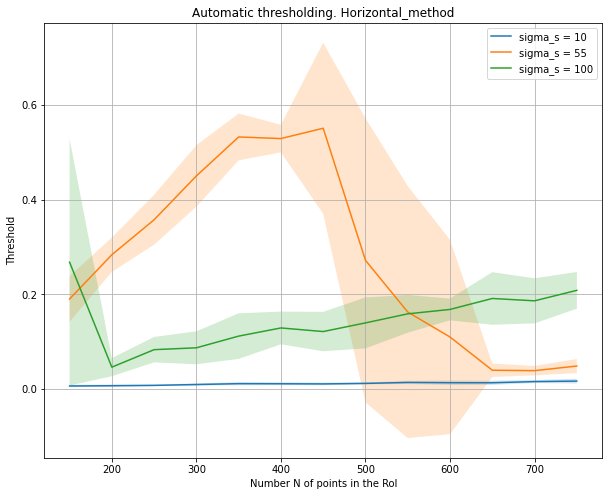

In [62]:

labels = ['sigma_s = ' + str(s) for s in Sigma_s_s]

x = Ns
plt.figure(figsize = (10,8))
for i, av in enumerate(all_T_av):
    av = np.asarray(av)
    sd = np.asarray(all_T_sd[i])
    plt.plot(x,av, label = labels[i])
    plt.fill_between(x, (av - sd), (av + sd), alpha=.2)

plt.title('Automatic thresholding. Horizontal_method')
plt.xlabel('Number N of points in the RoI')
plt.ylabel('Threshold')
plt.legend()
plt.grid()
plt.show()

10
N =  300


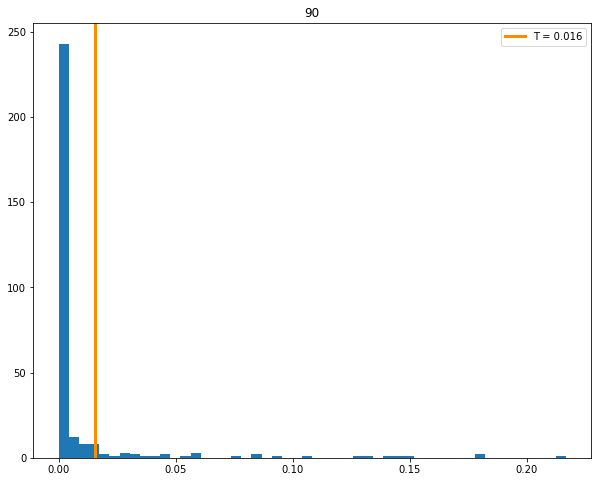

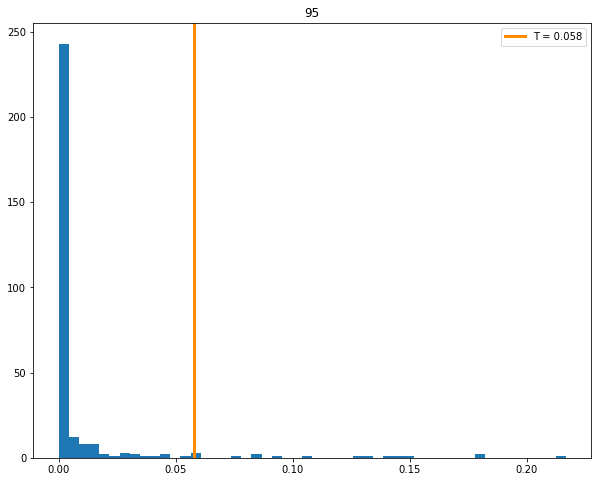

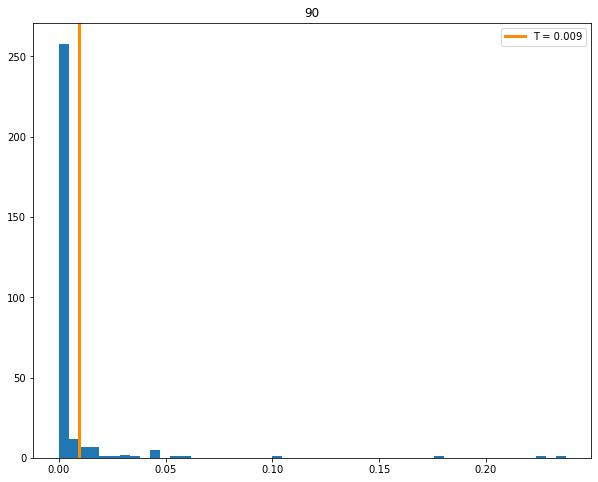

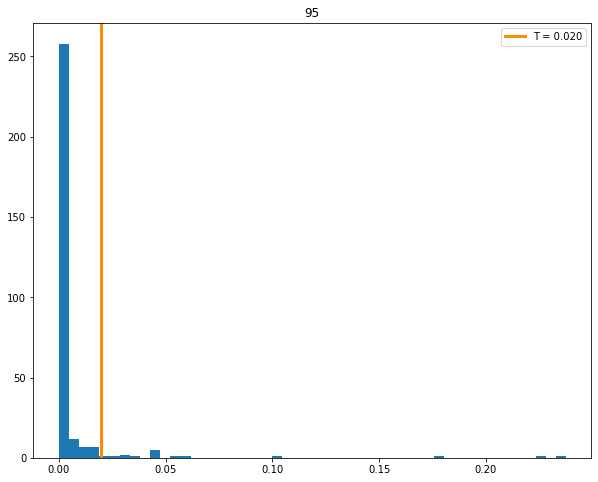

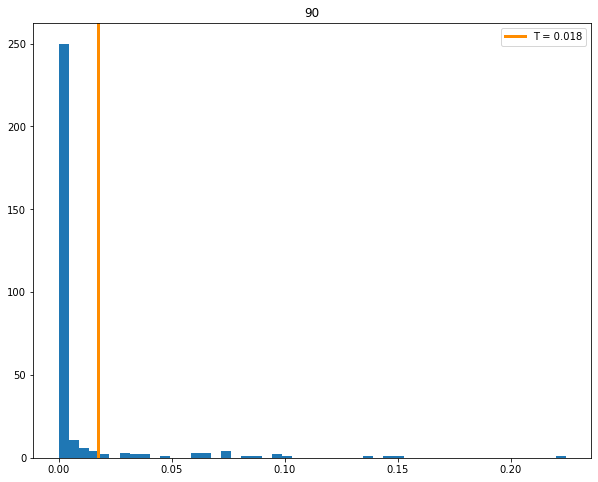

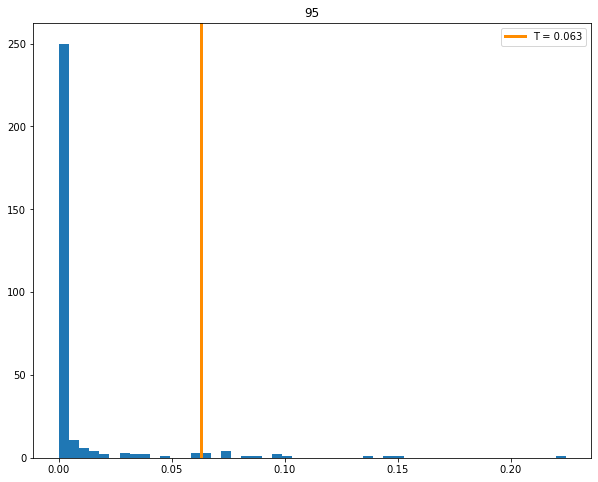

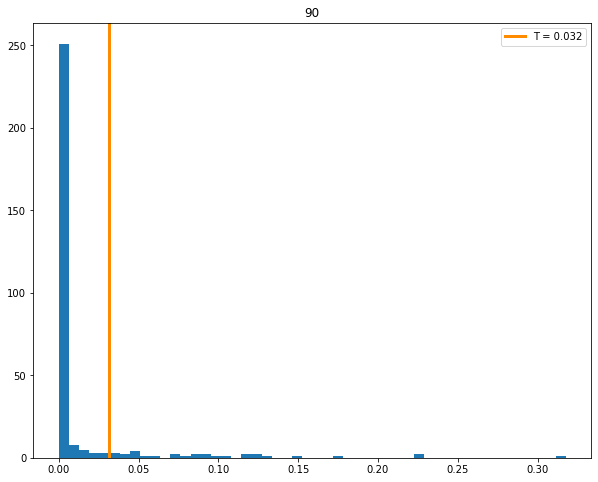

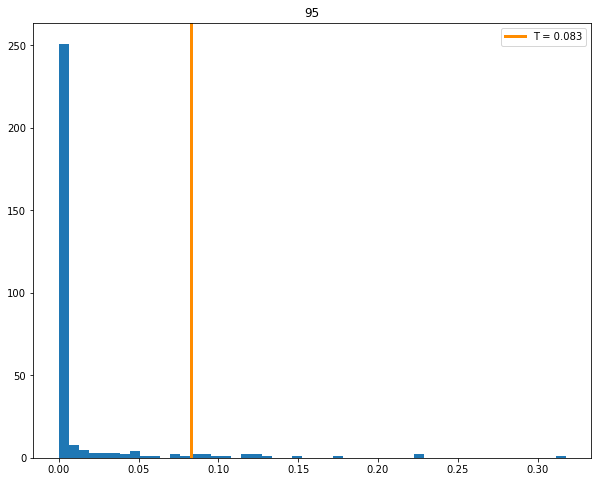

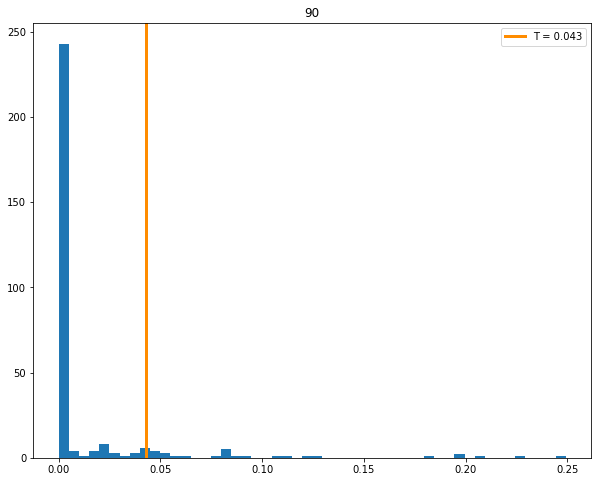

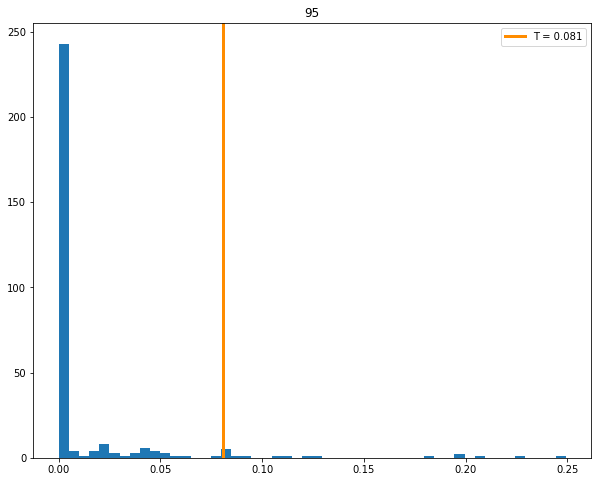

N =  350


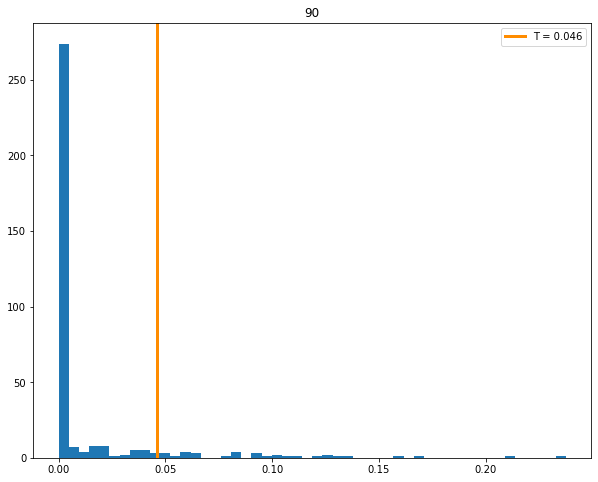

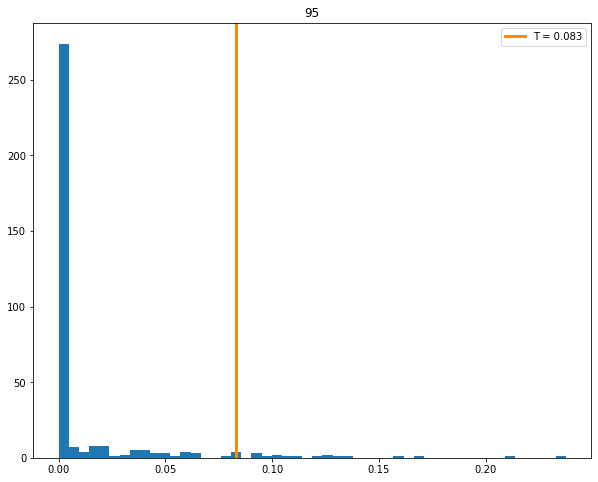

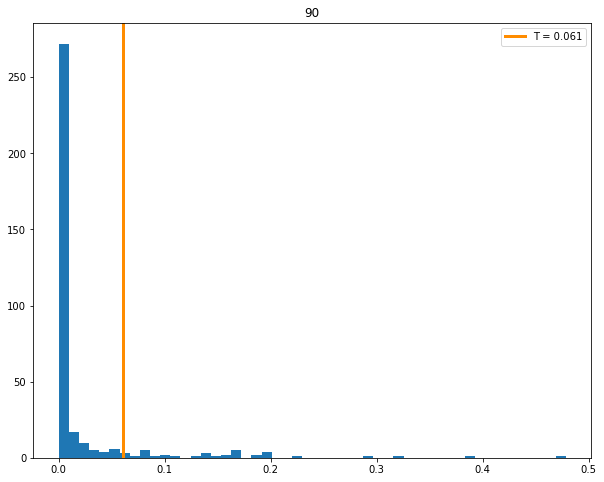

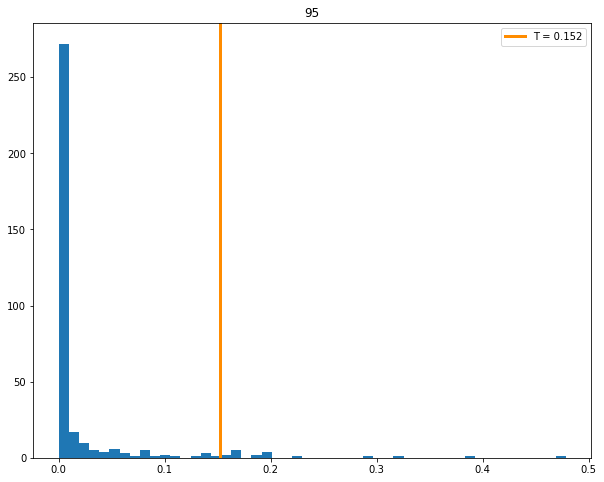

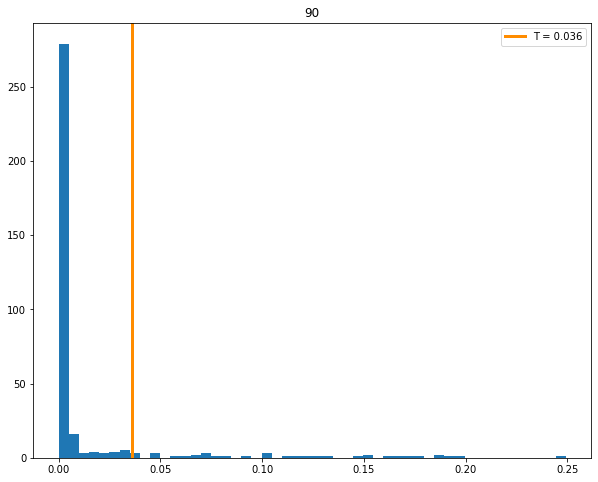

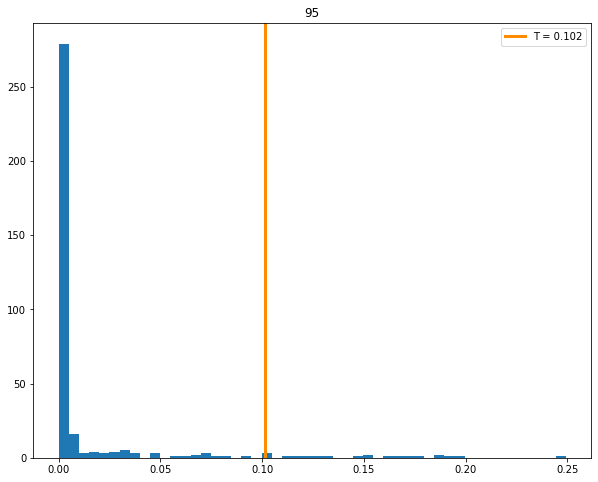

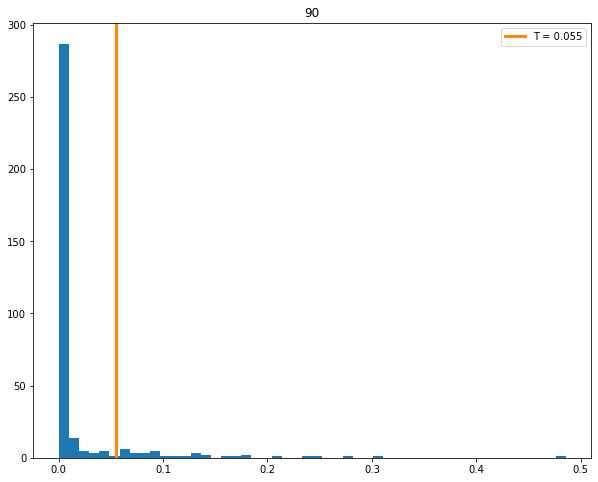

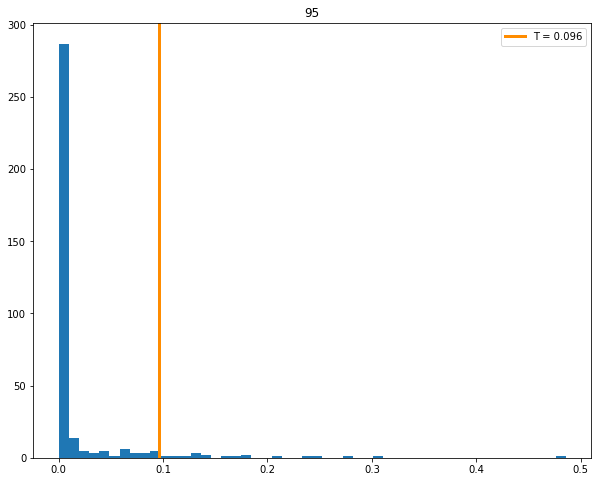

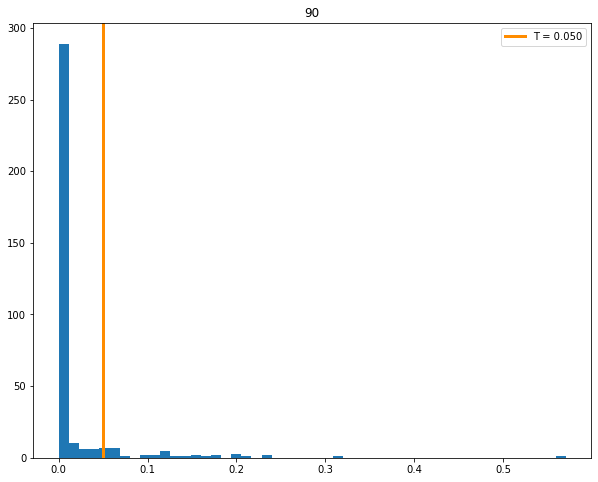

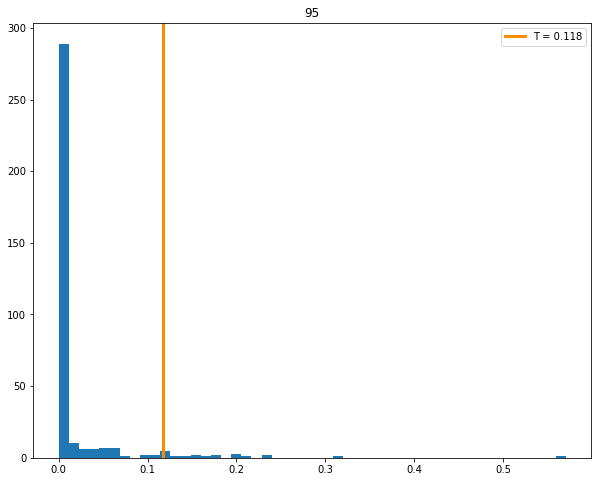

N =  400


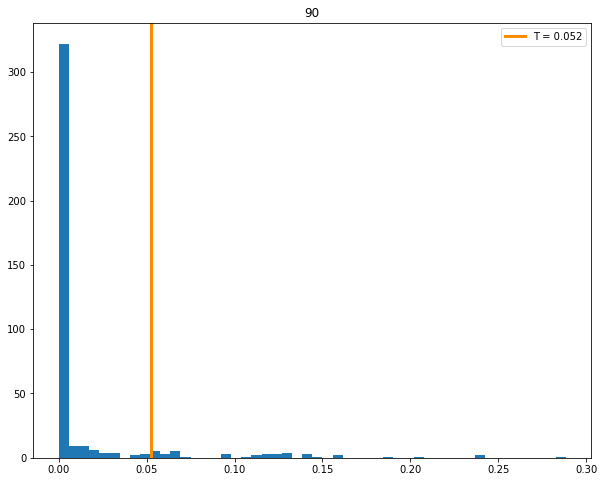

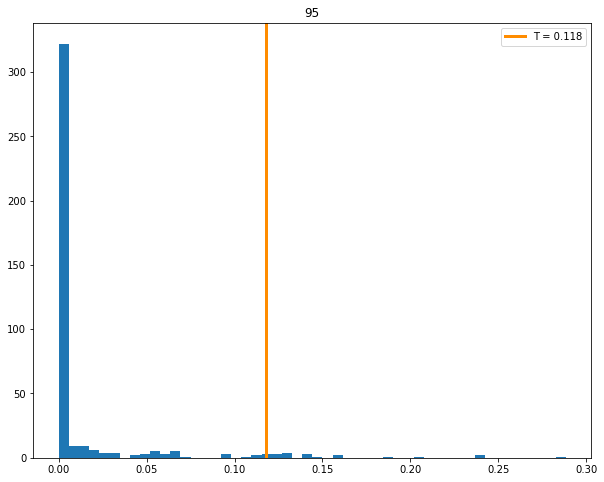

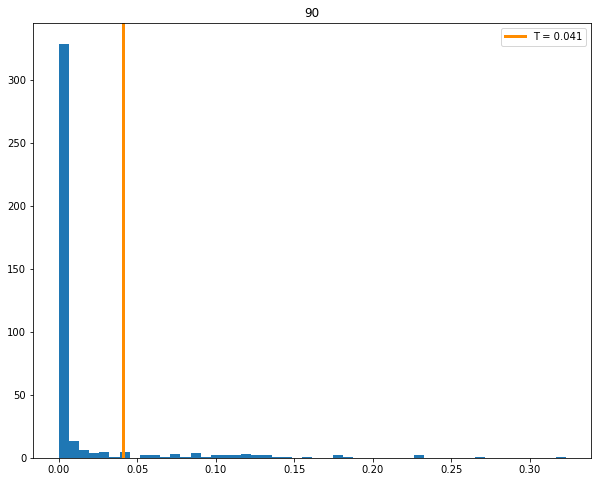

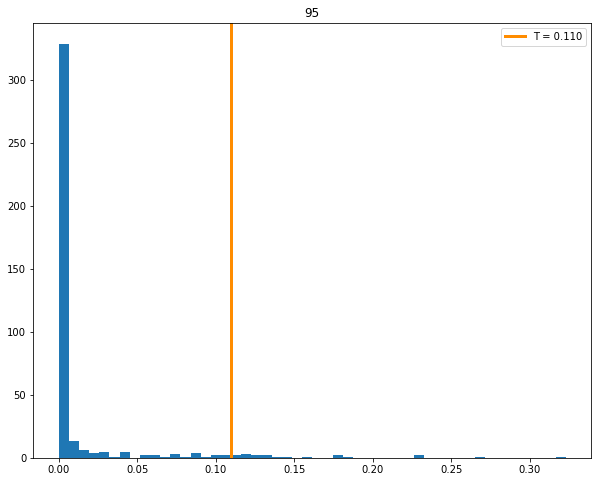

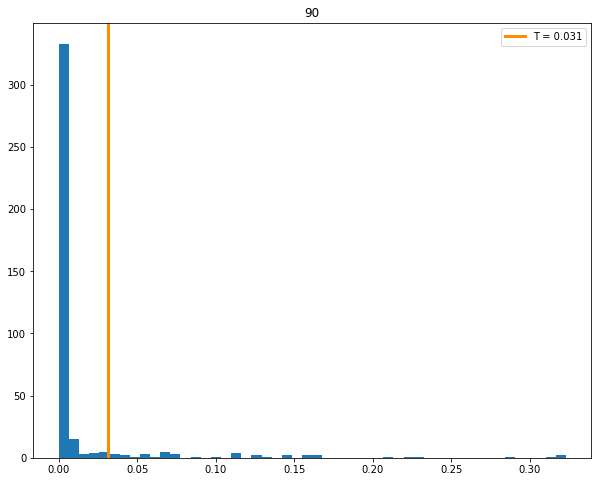

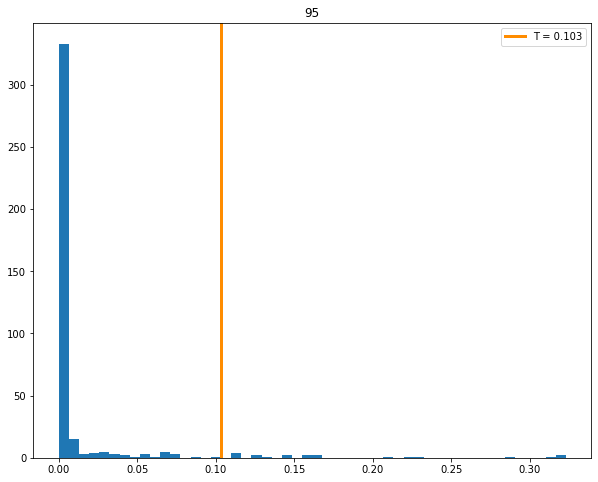

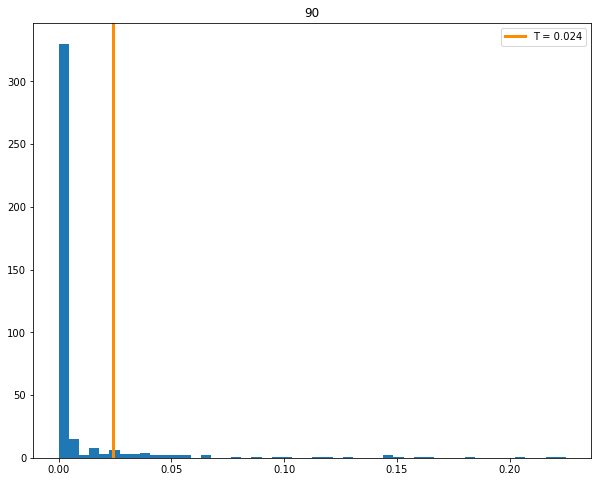

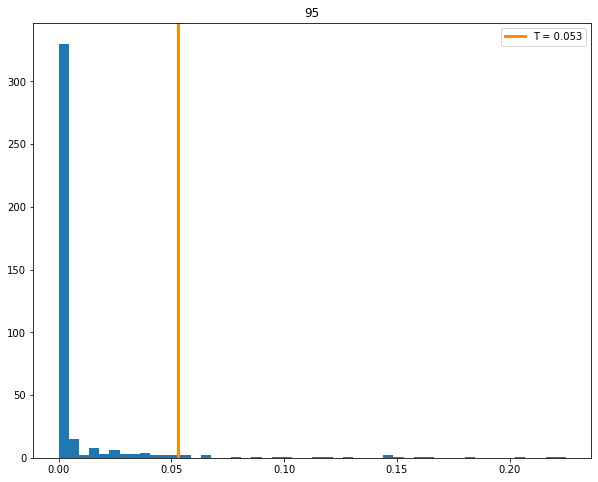

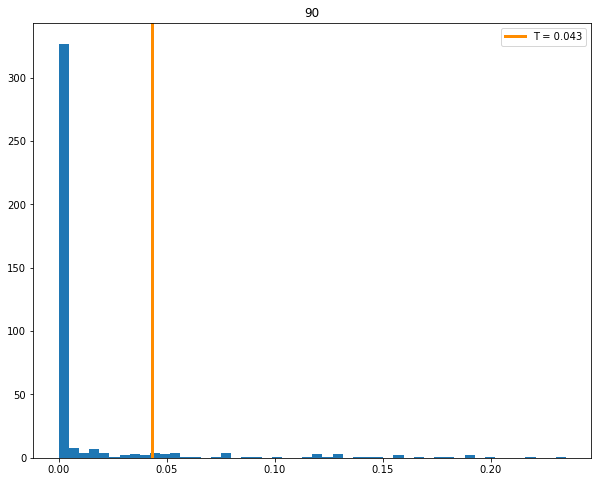

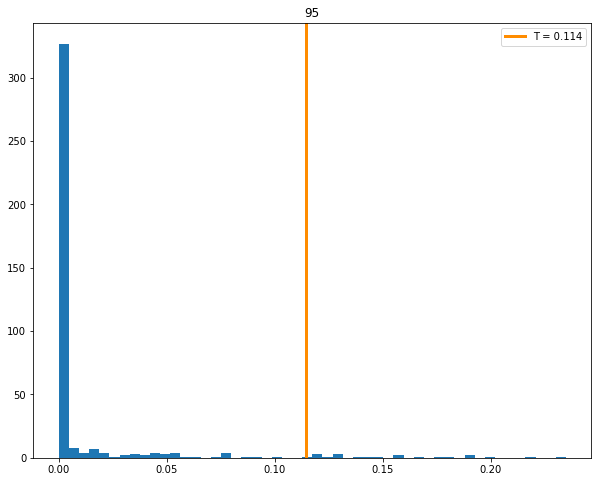

N =  450


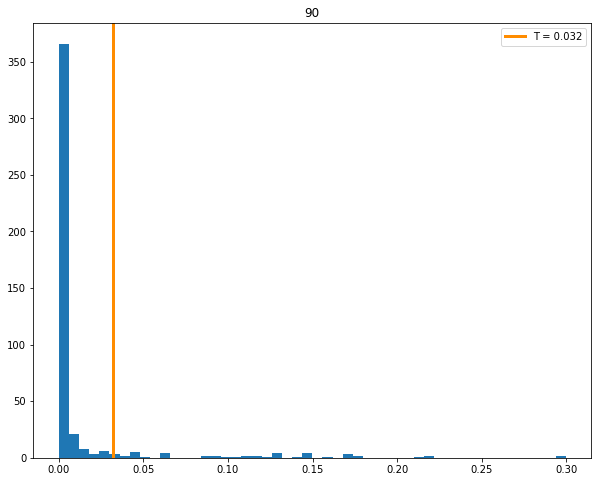

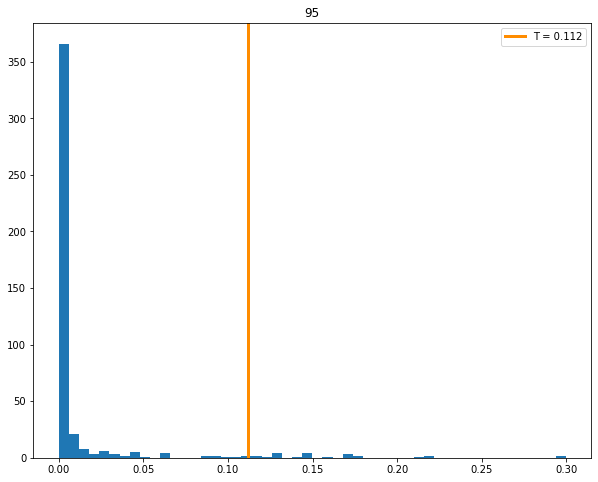

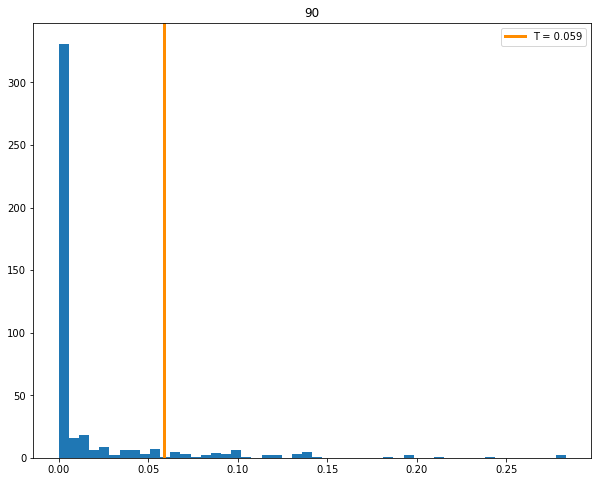

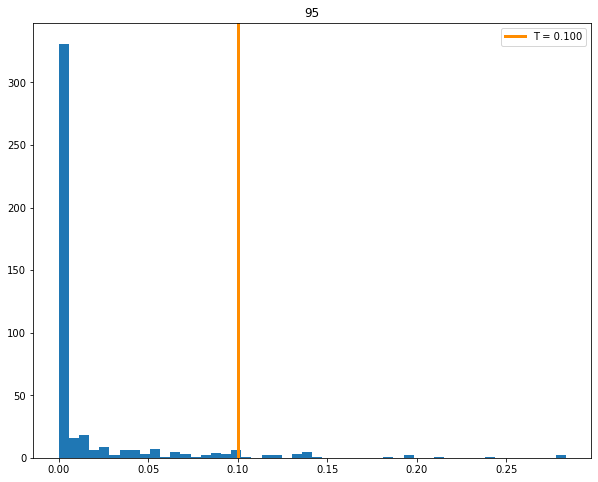

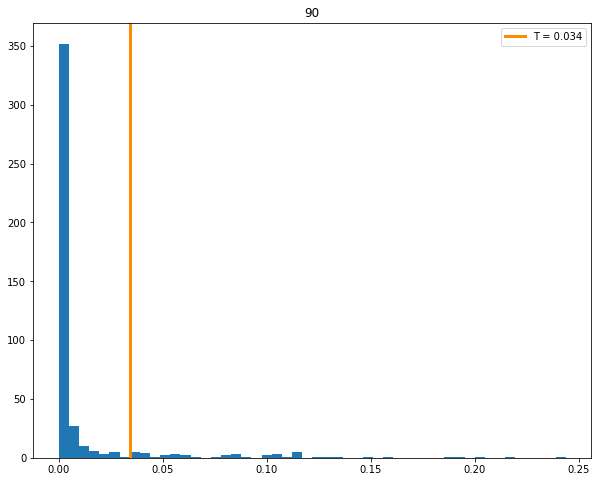

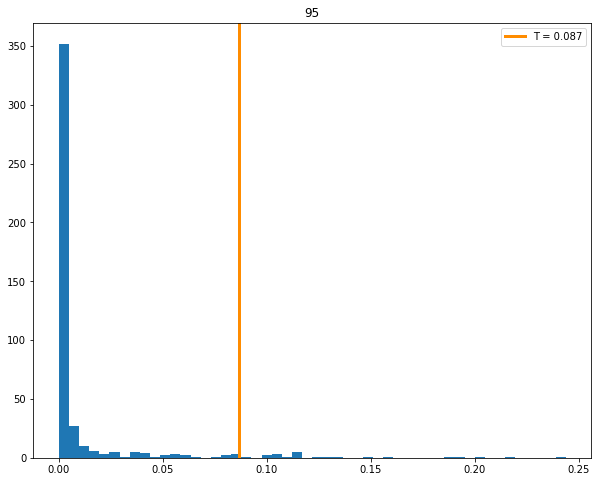

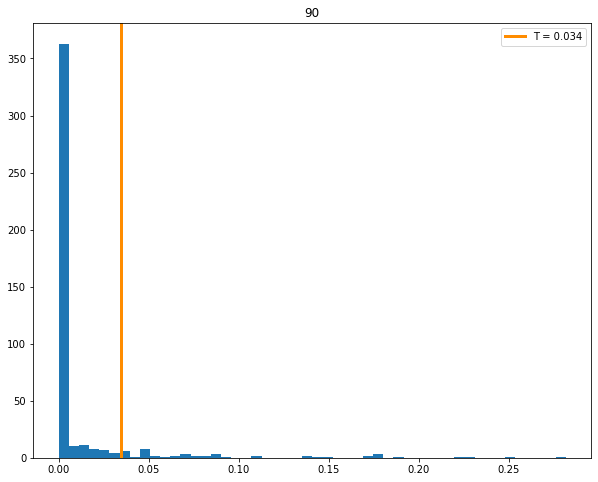

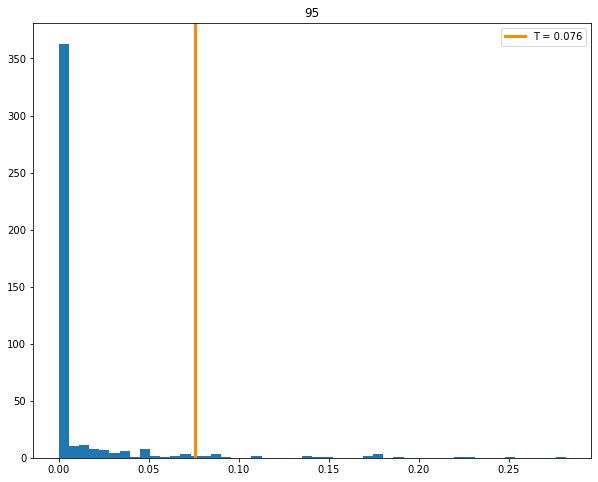

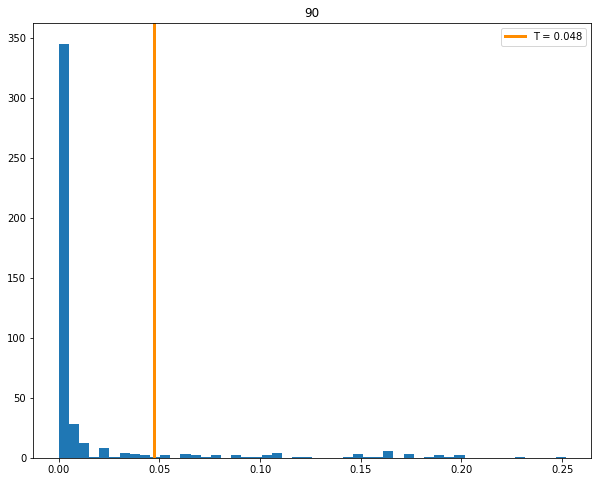

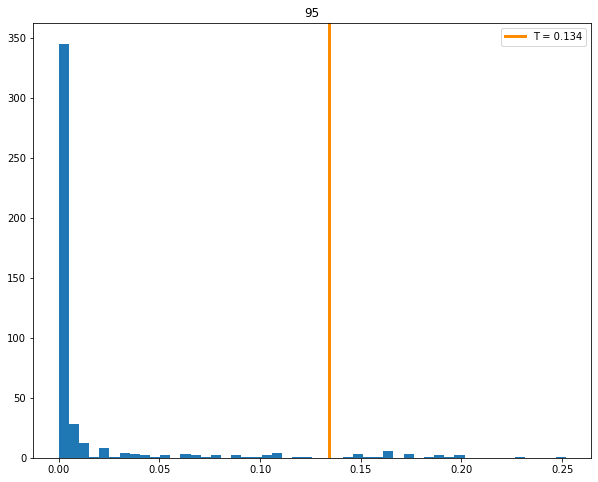

N =  500


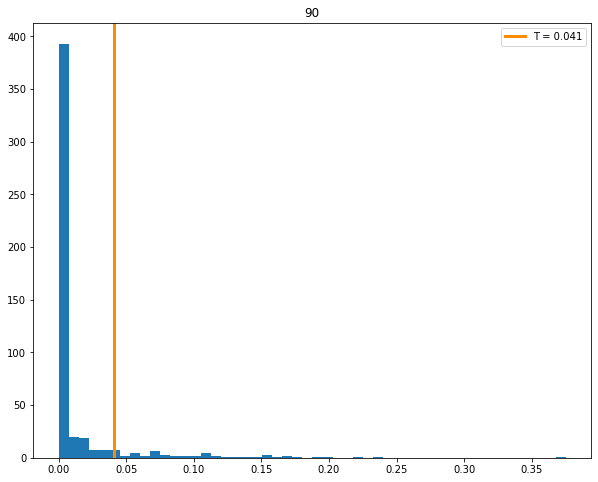

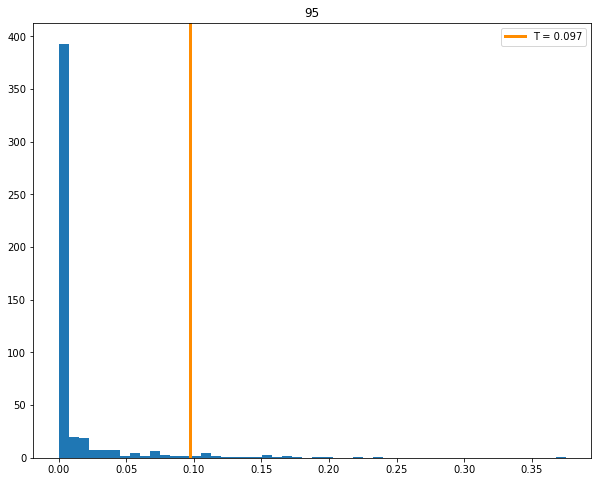

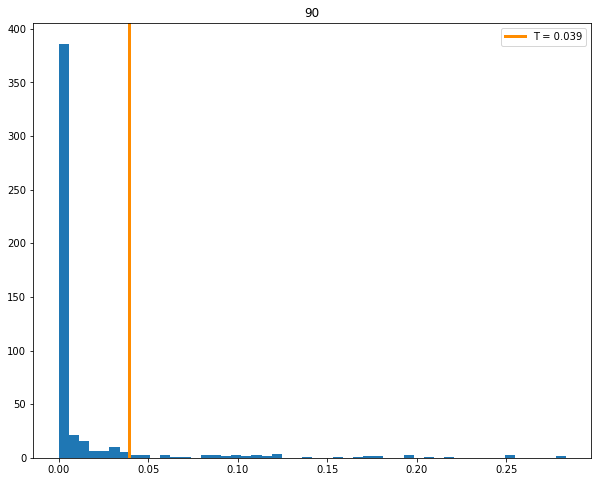

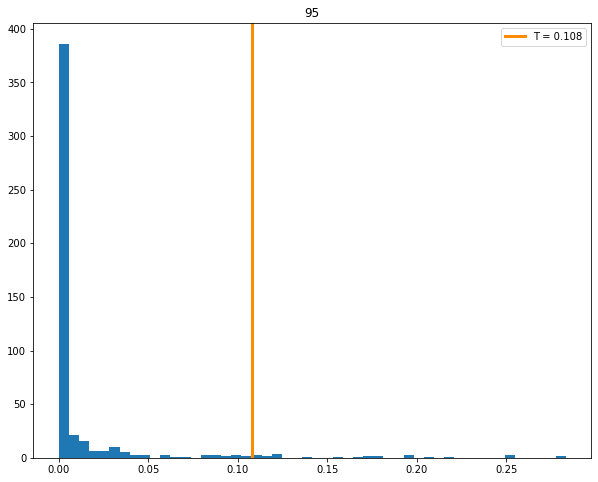

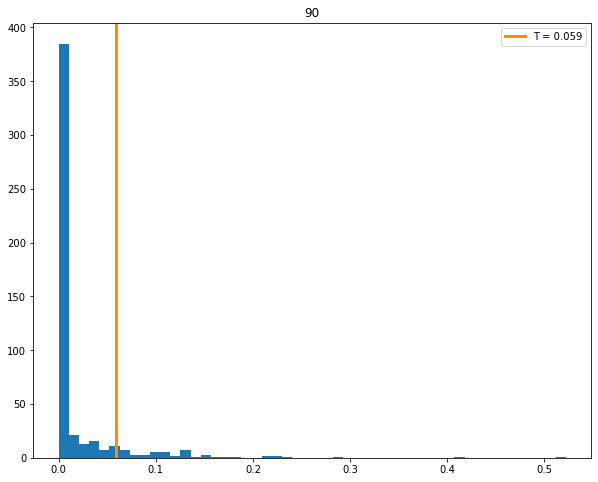

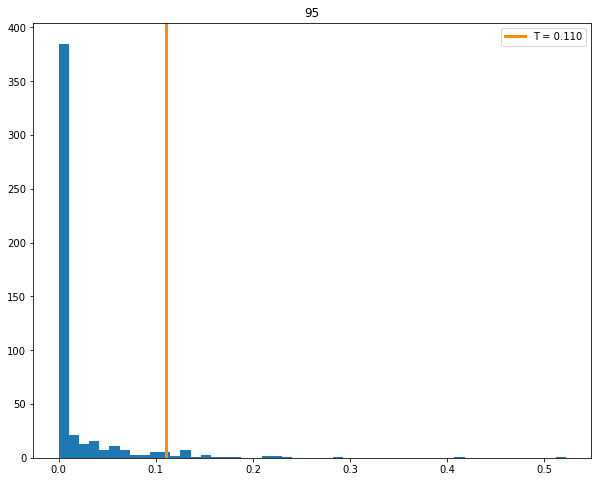

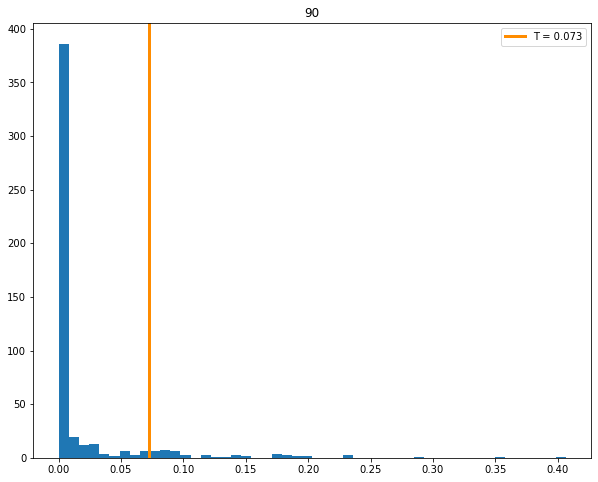

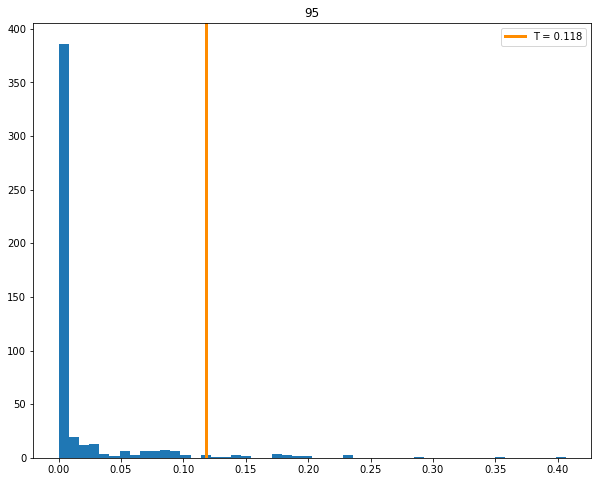

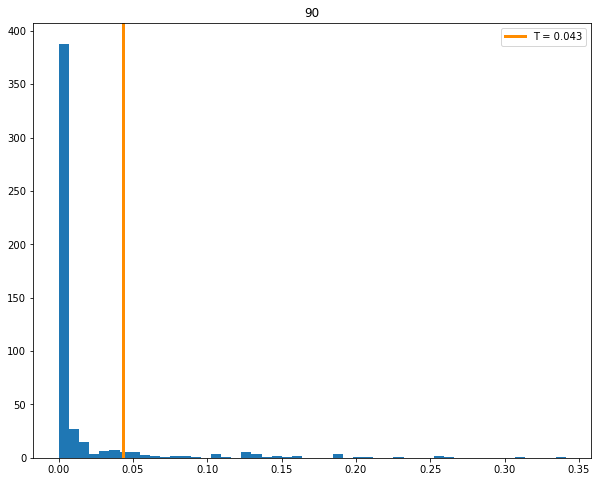

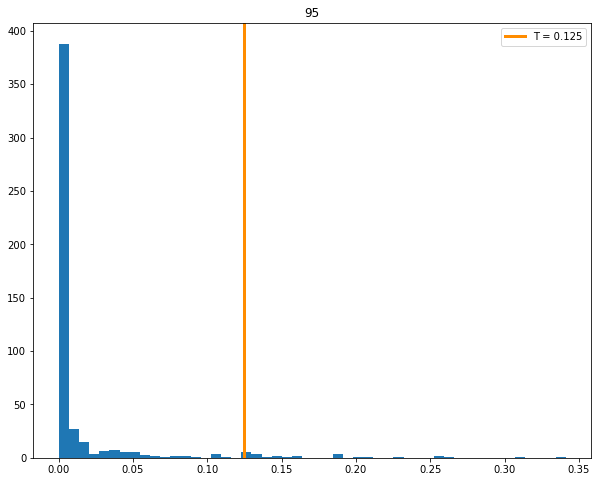

N =  550


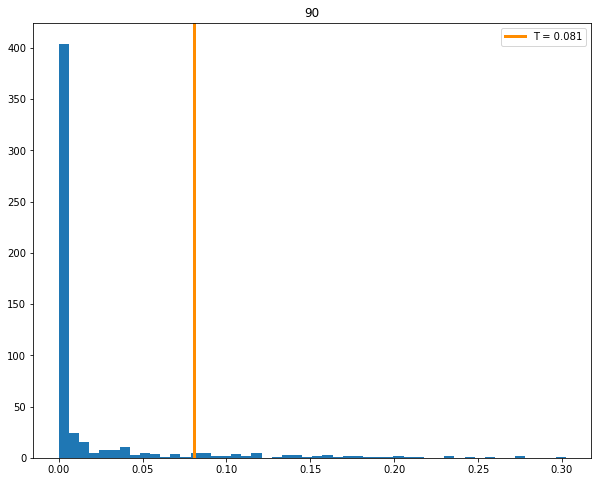

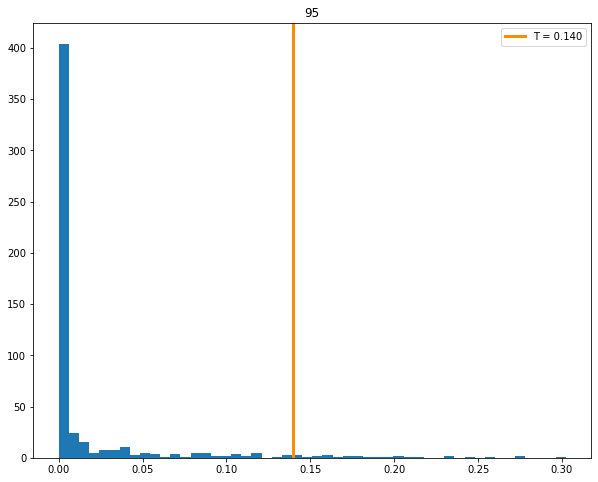

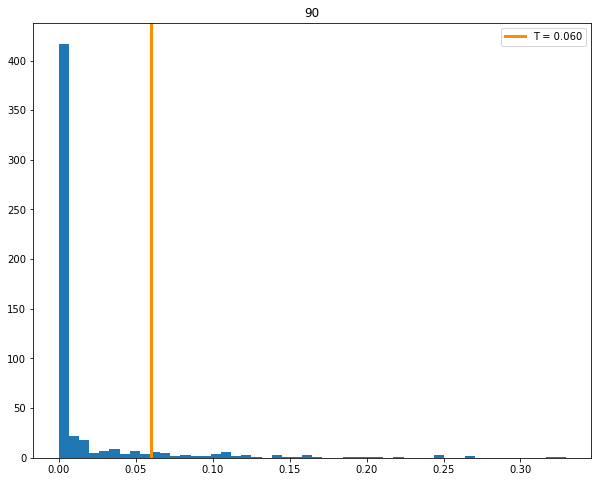

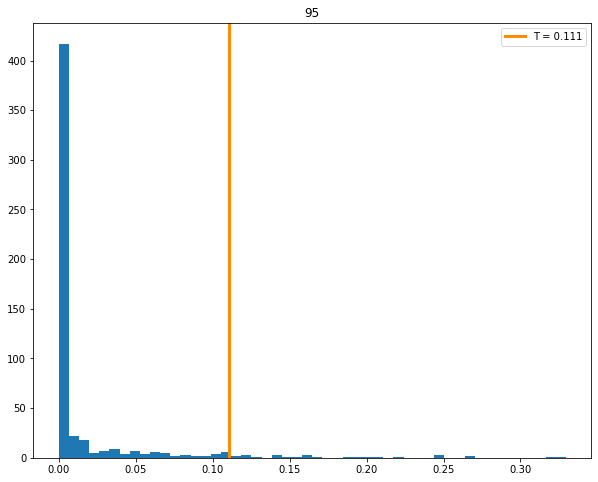

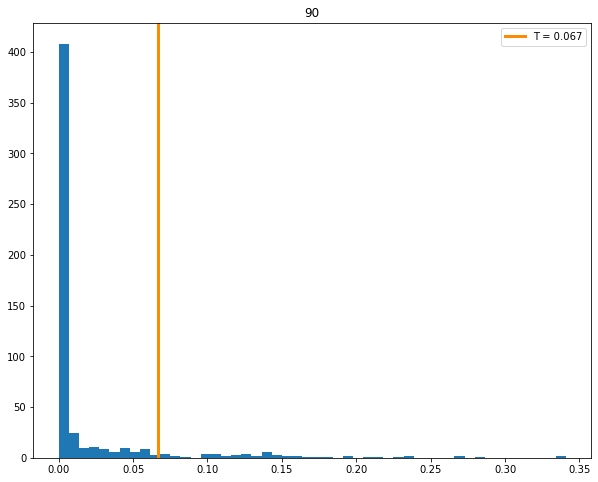

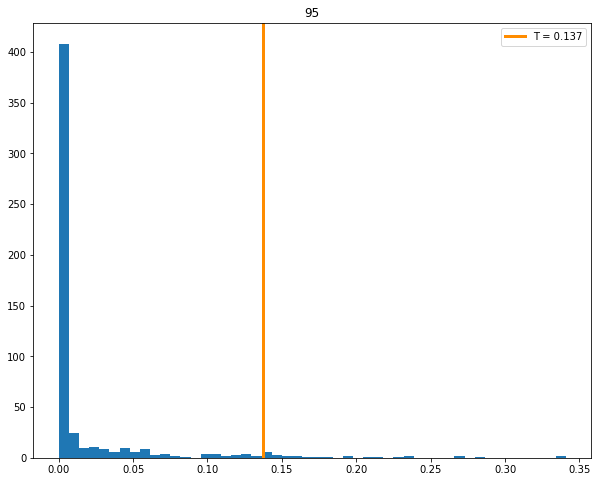

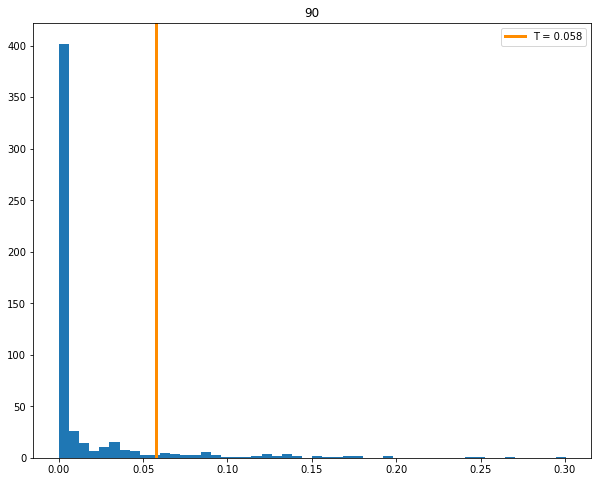

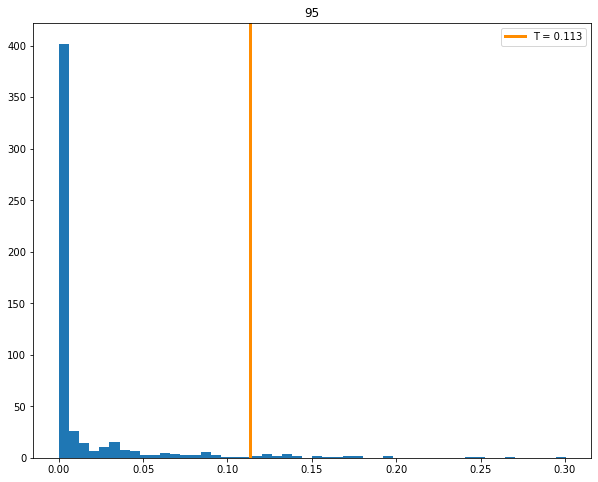

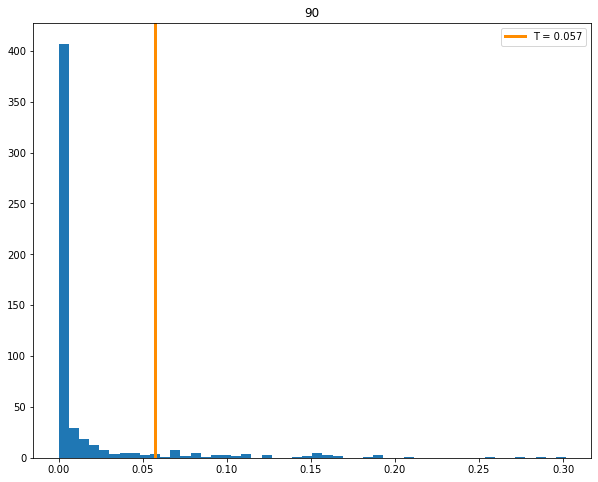

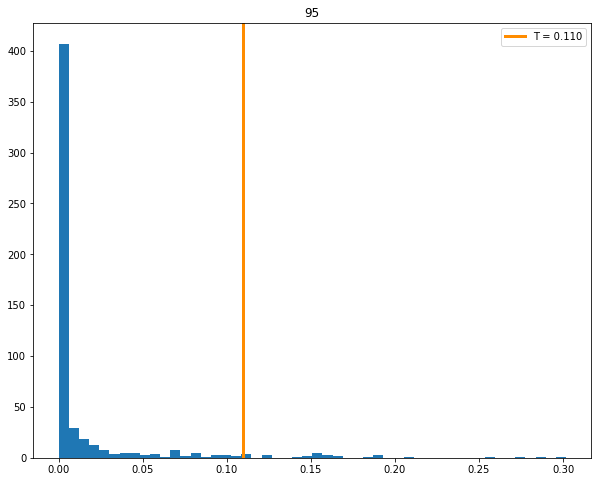

N =  600


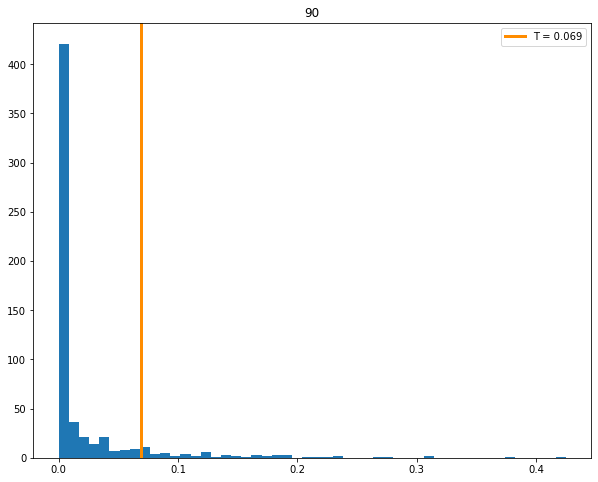

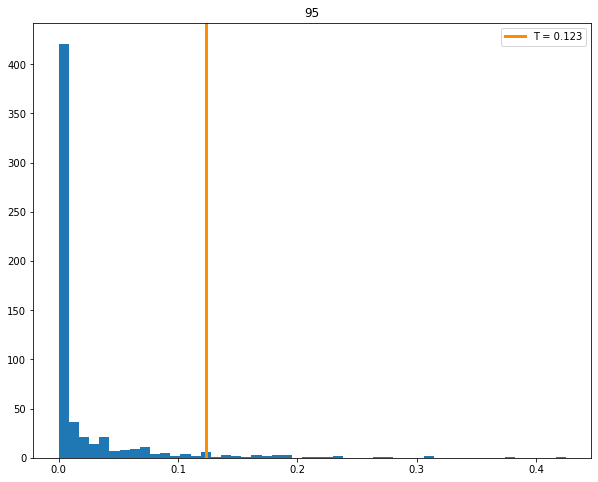

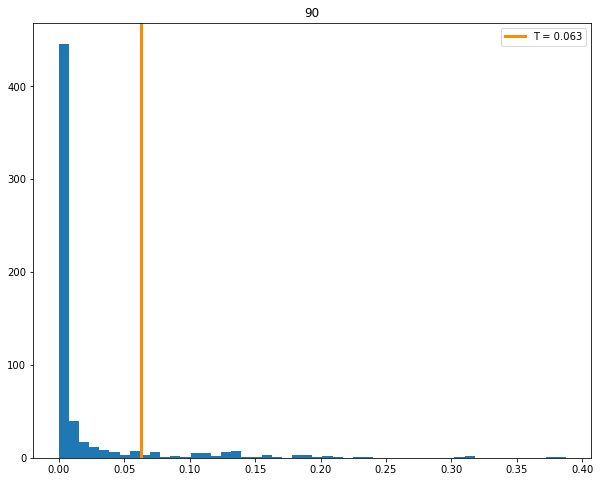

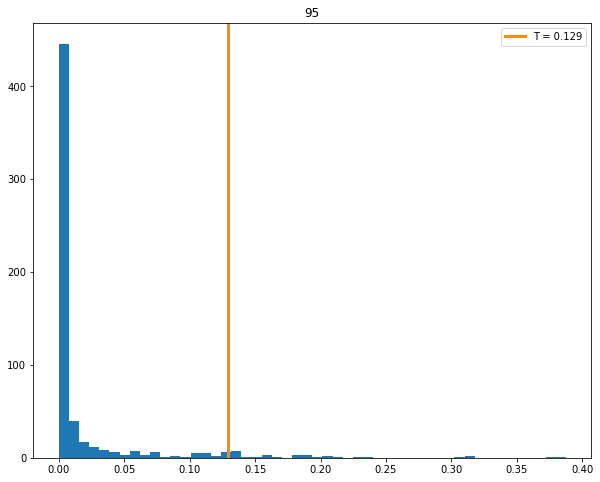

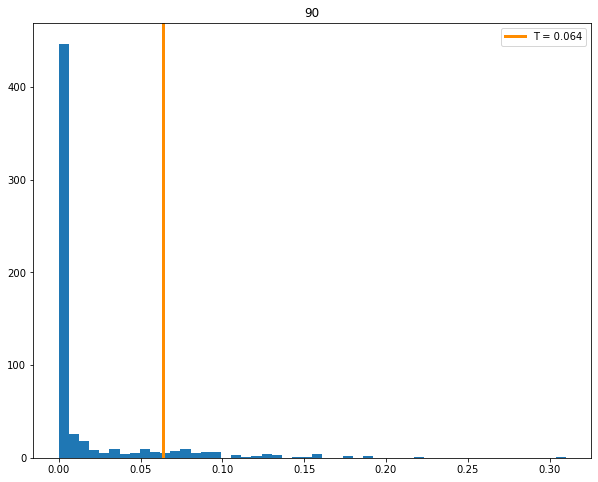

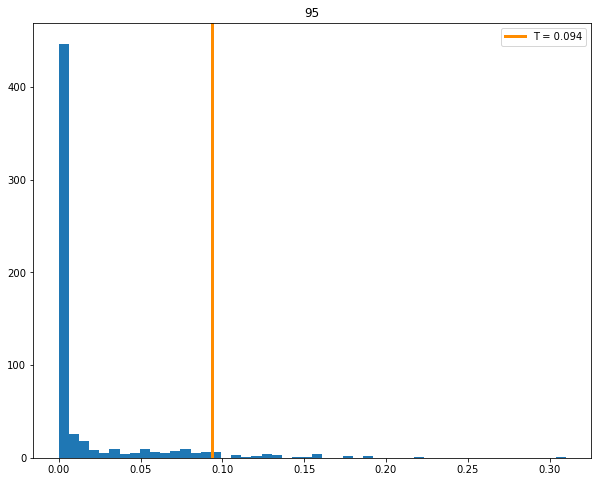

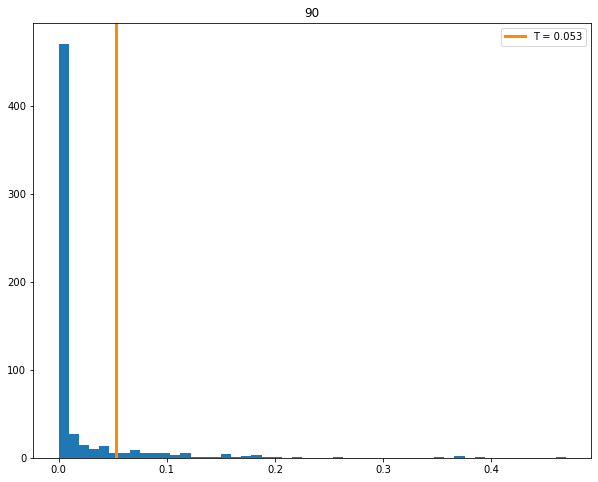

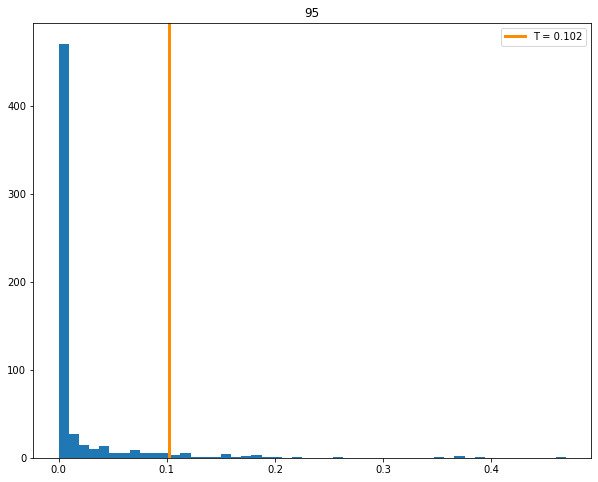

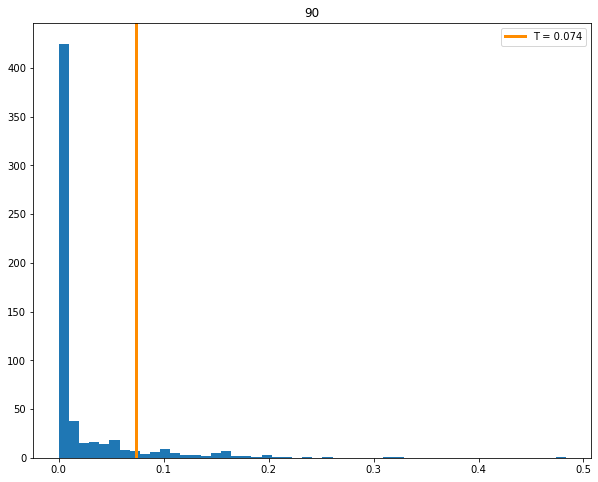

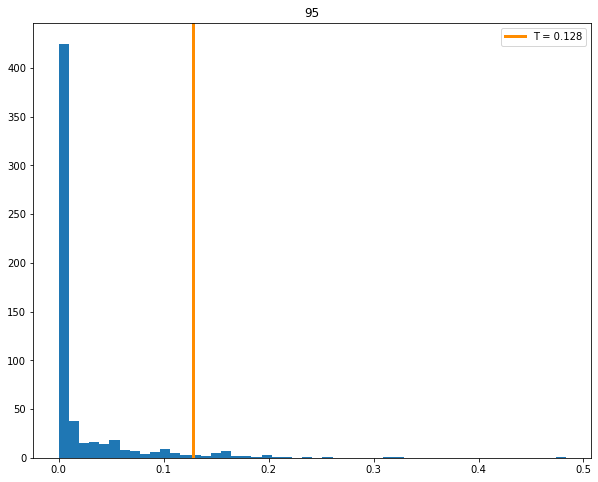

N =  650


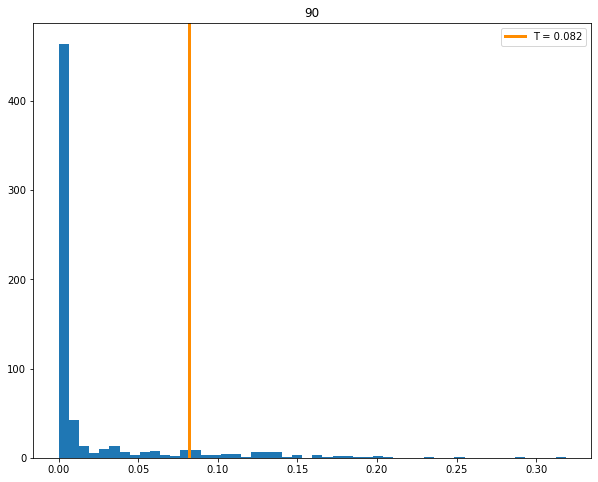

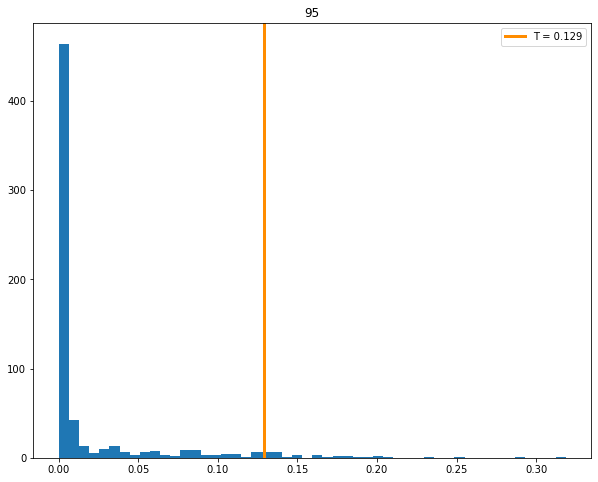

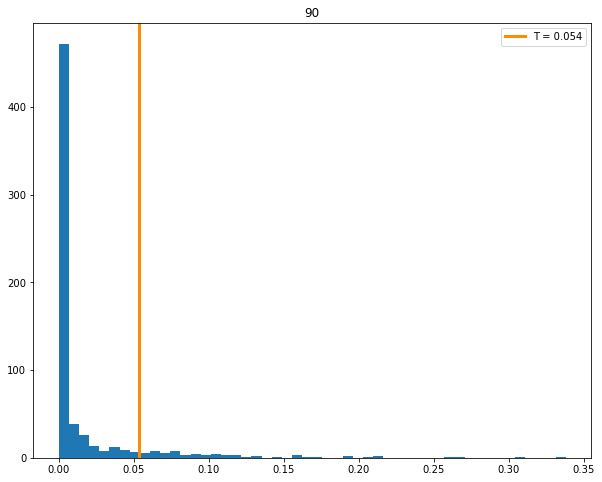

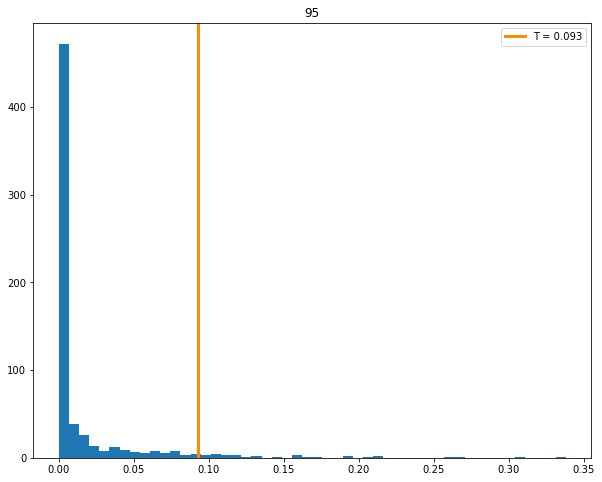

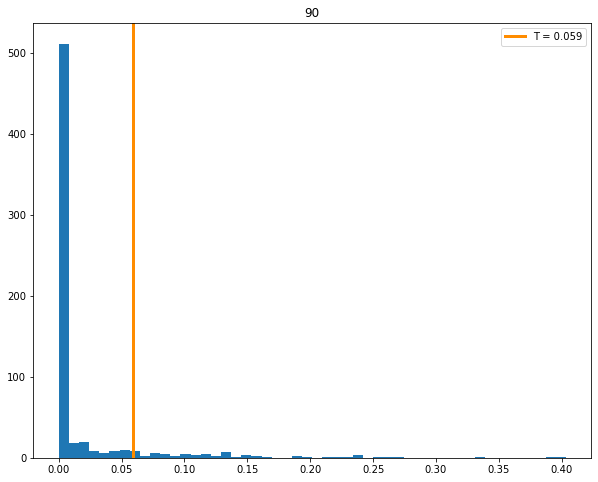

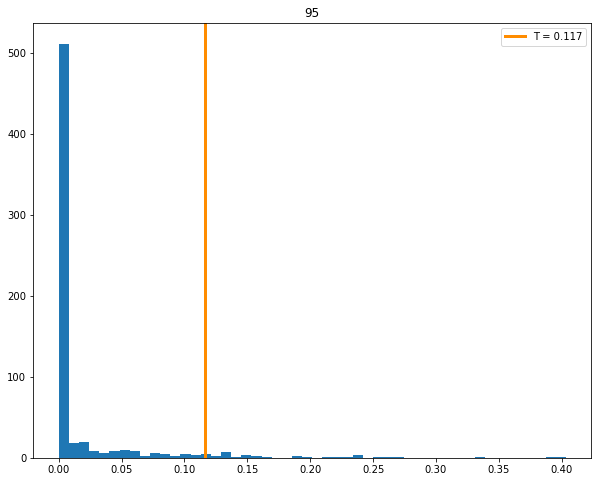

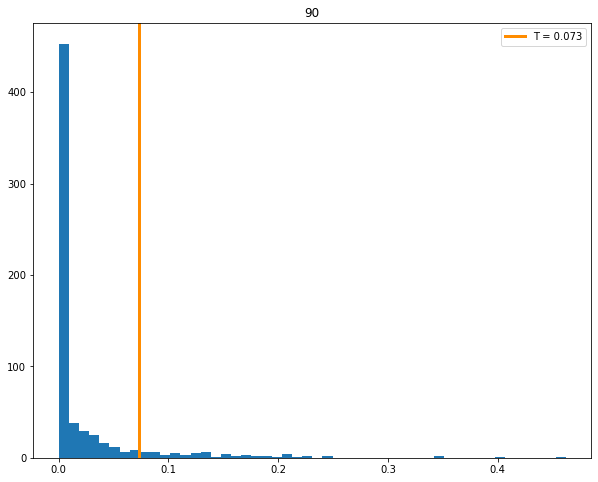

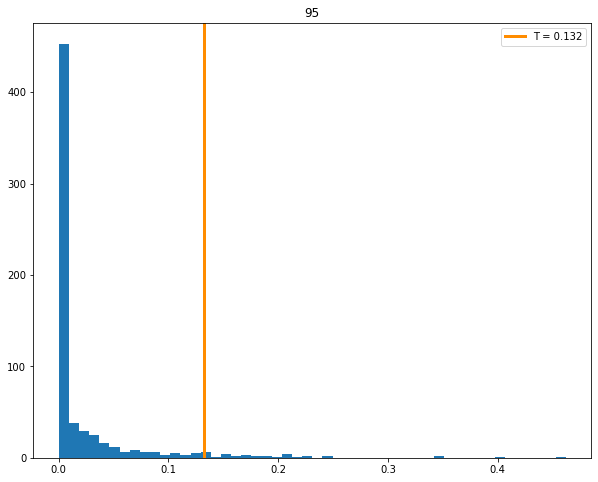

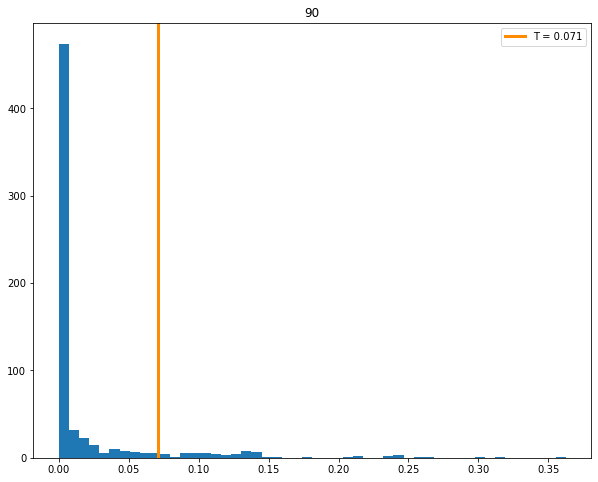

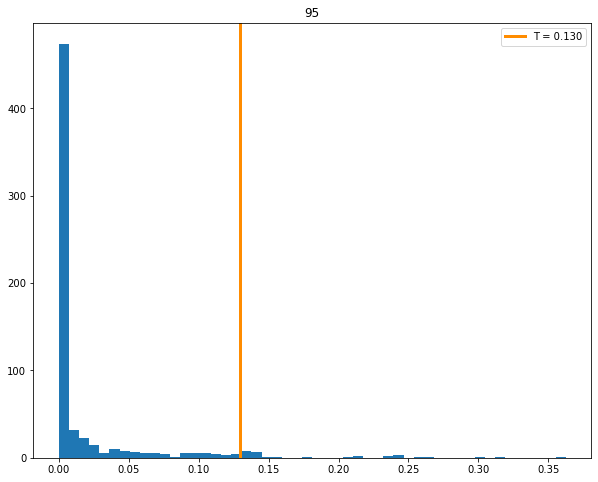

55
N =  300


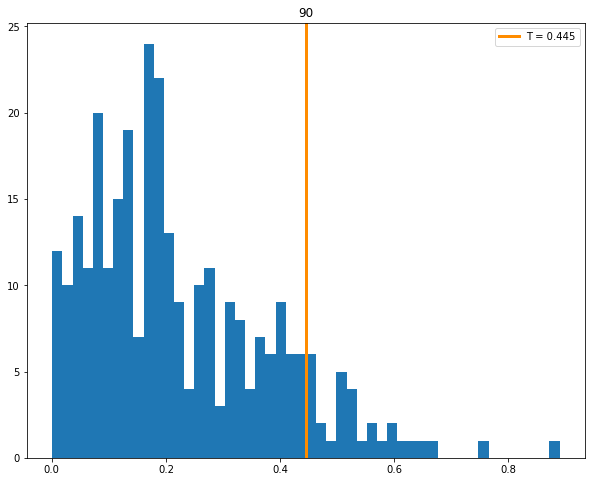

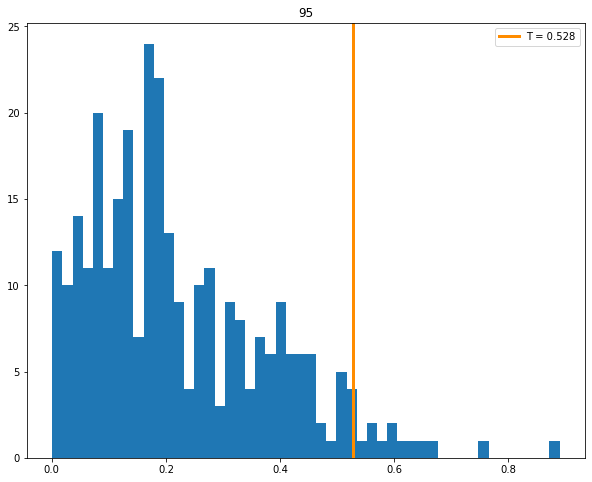

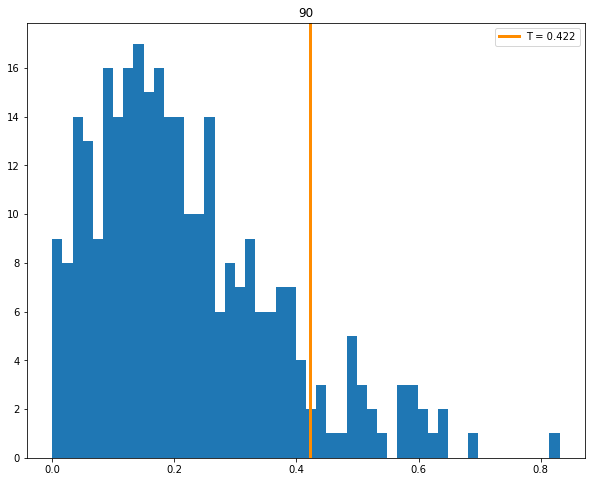

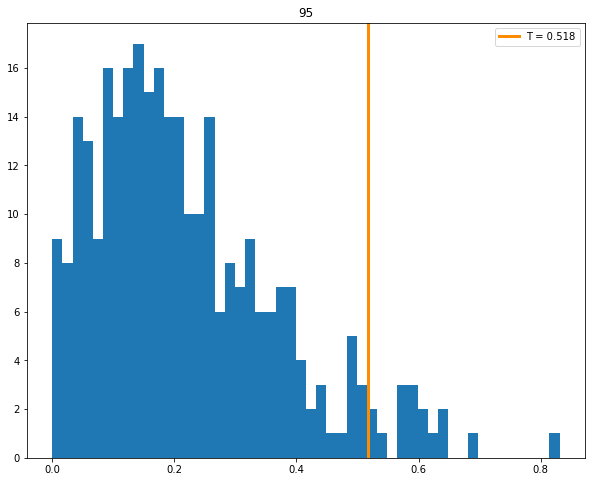

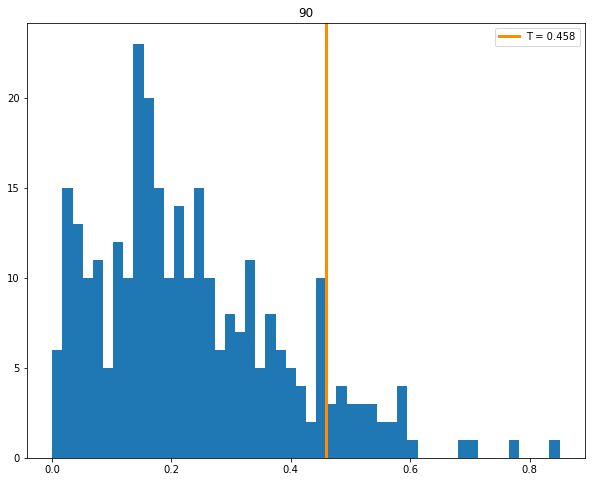

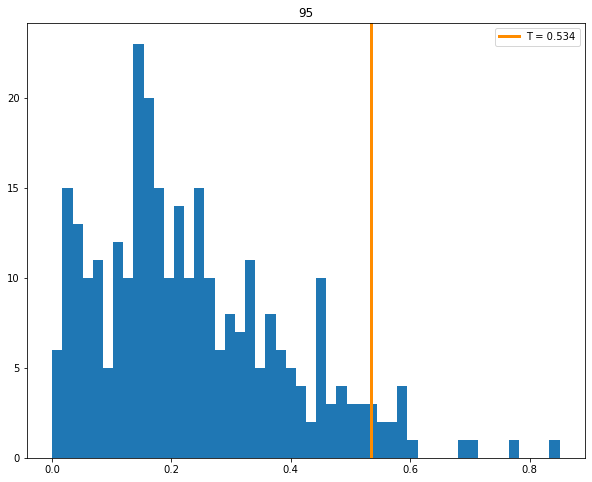

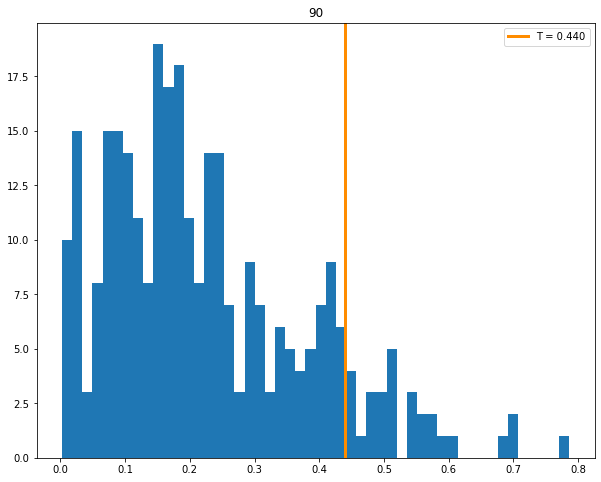

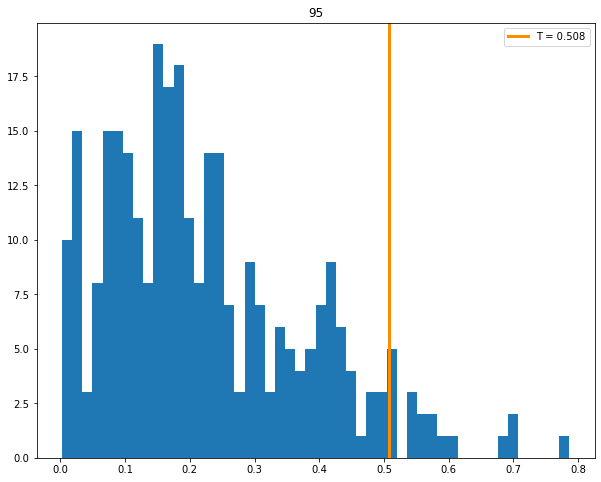

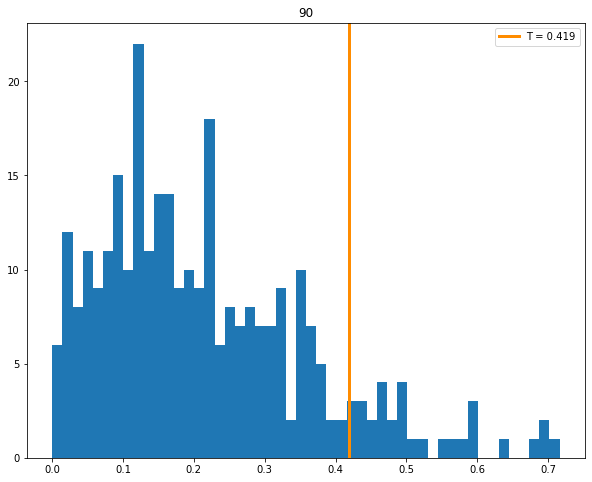

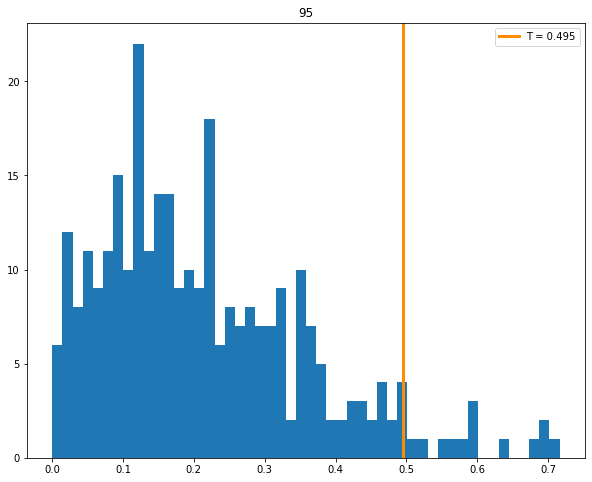

N =  350


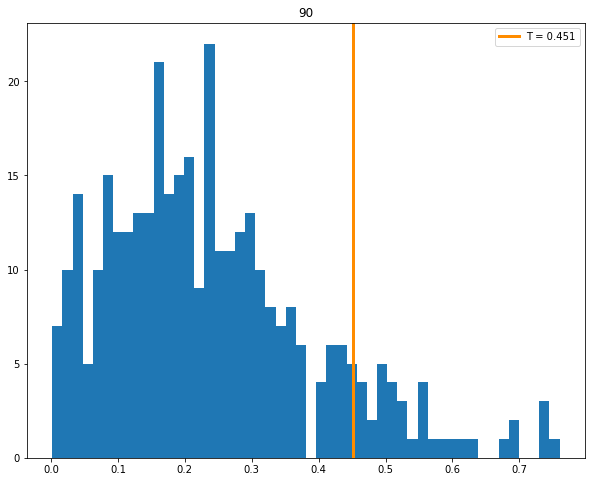

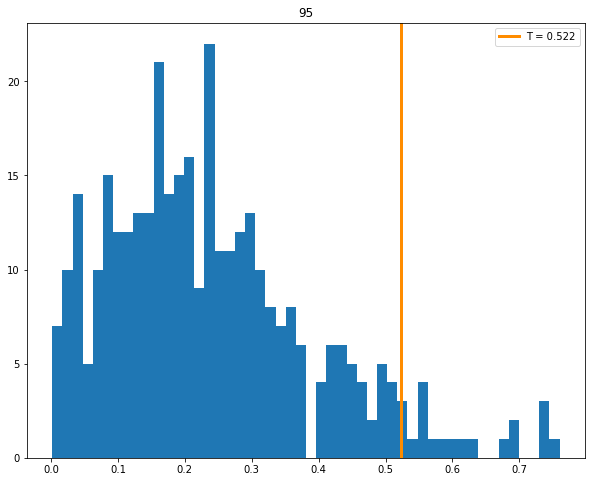

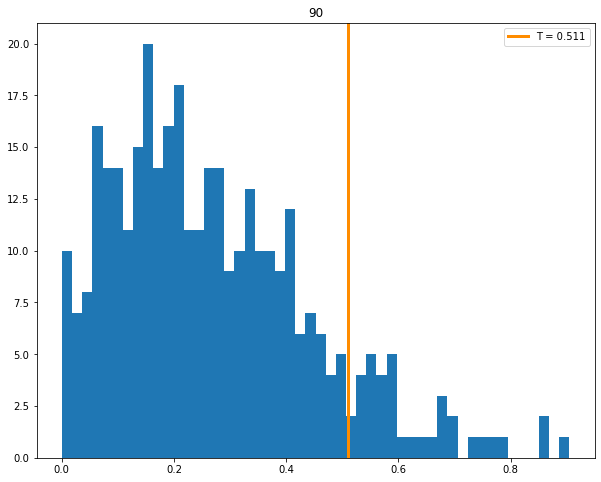

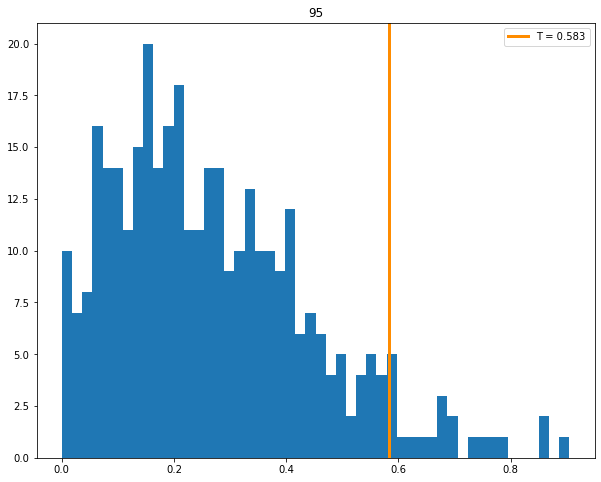

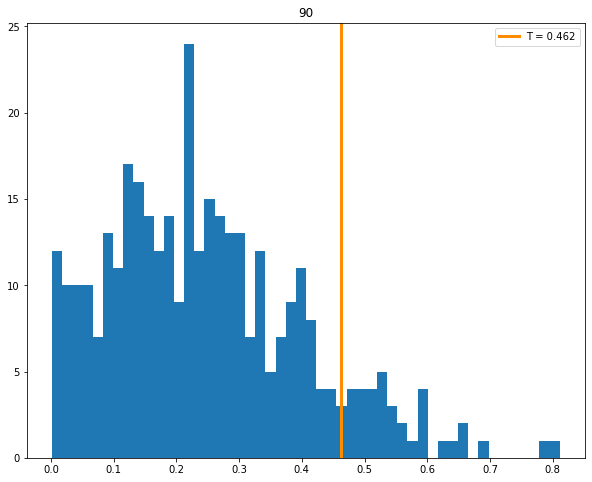

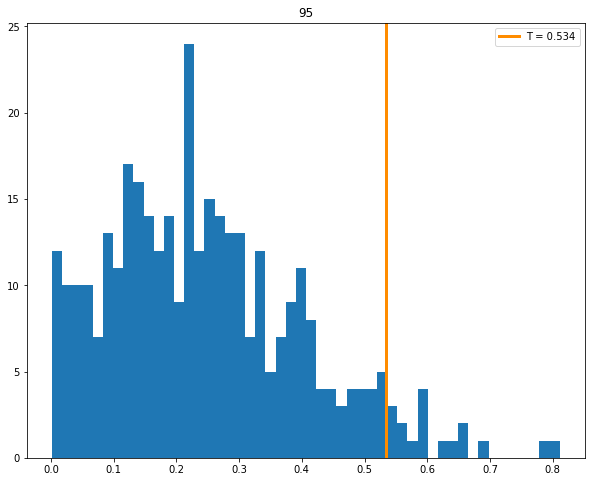

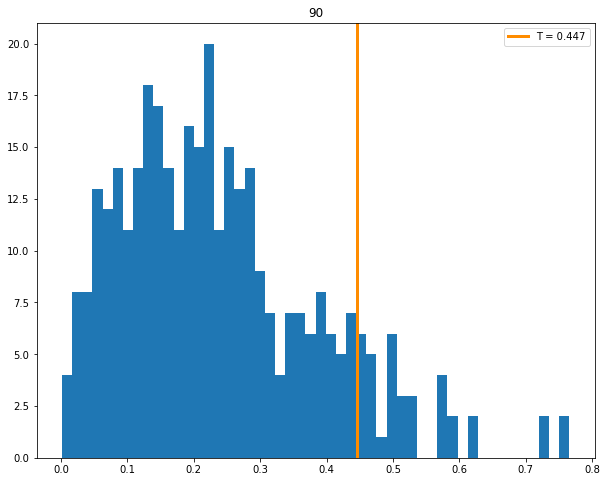

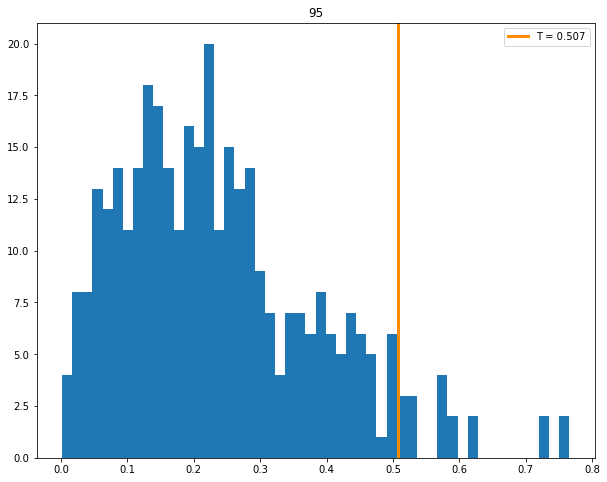

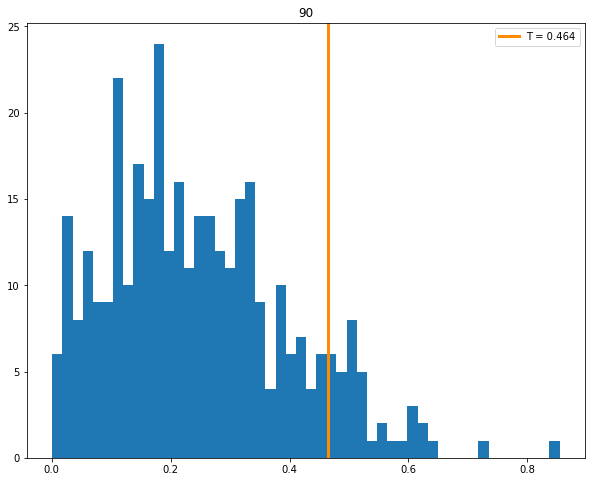

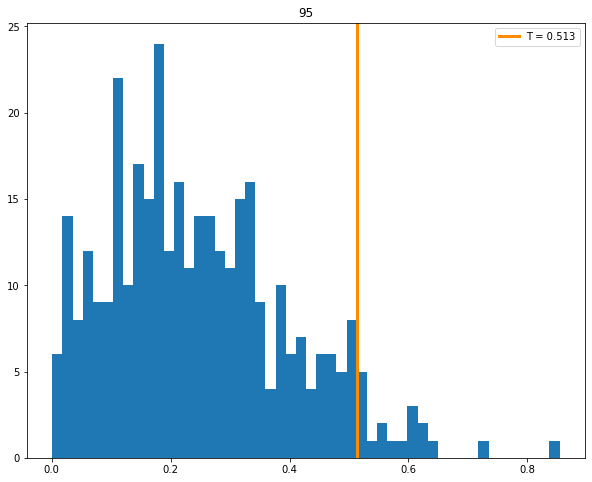

N =  400


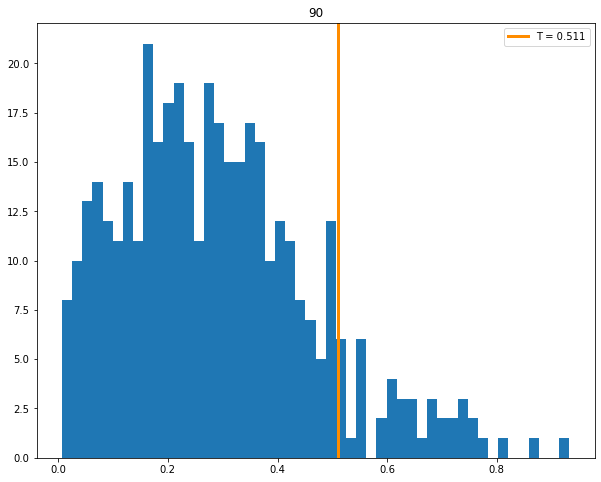

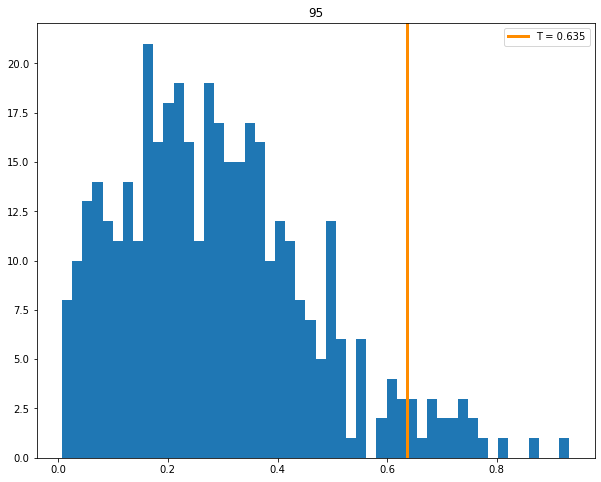

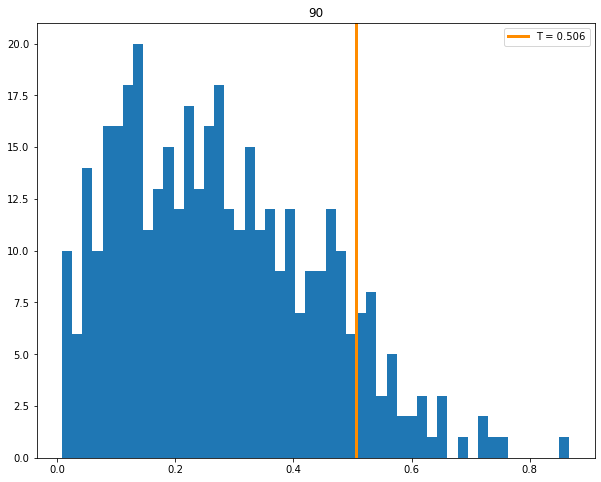

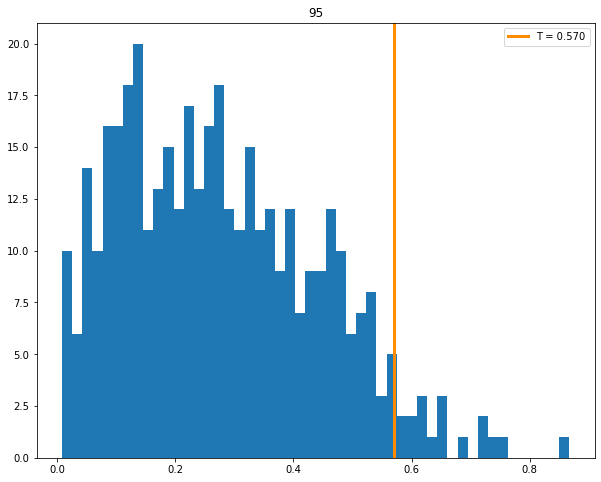

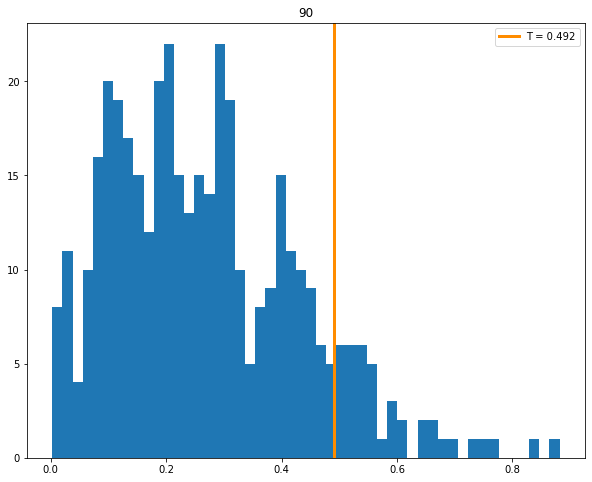

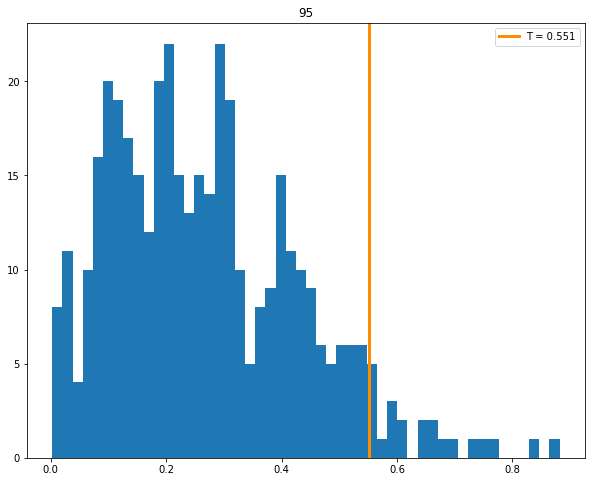

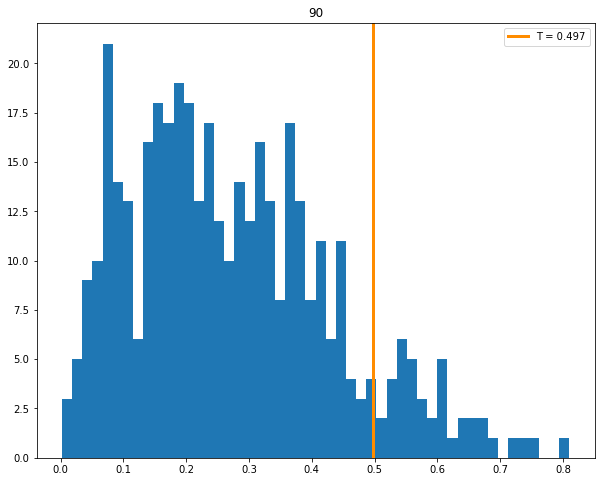

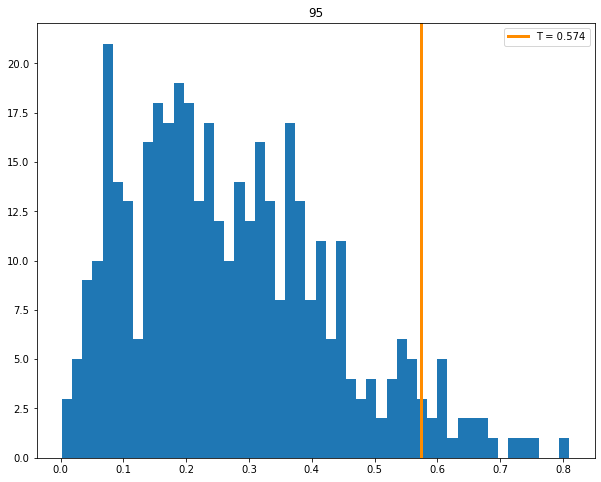

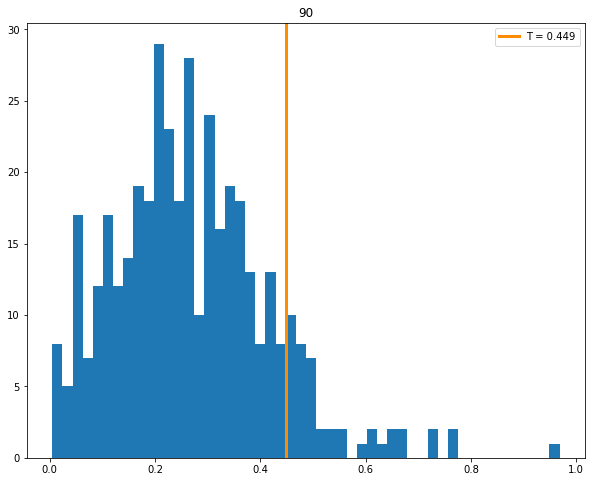

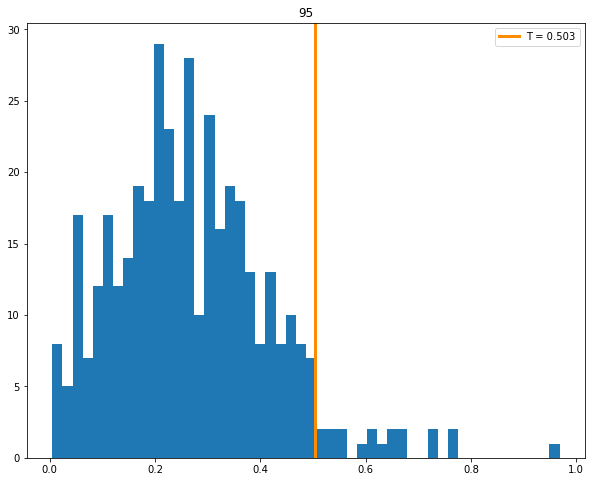

N =  450


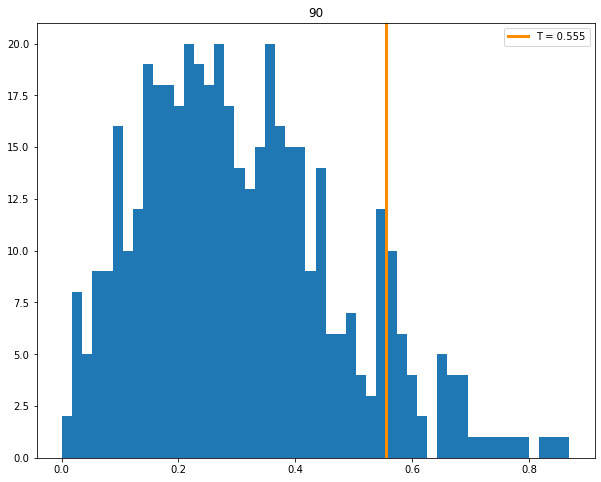

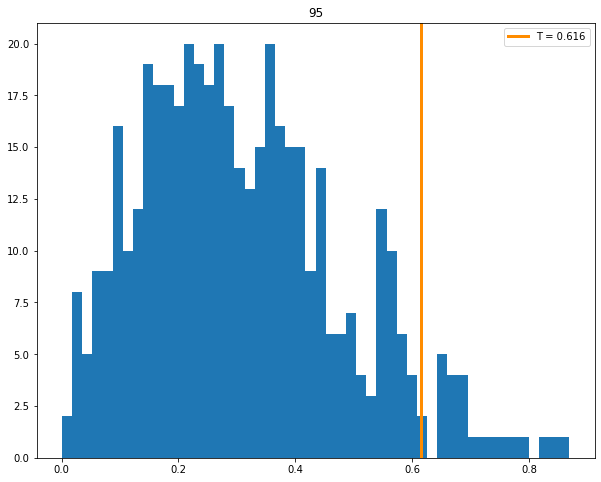

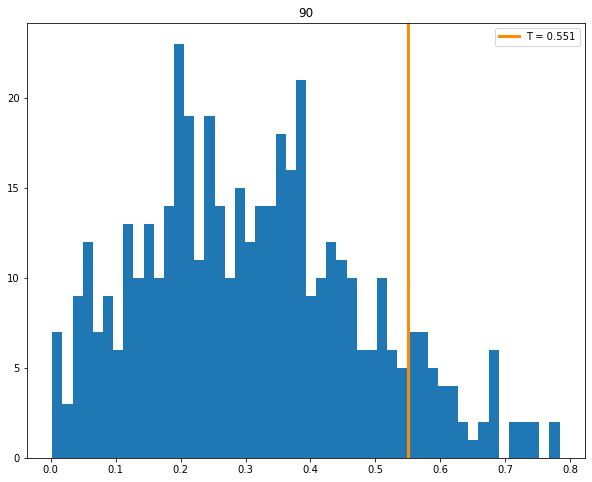

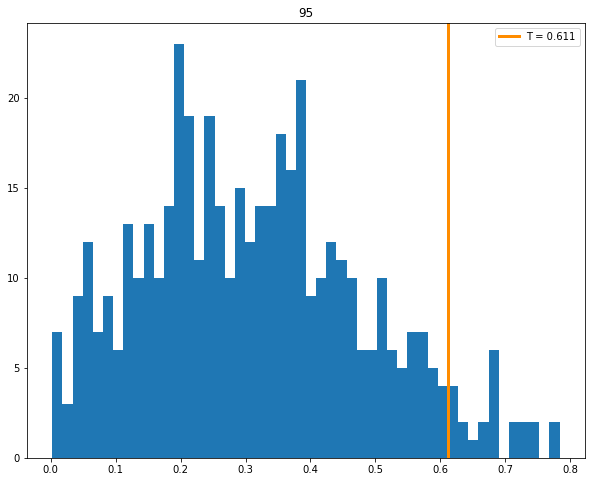

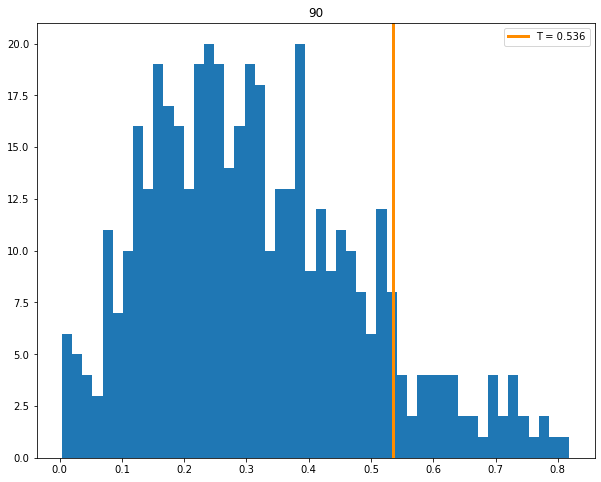

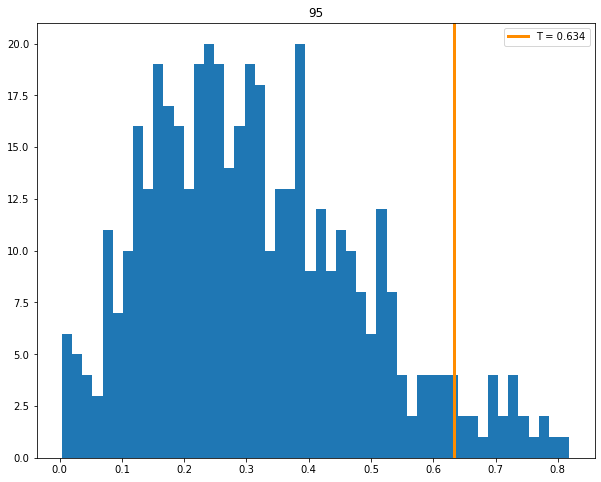

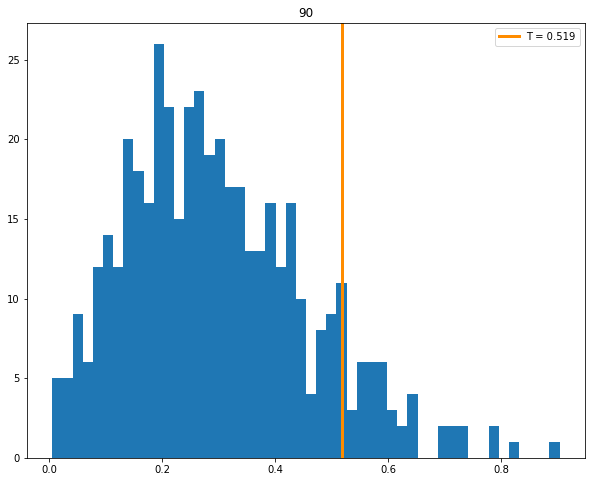

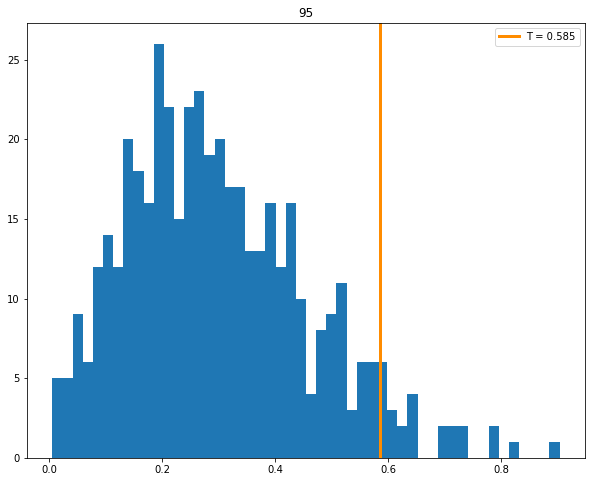

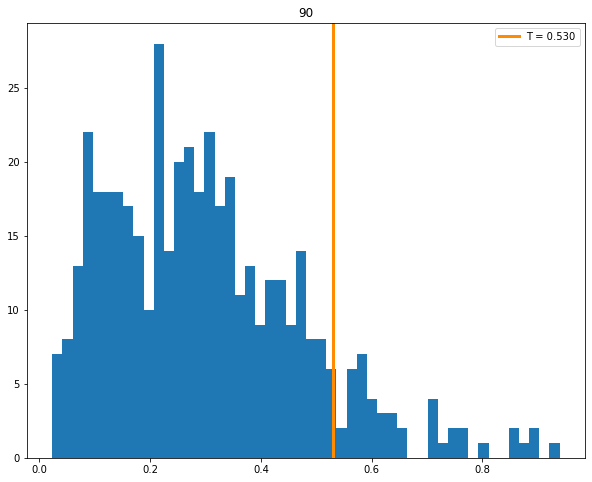

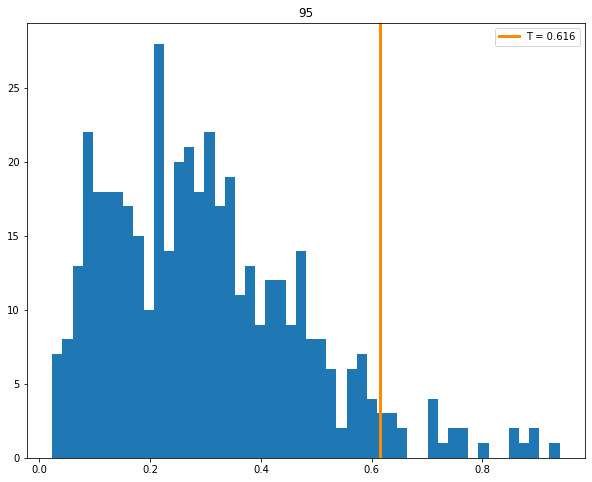

N =  500


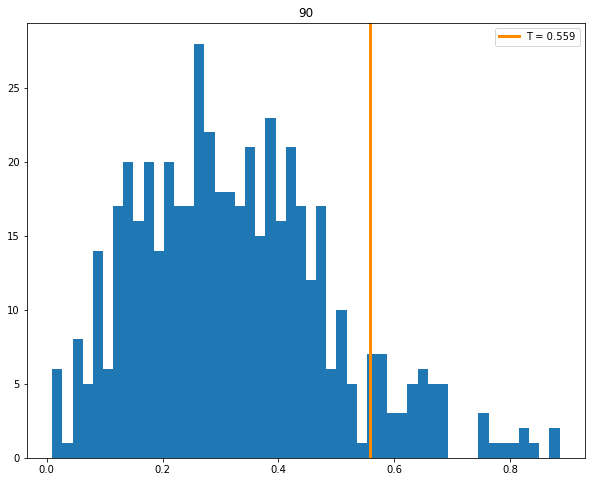

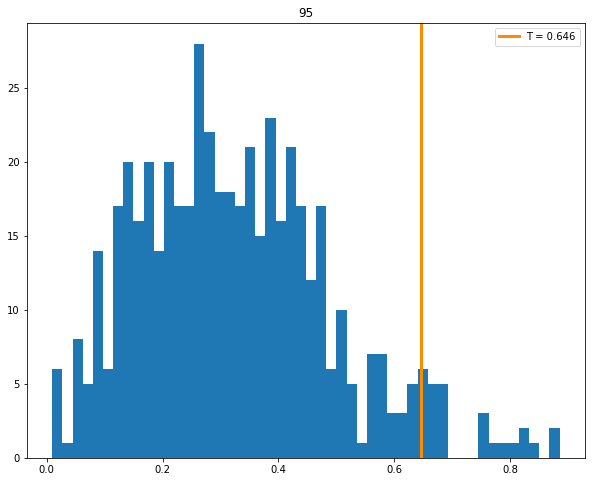

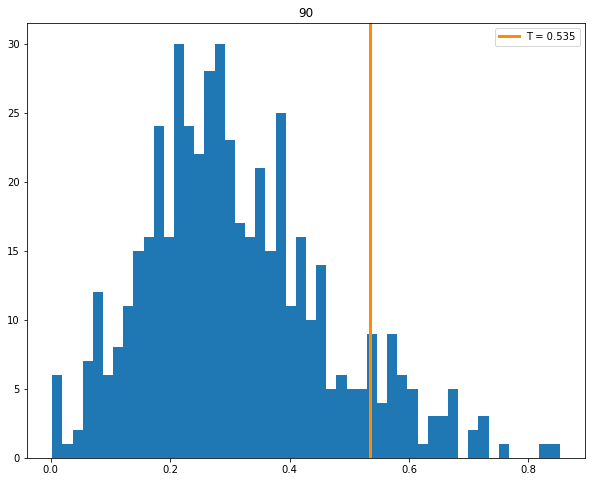

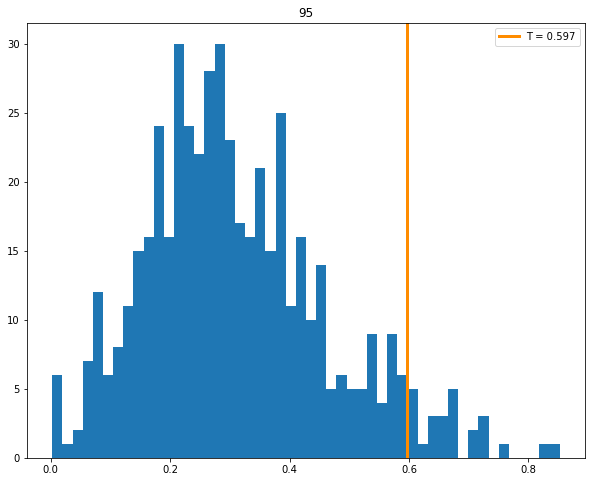

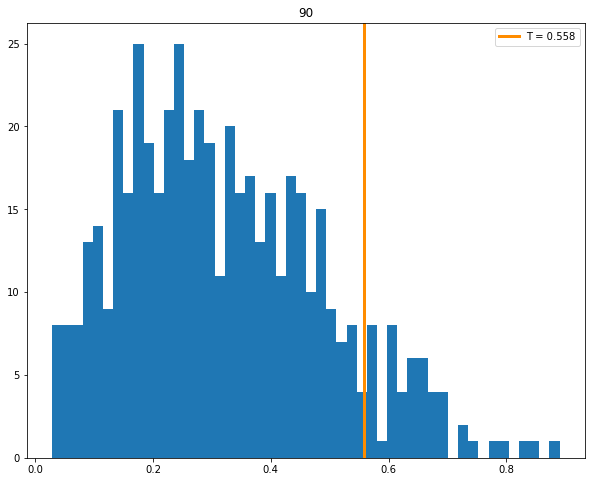

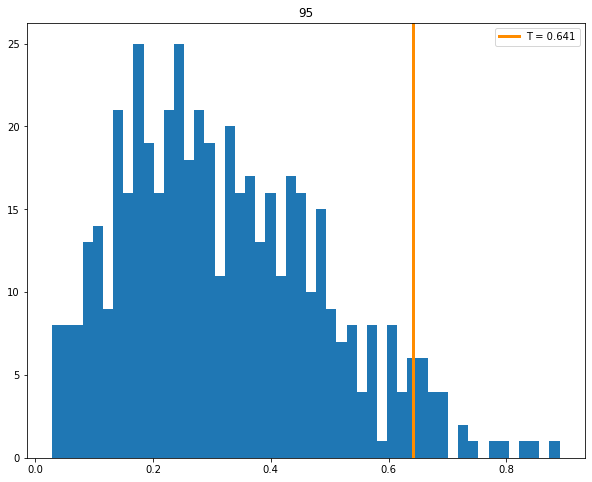

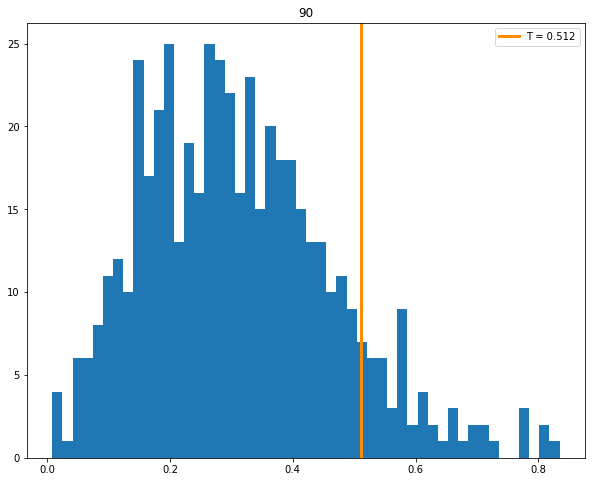

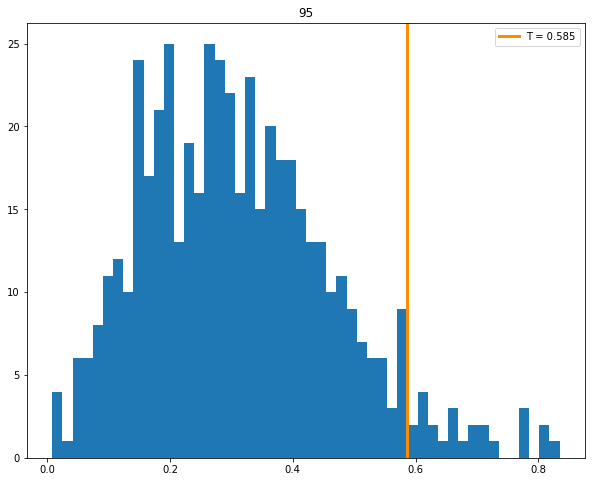

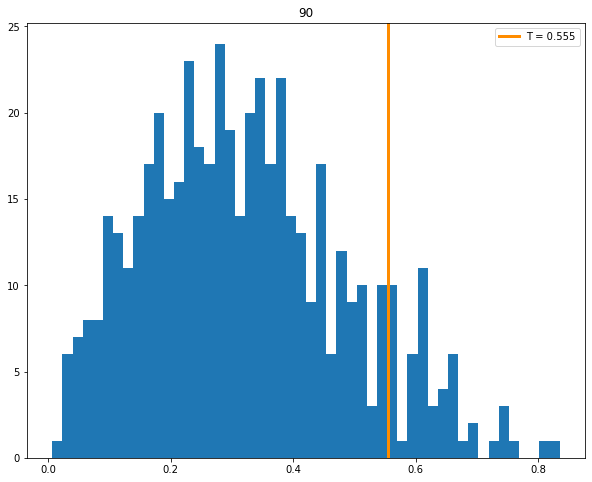

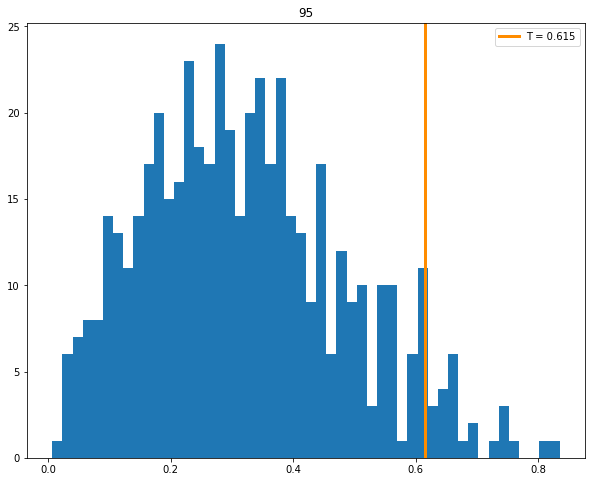

N =  550


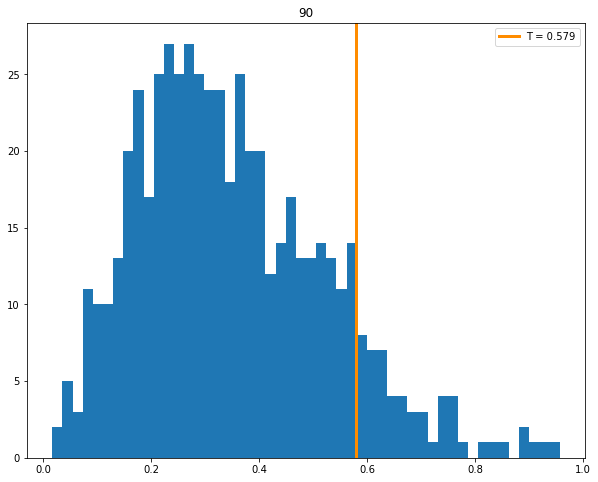

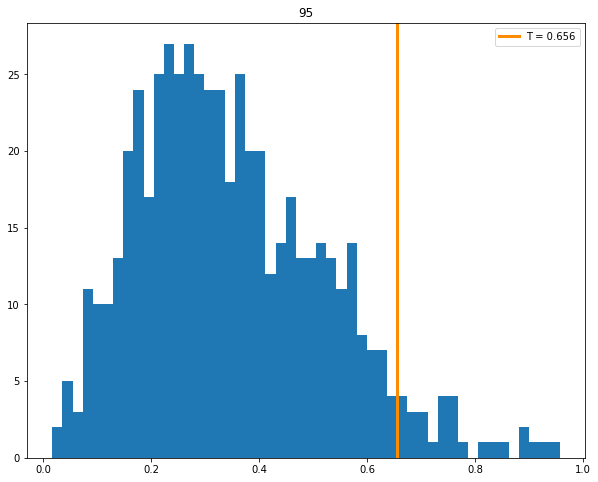

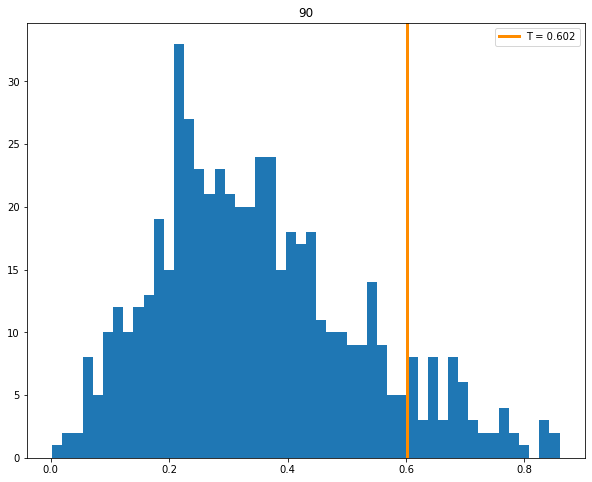

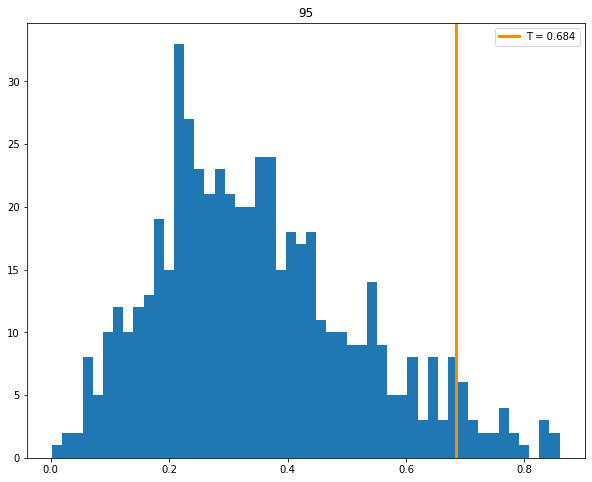

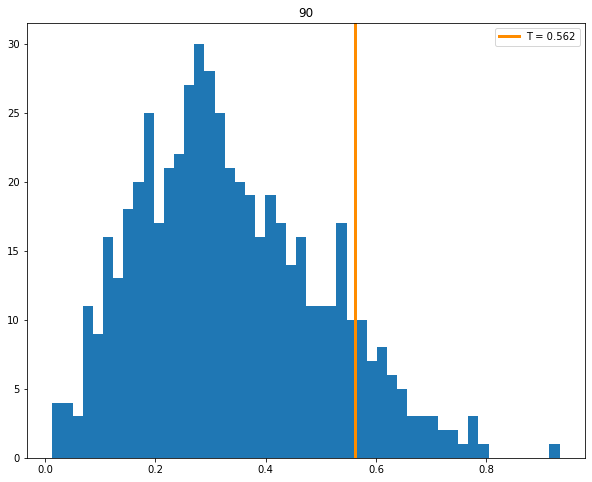

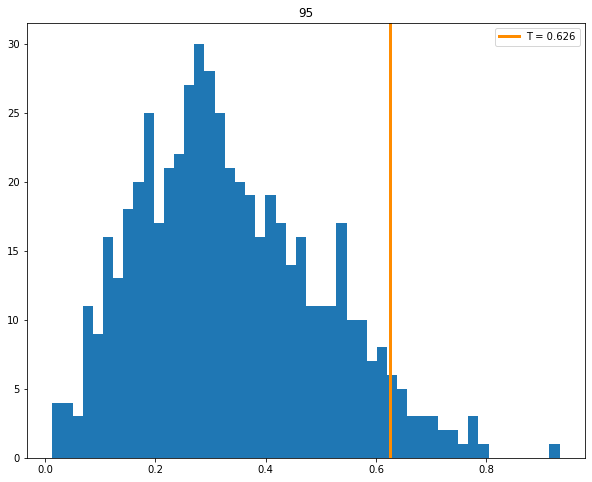

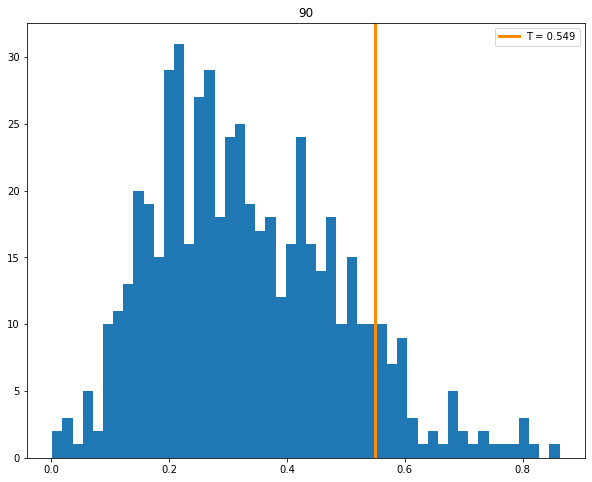

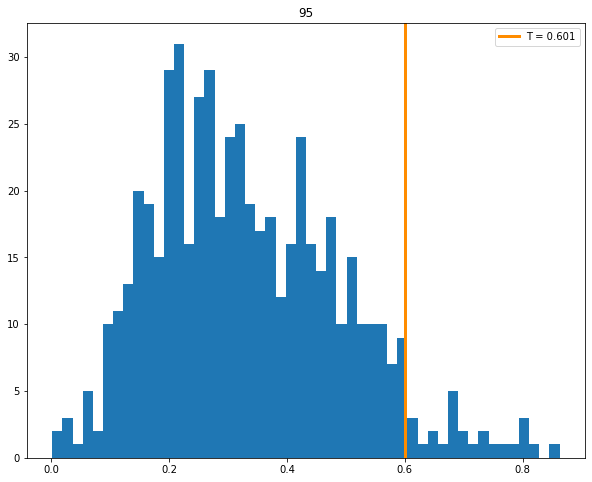

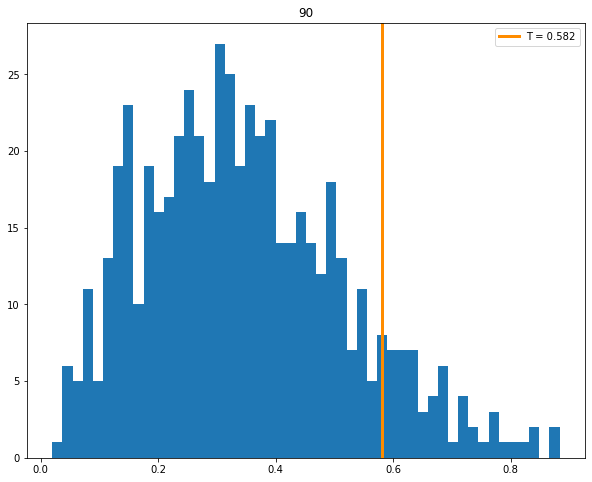

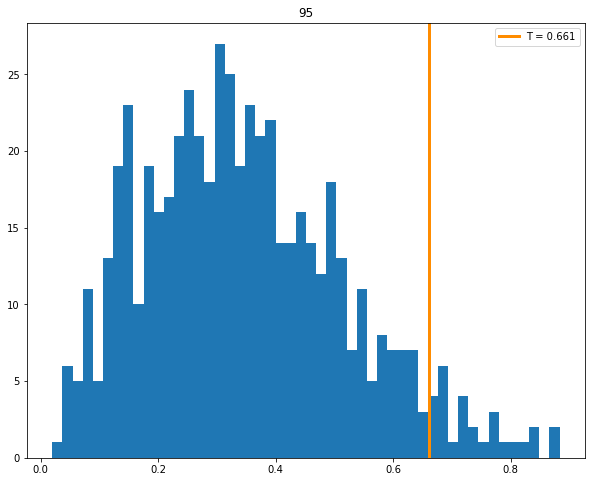

N =  600


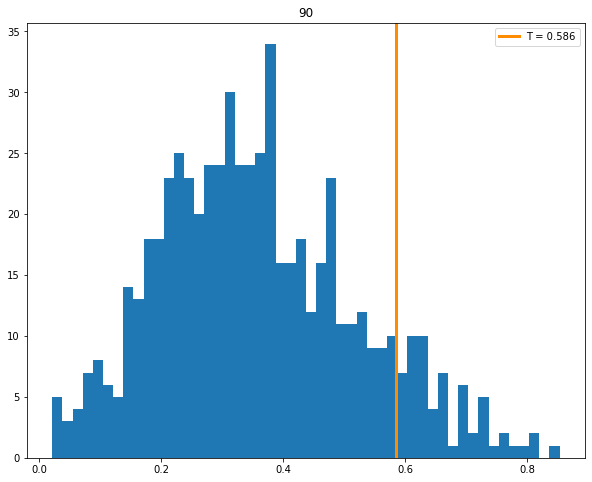

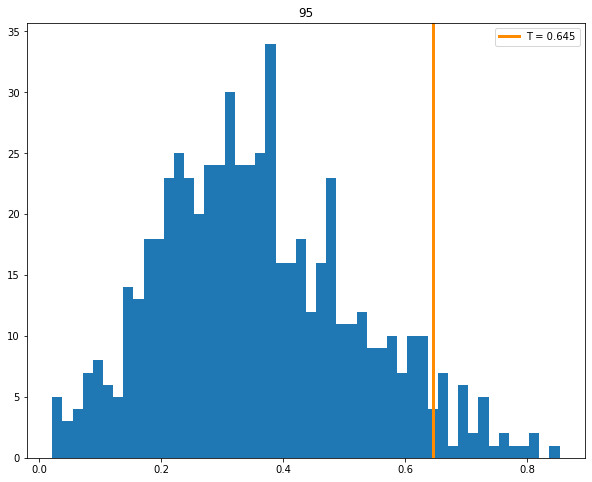

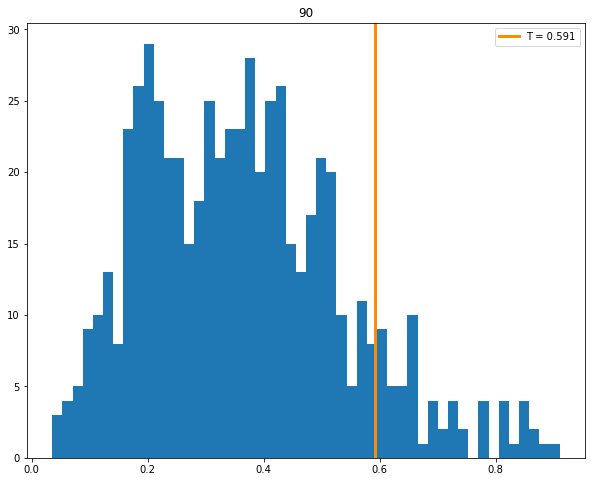

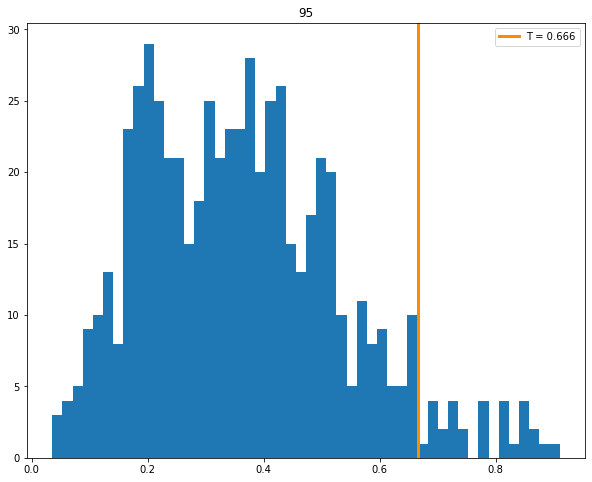

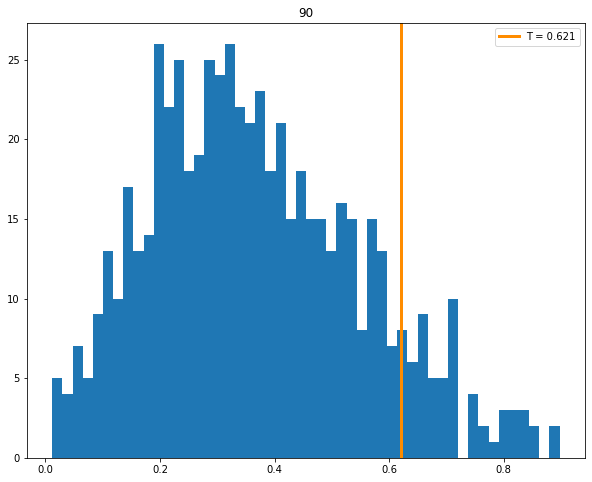

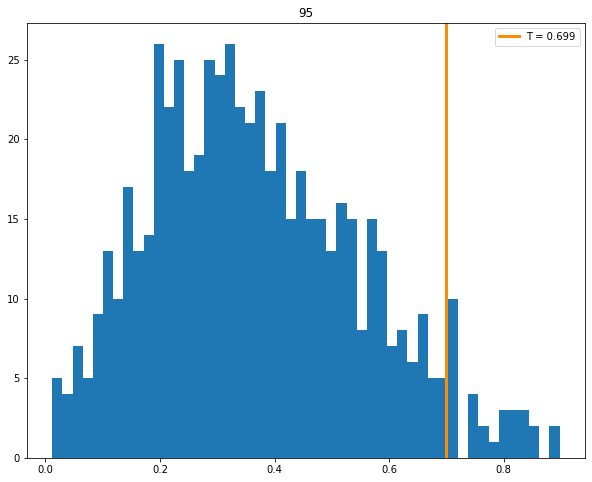

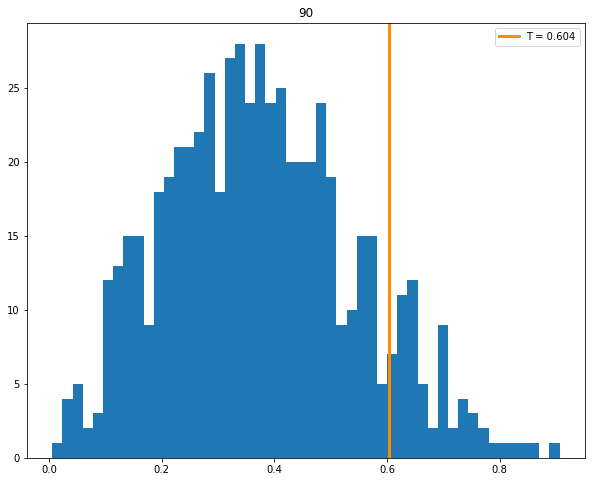

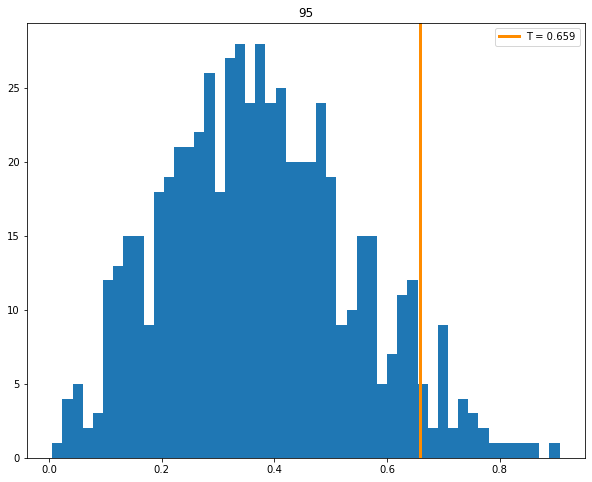

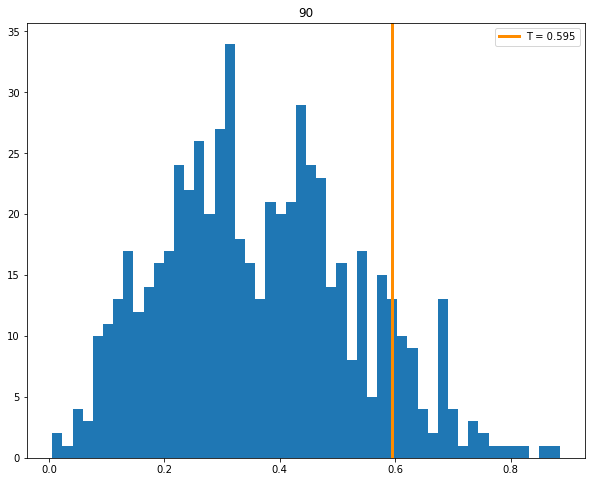

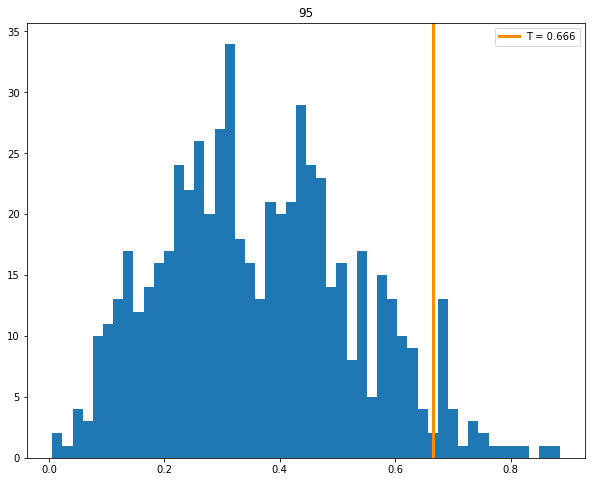

N =  650


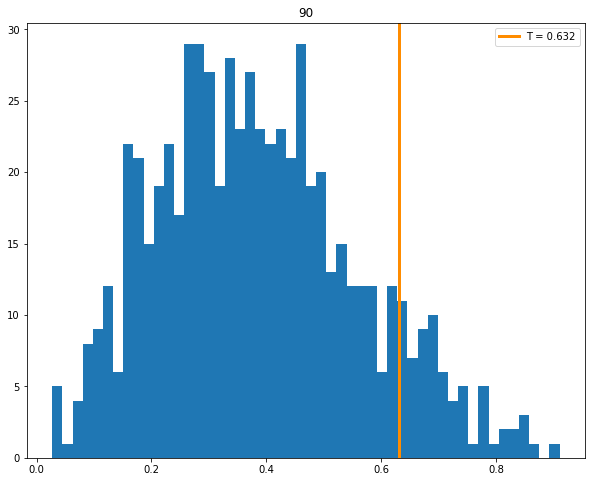

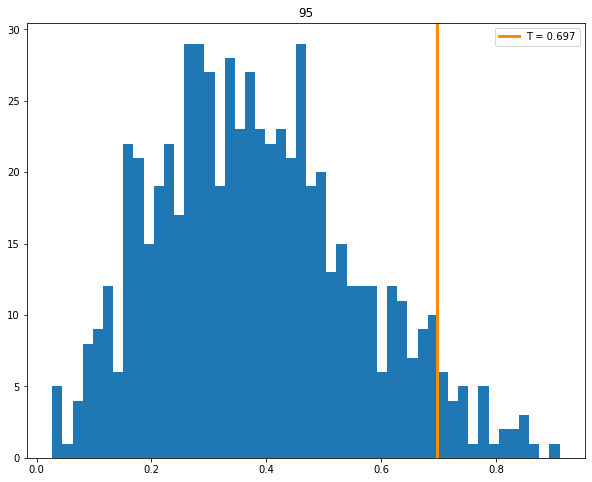

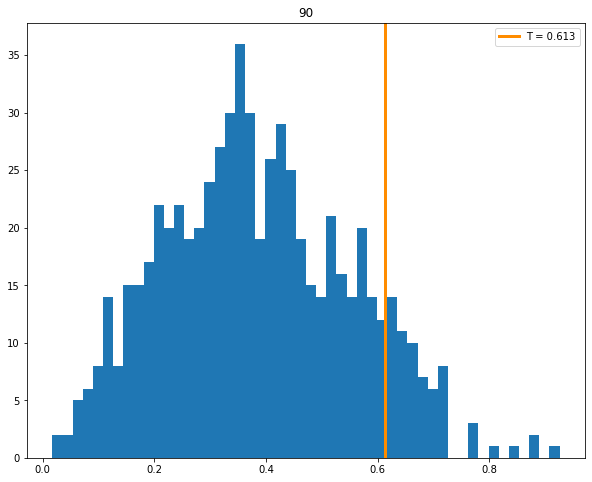

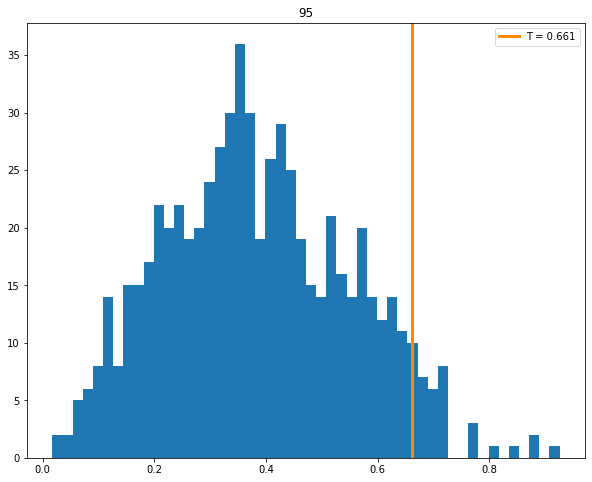

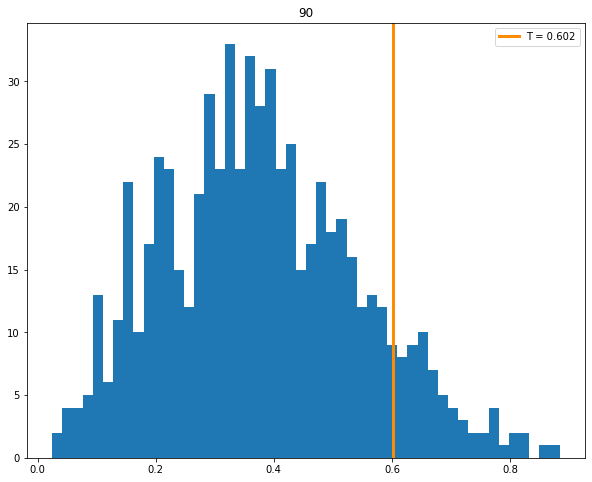

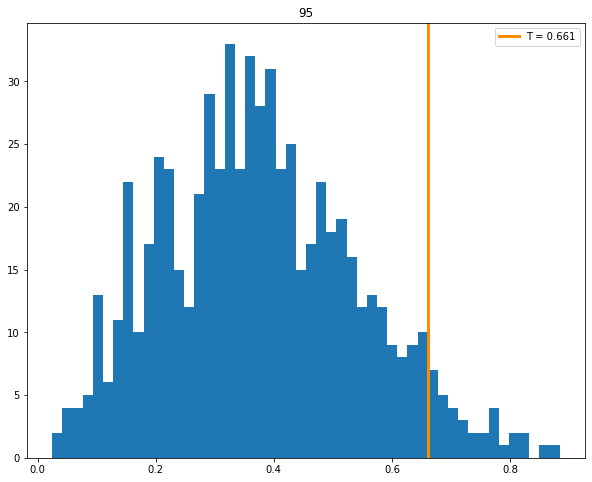

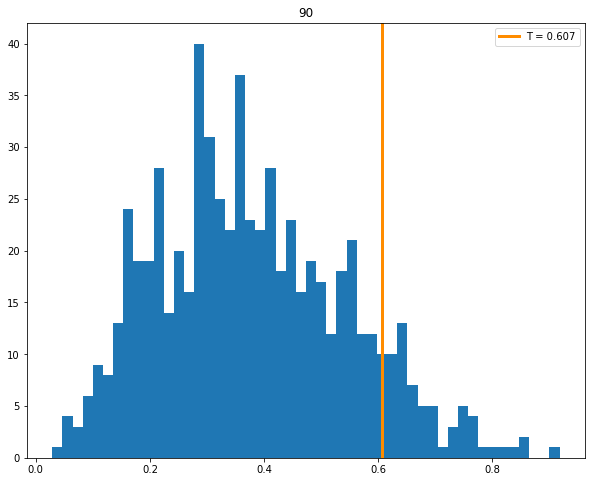

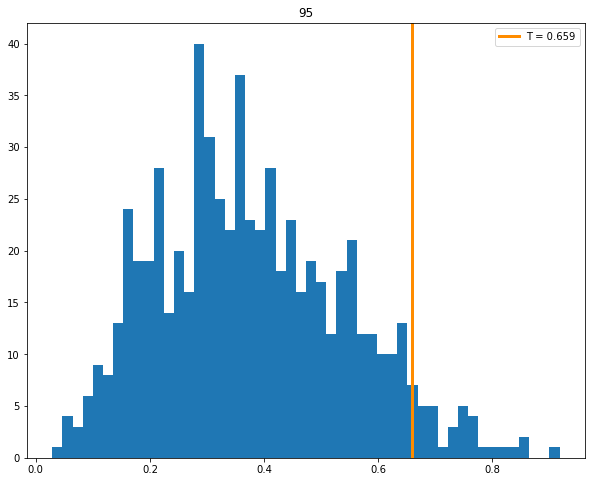

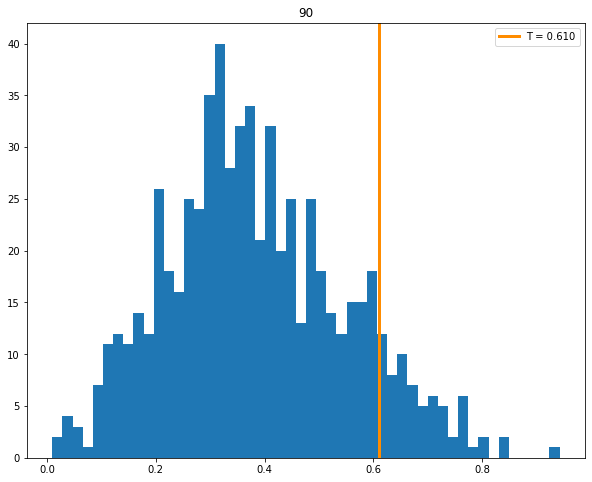

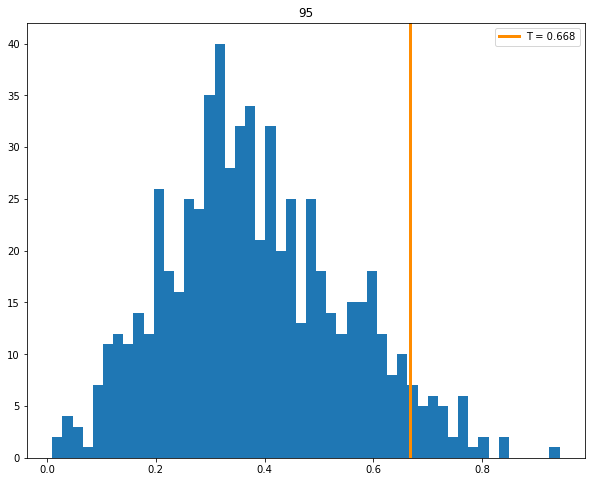

100
N =  300


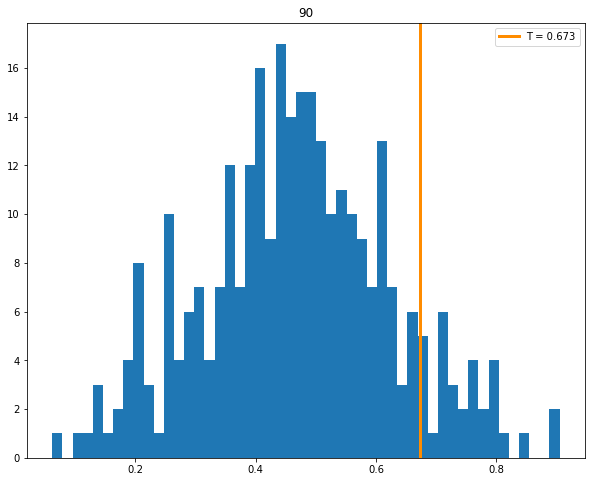

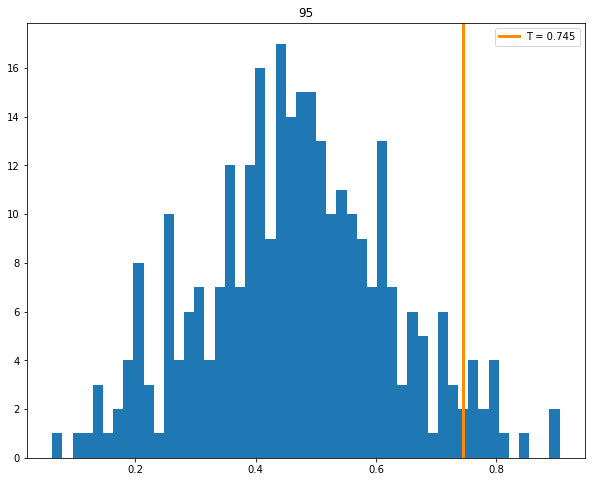

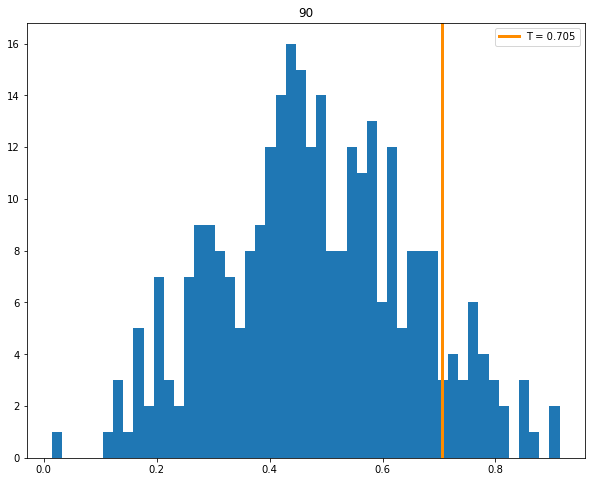

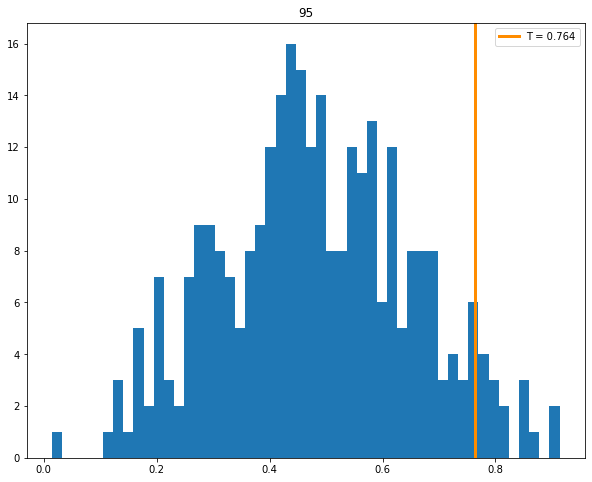

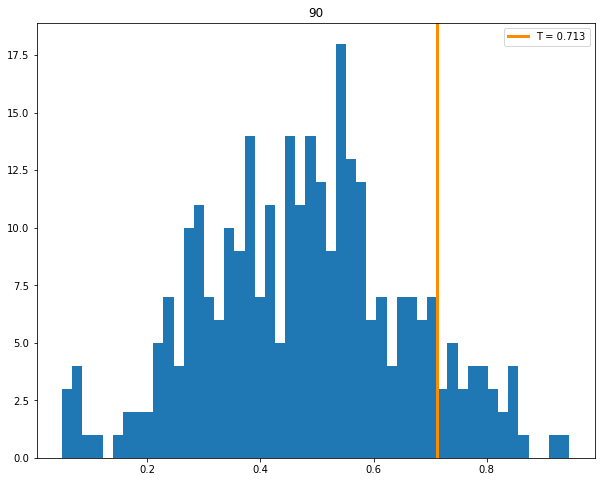

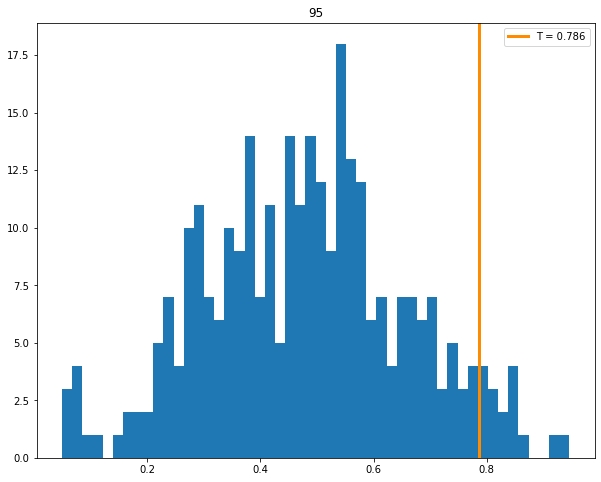

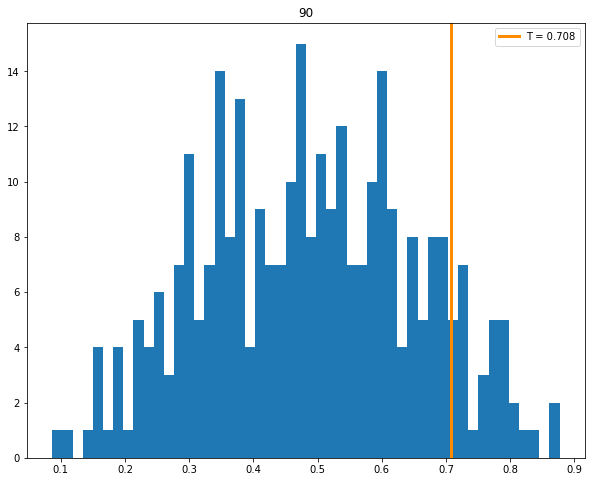

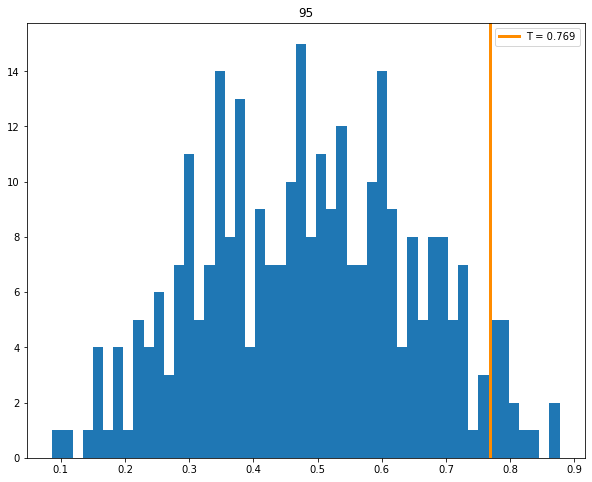

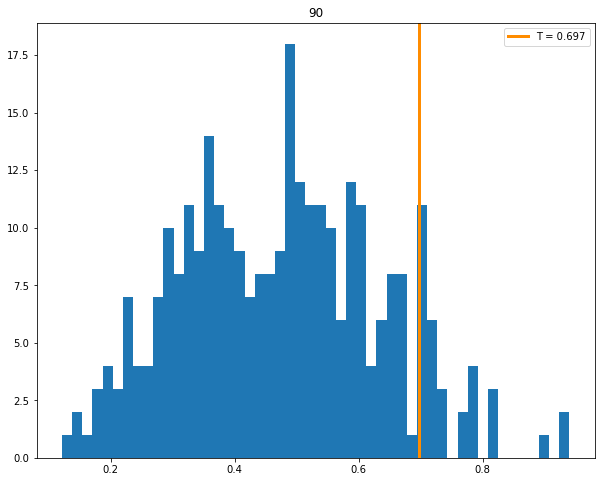

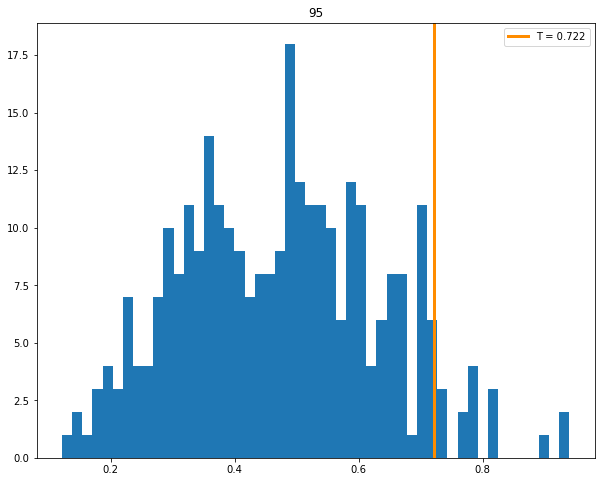

N =  350


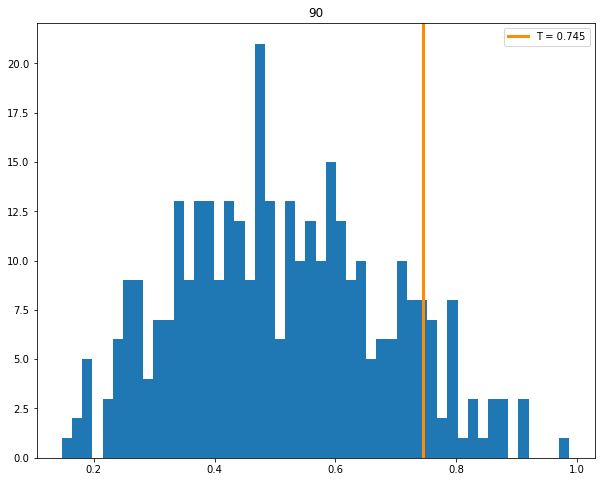

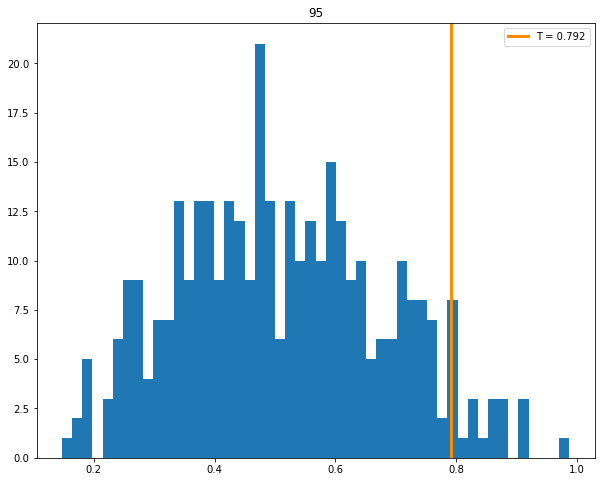

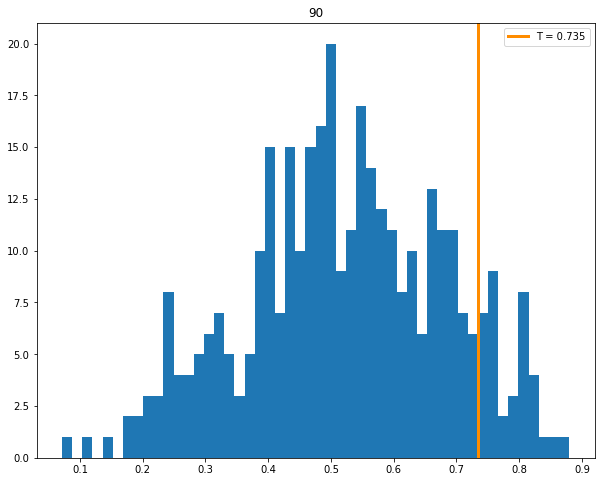

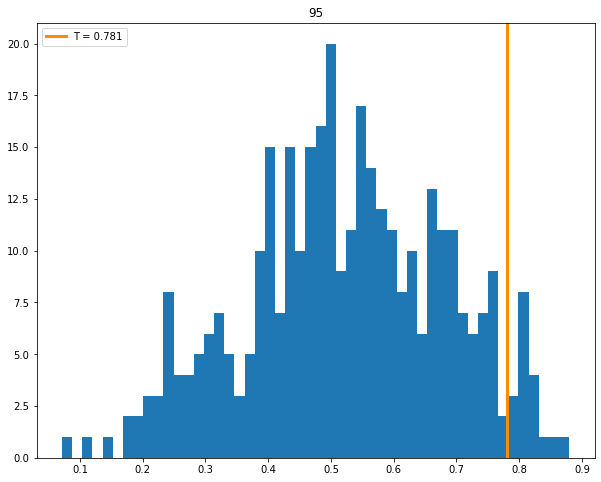

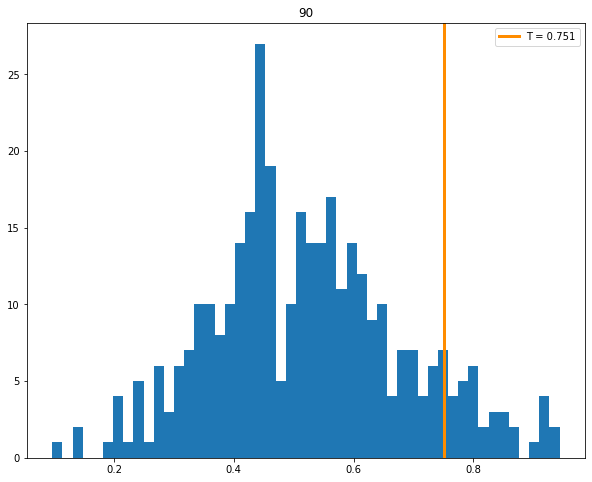

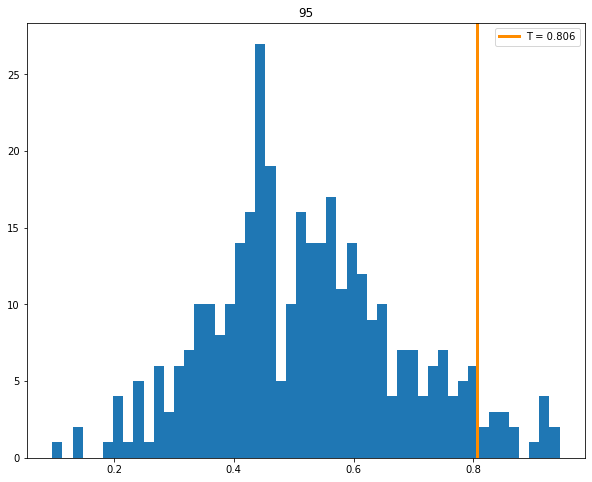

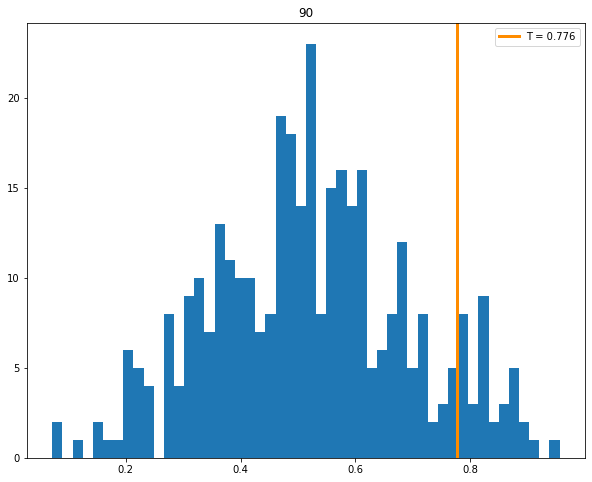

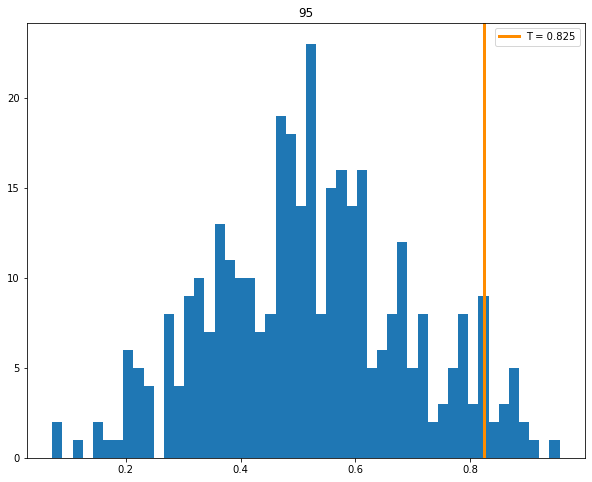

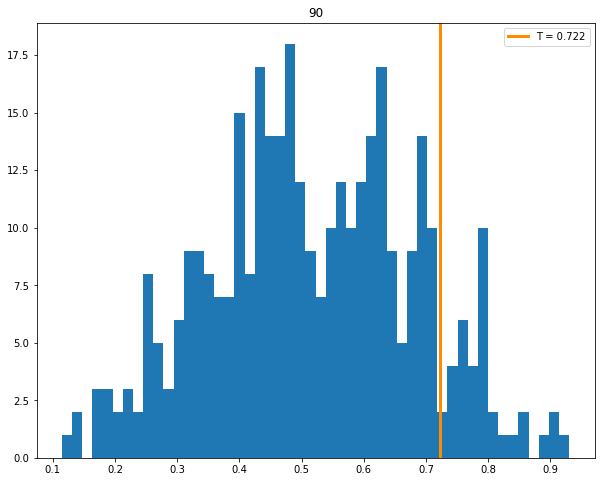

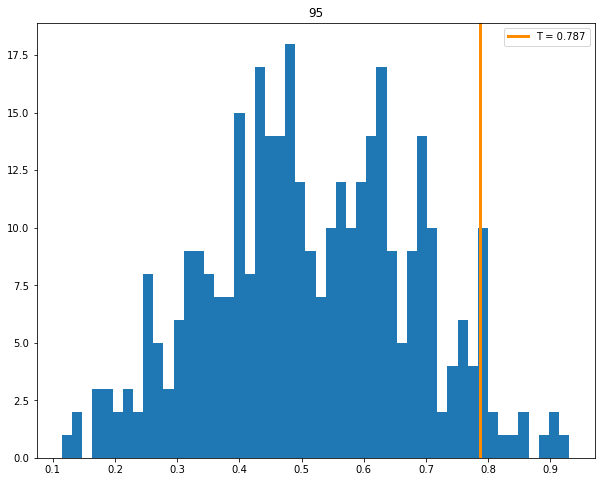

N =  400


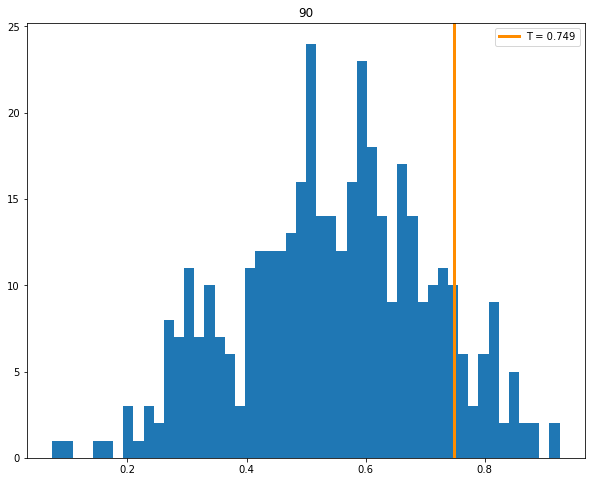

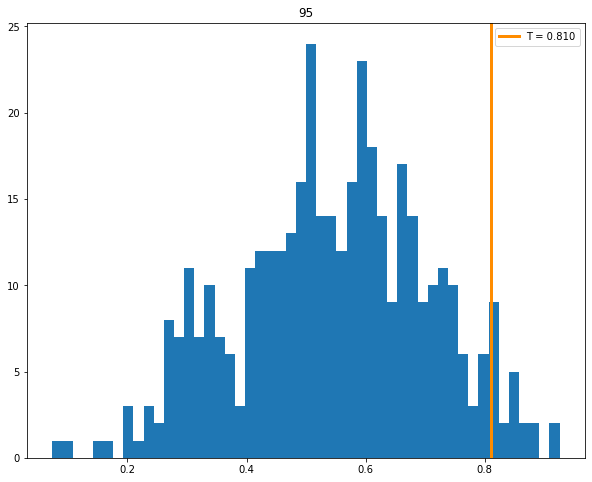

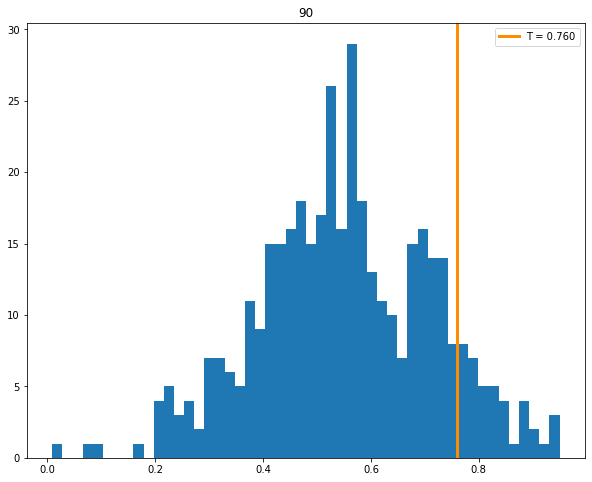

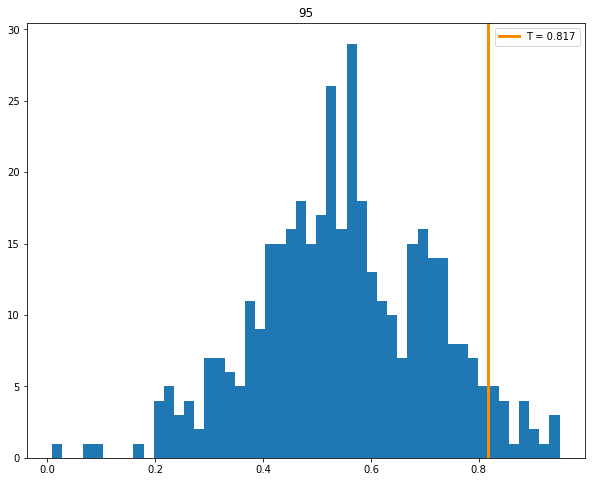

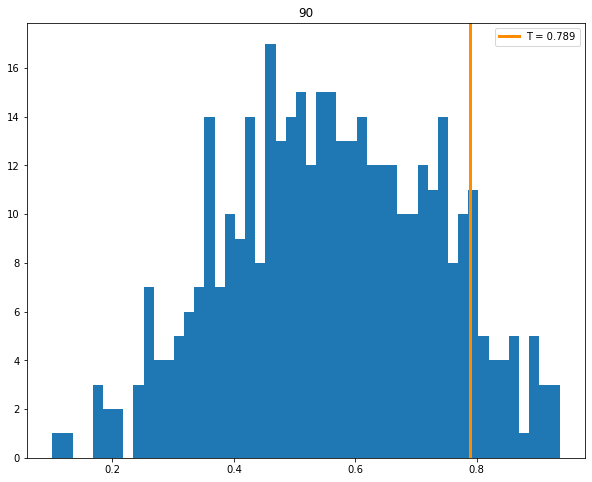

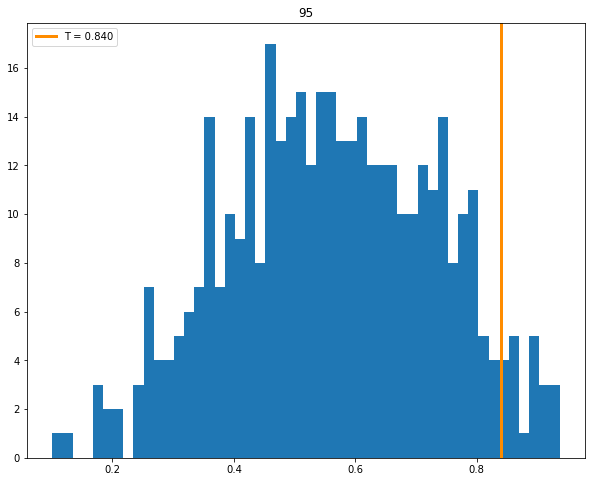

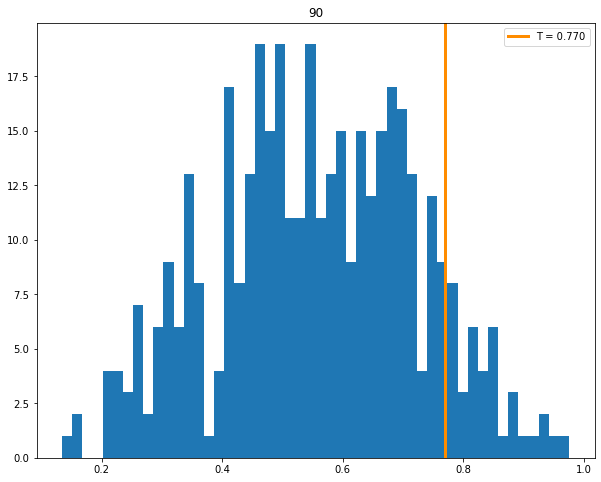

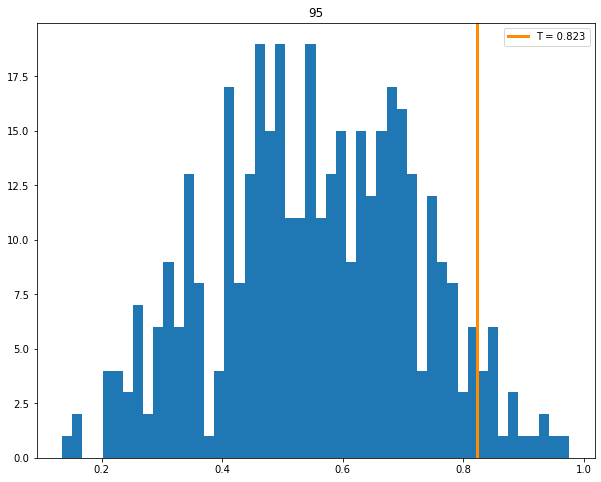

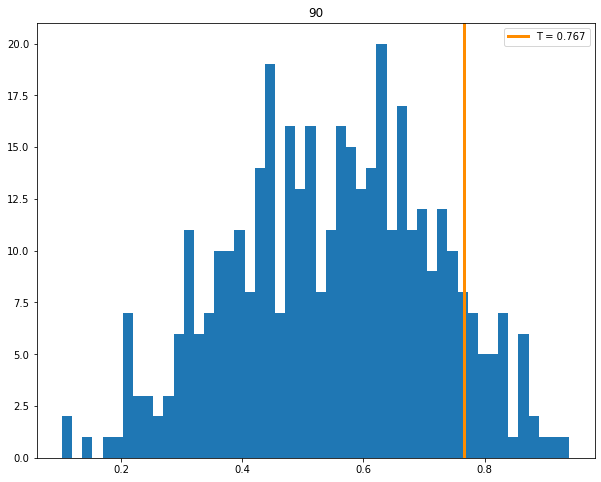

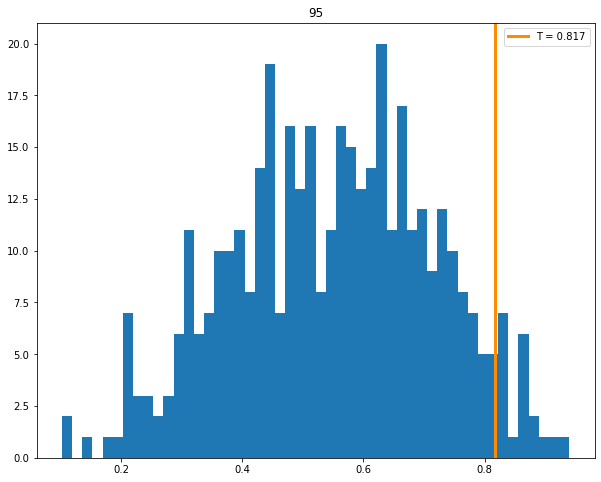

N =  450


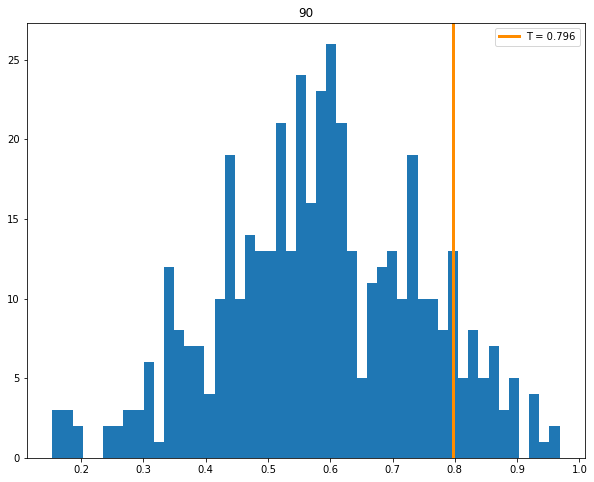

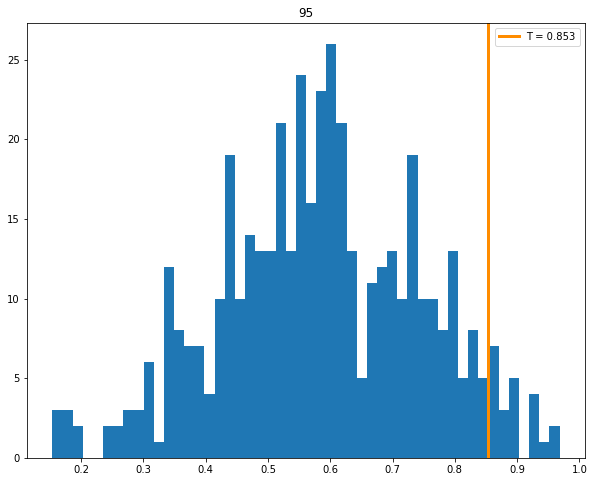

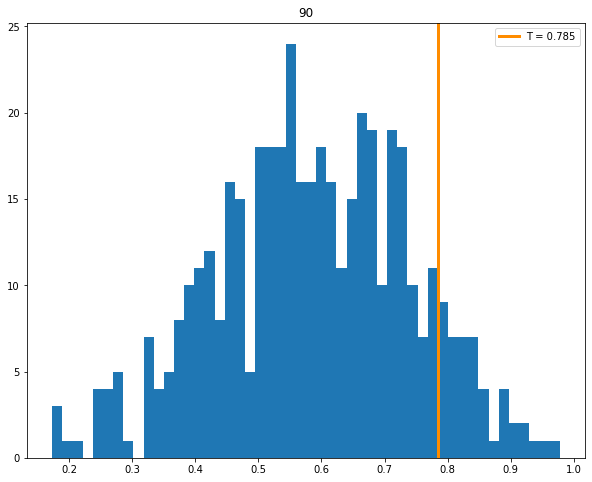

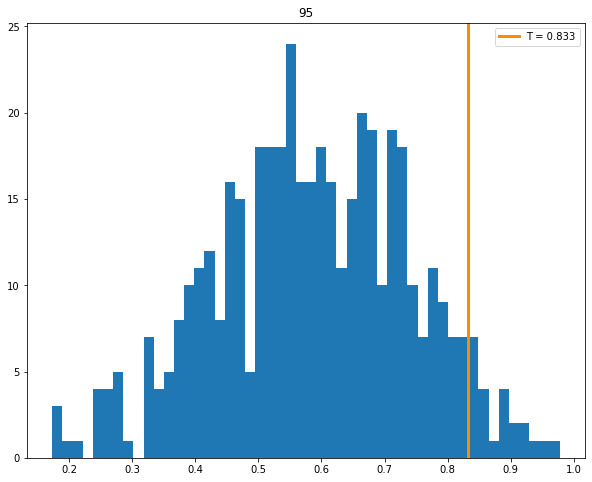

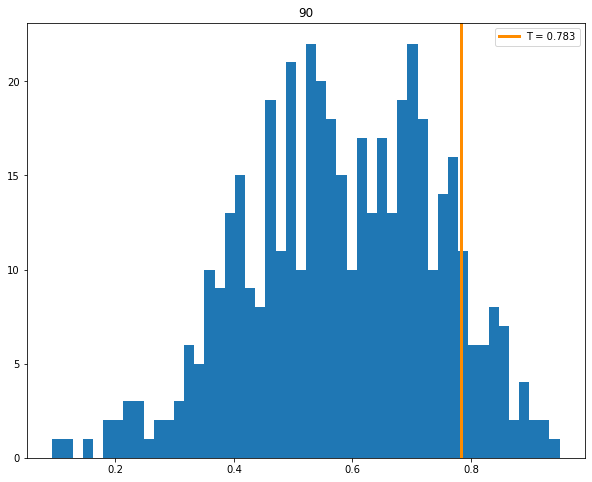

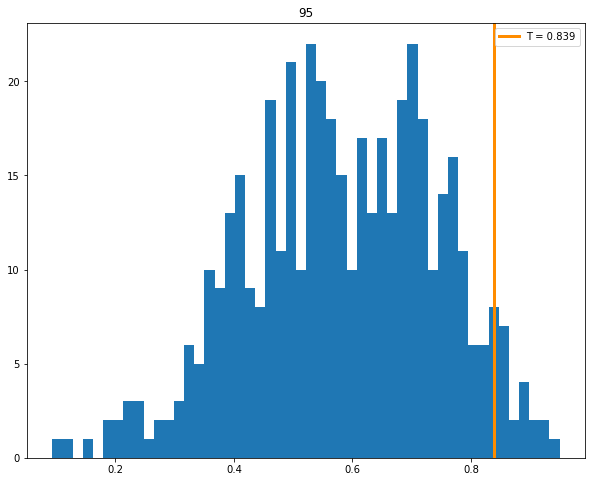

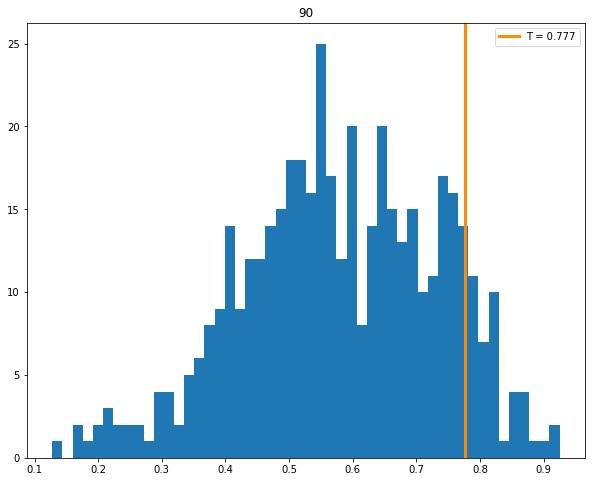

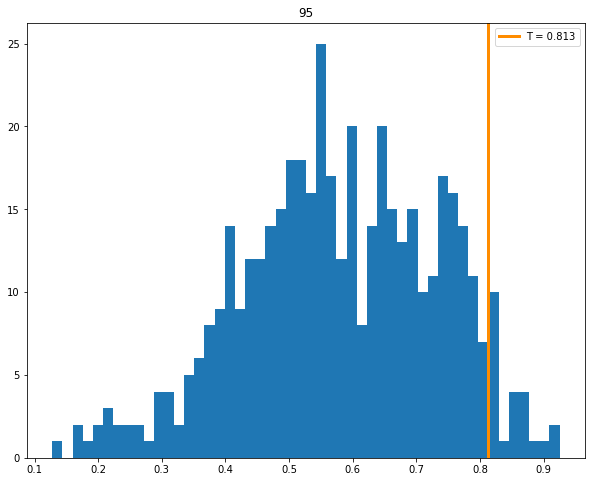

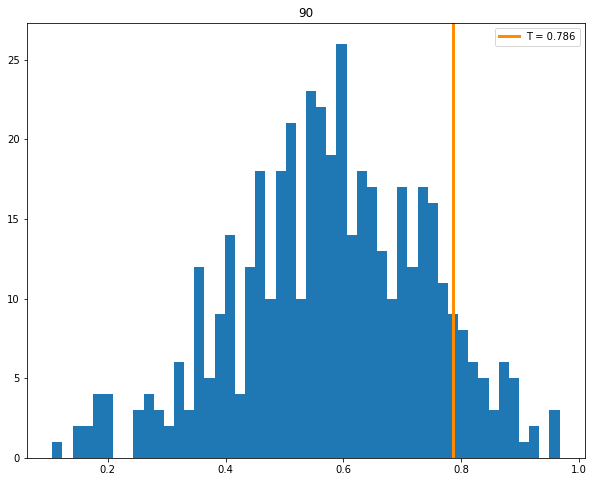

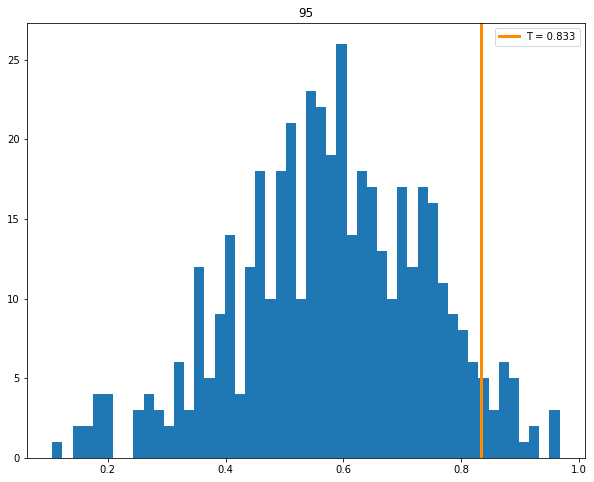

N =  500


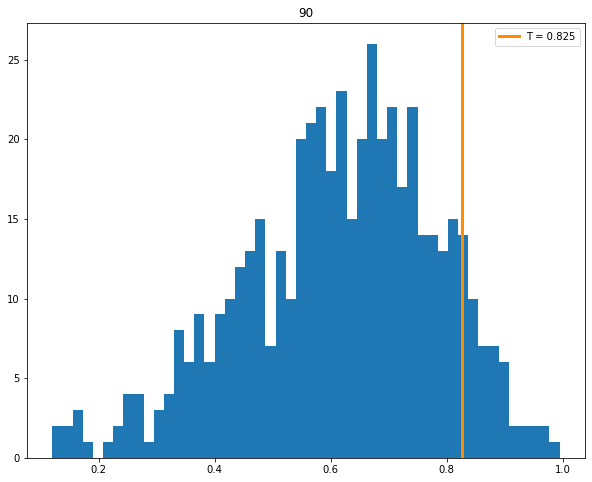

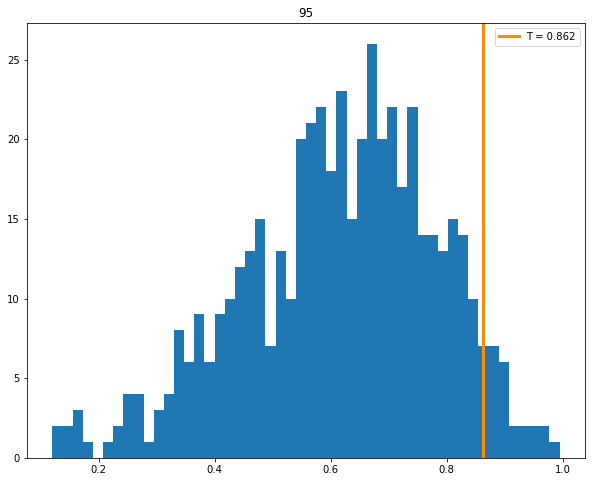

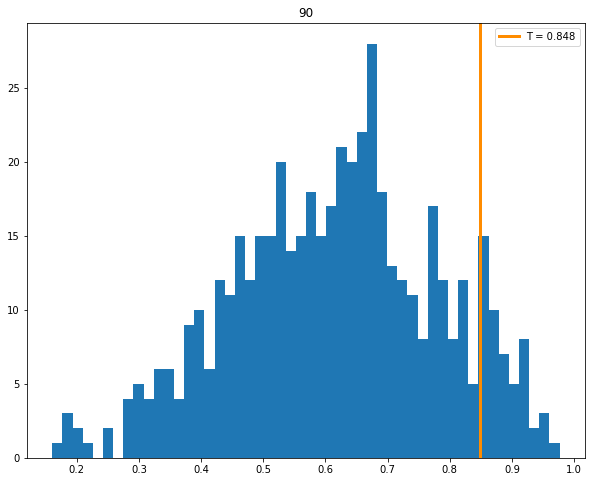

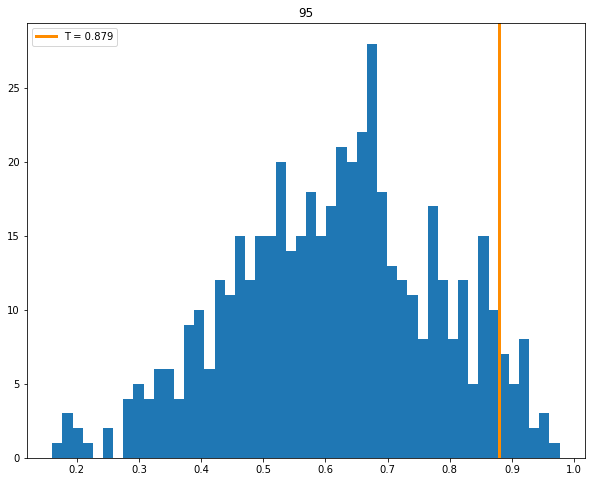

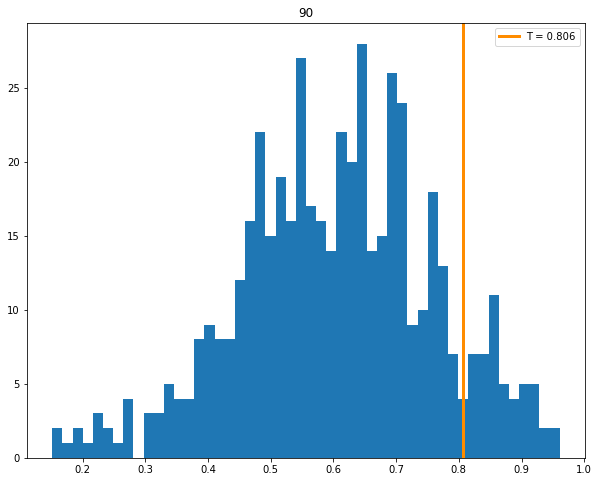

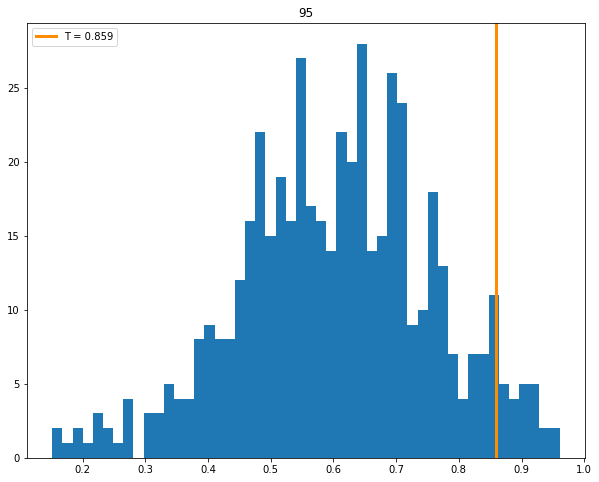

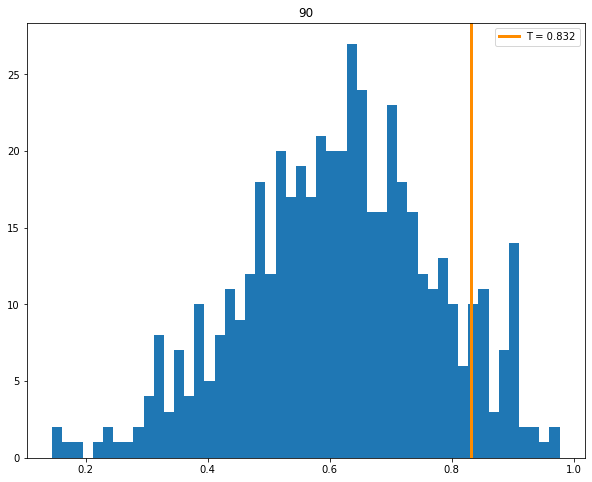

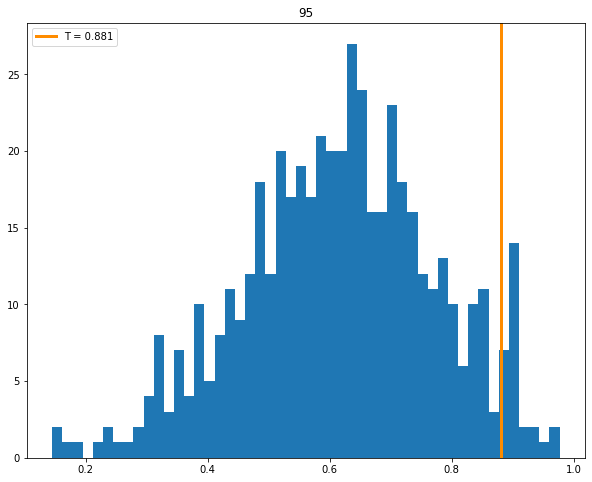

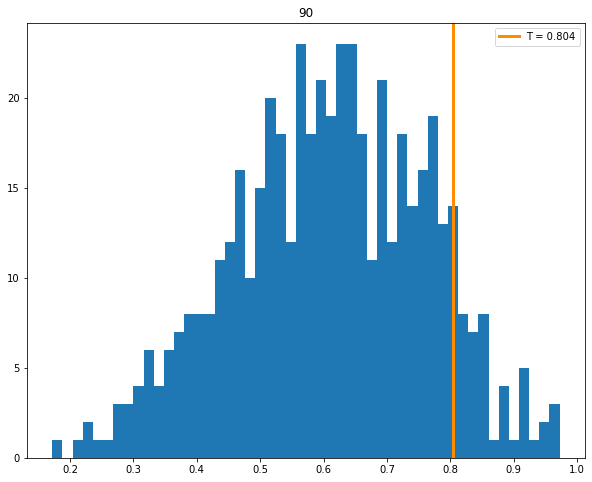

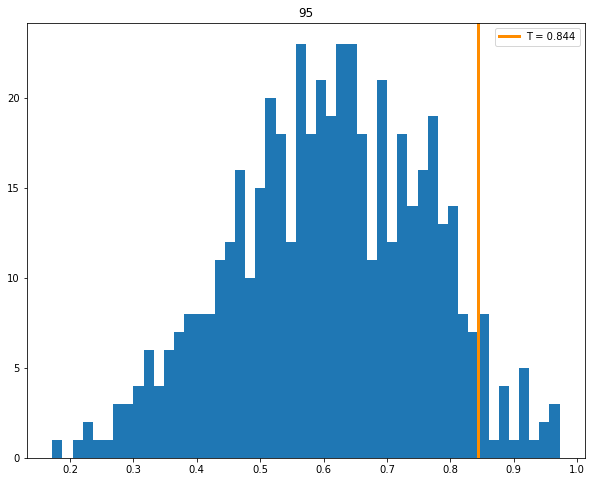

N =  550


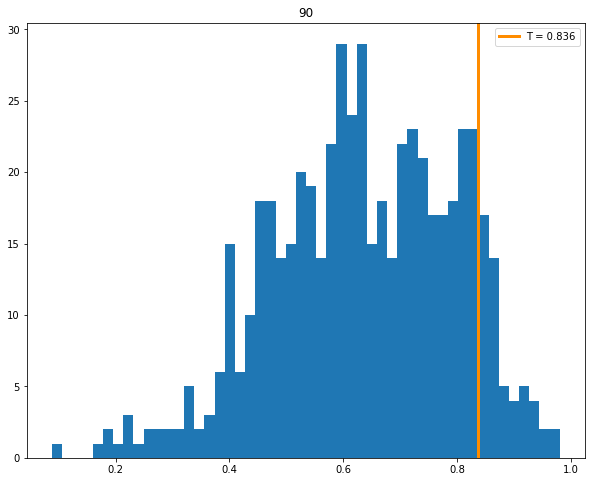

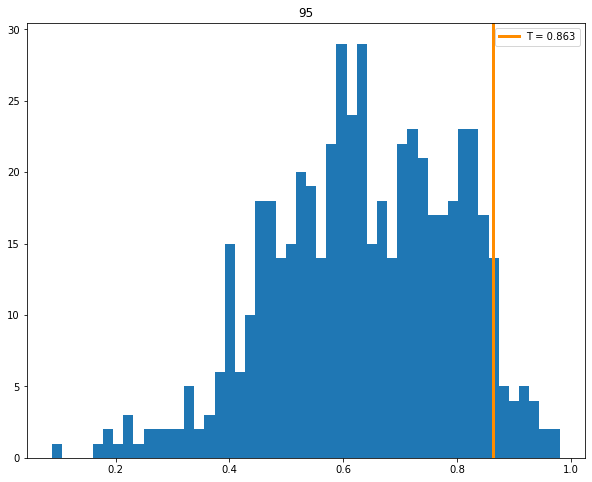

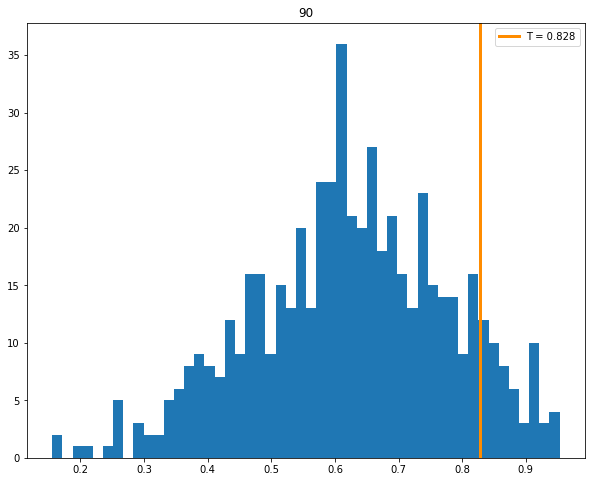

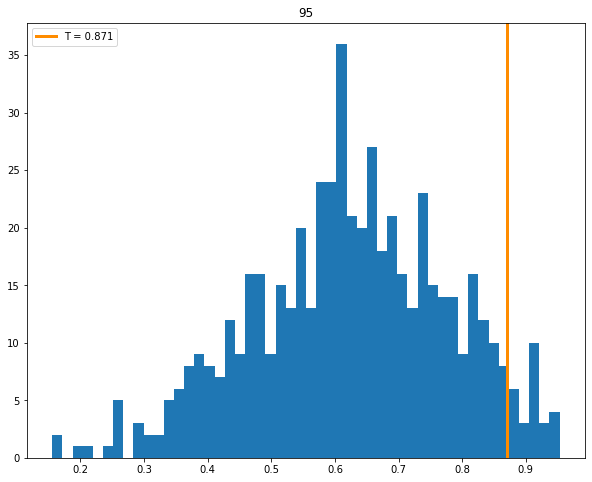

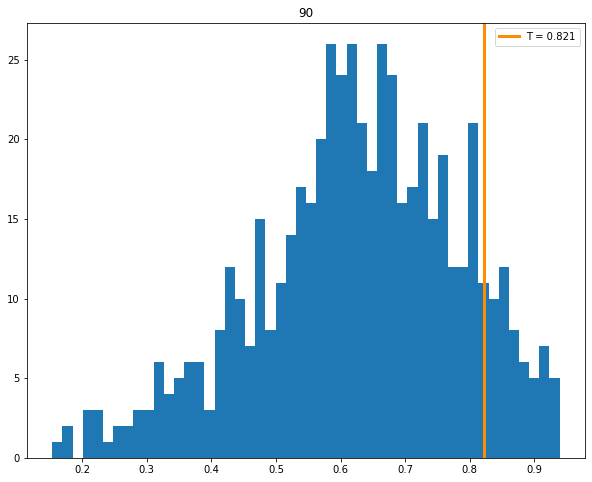

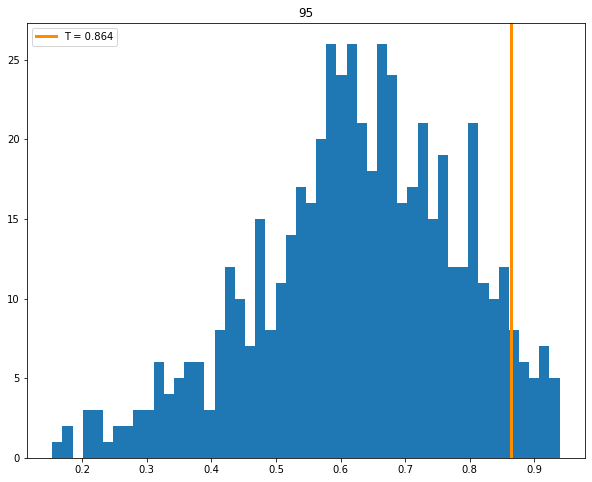

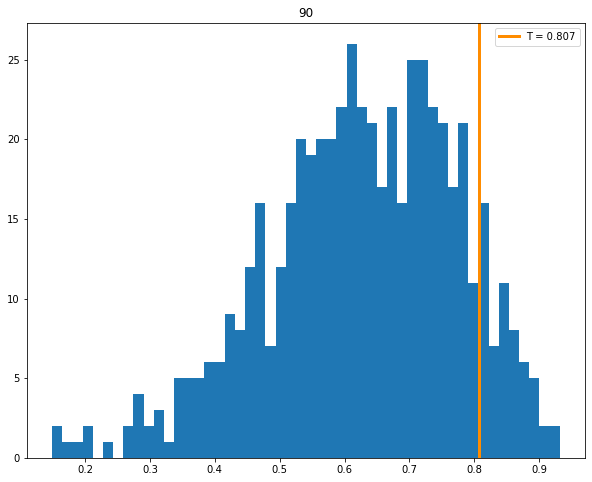

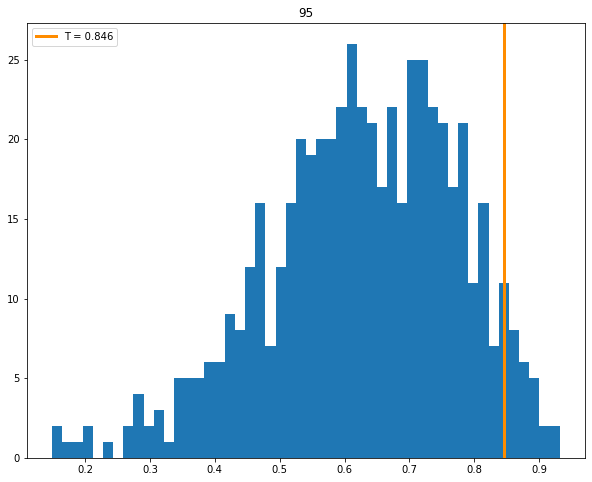

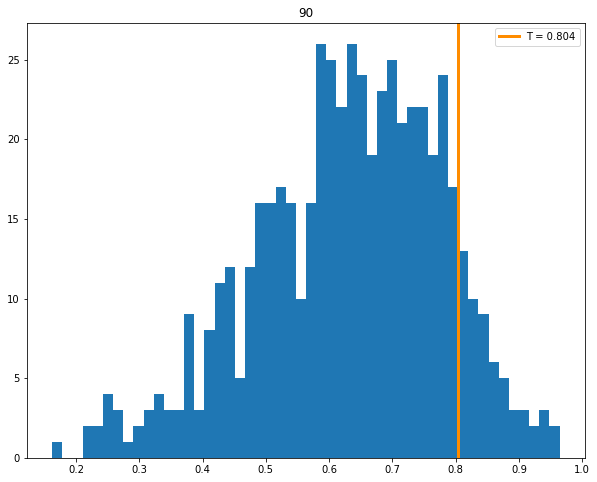

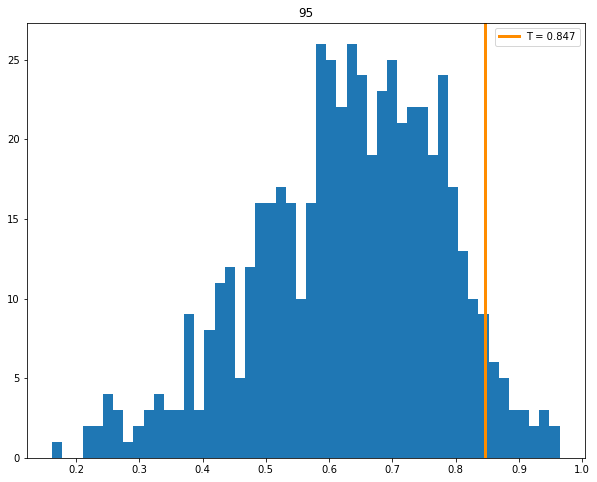

N =  600


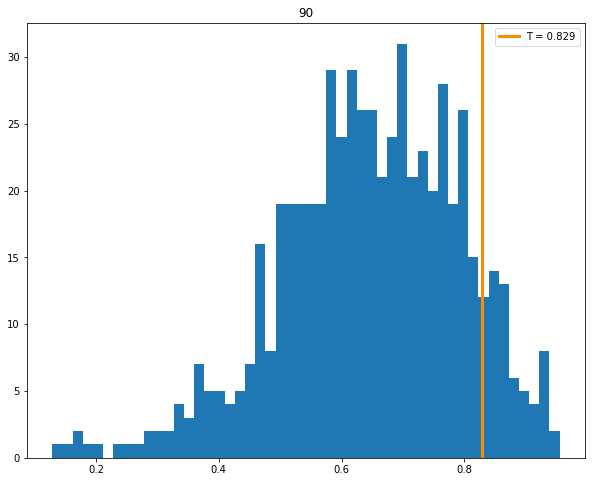

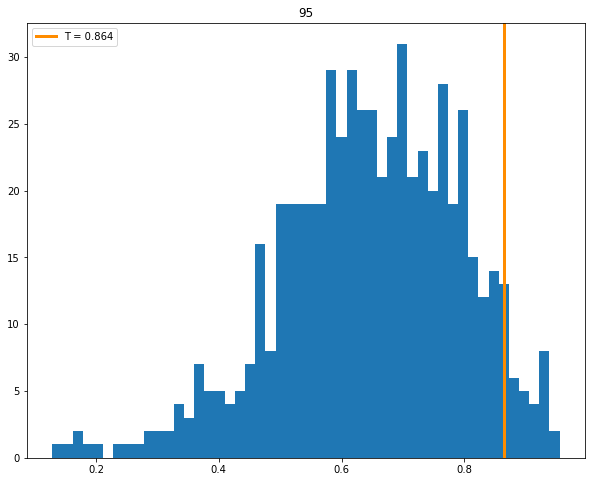

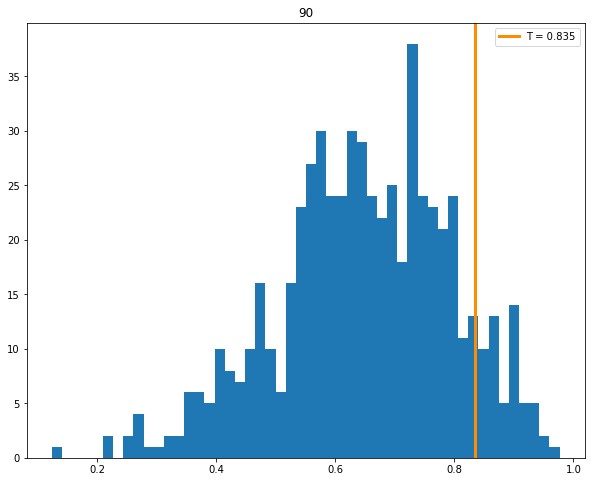

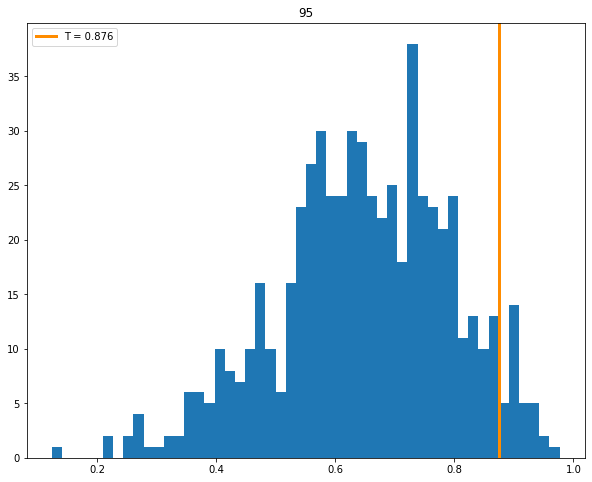

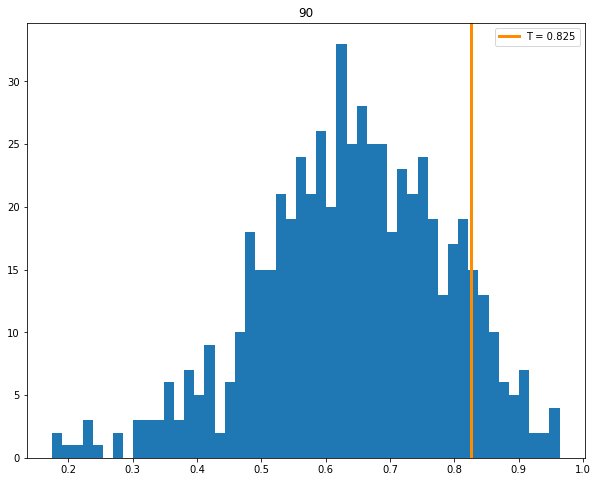

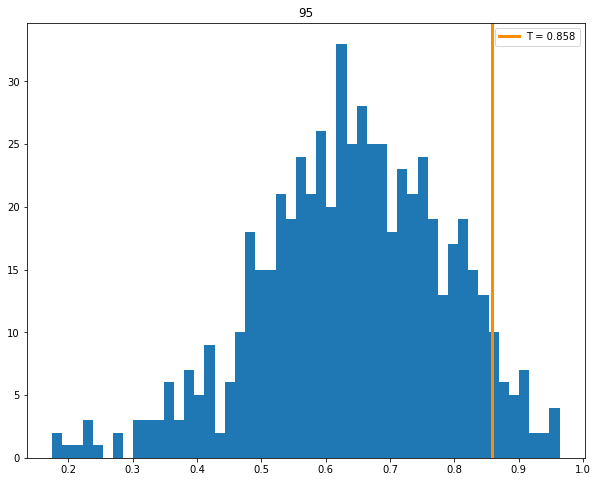

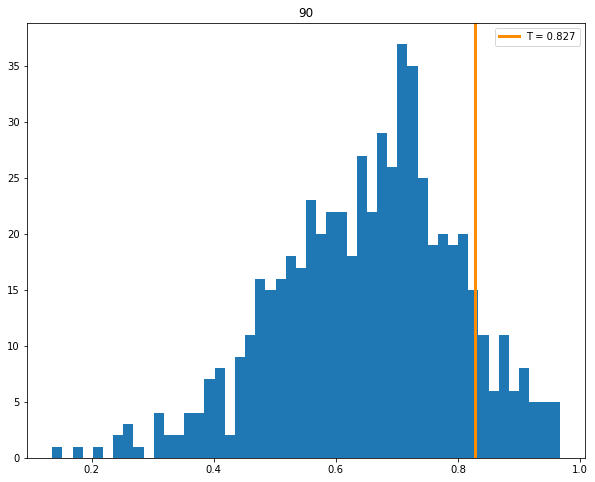

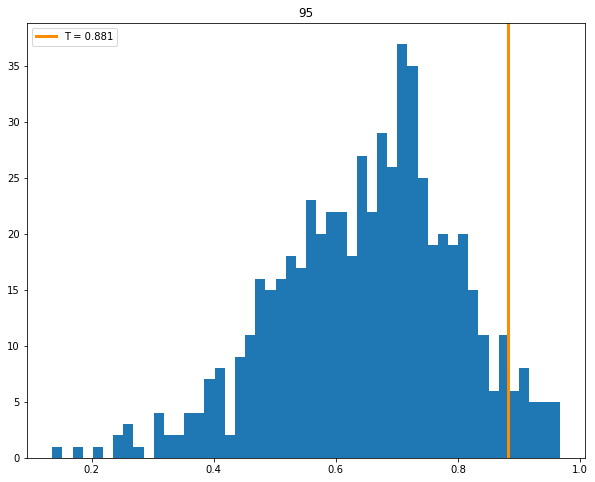

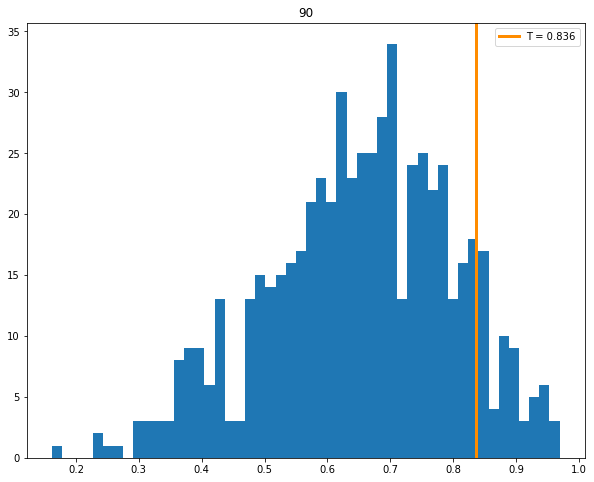

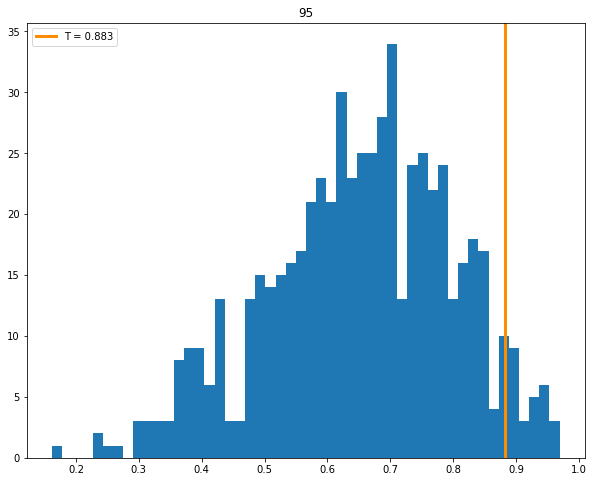

N =  650


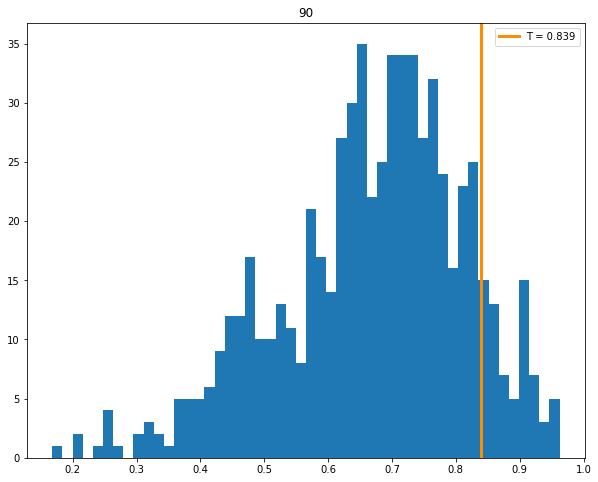

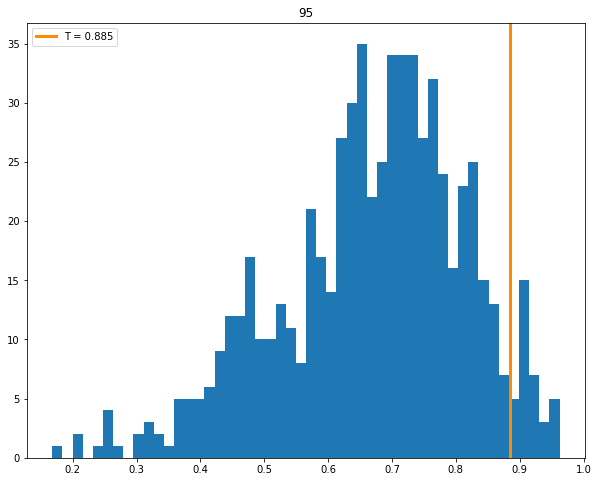

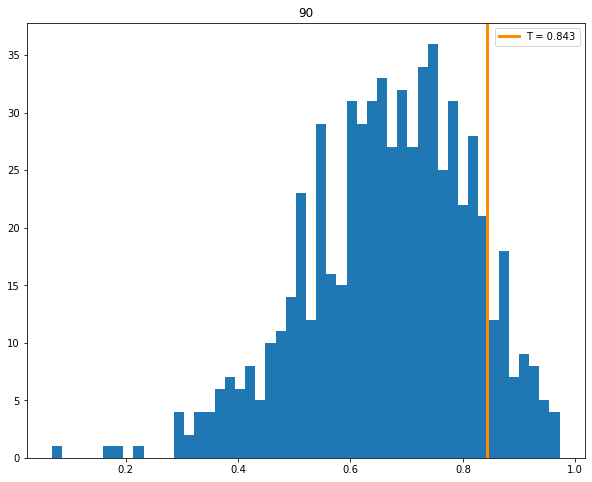

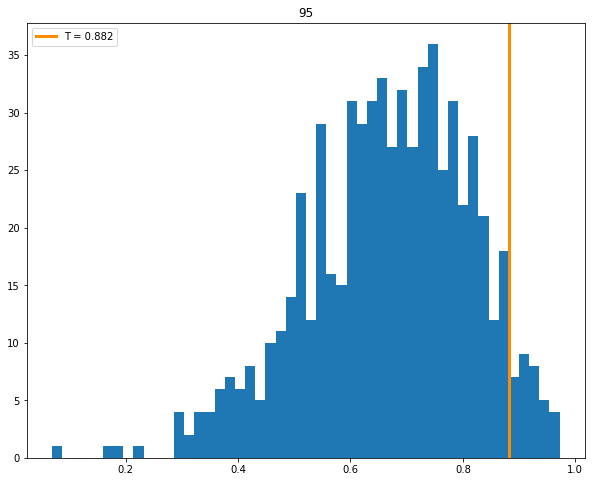

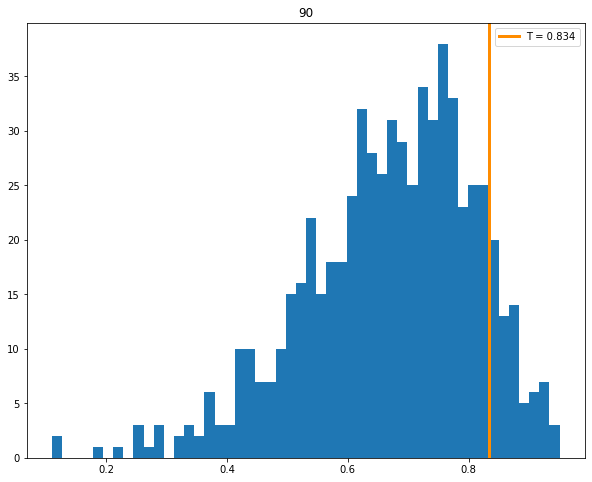

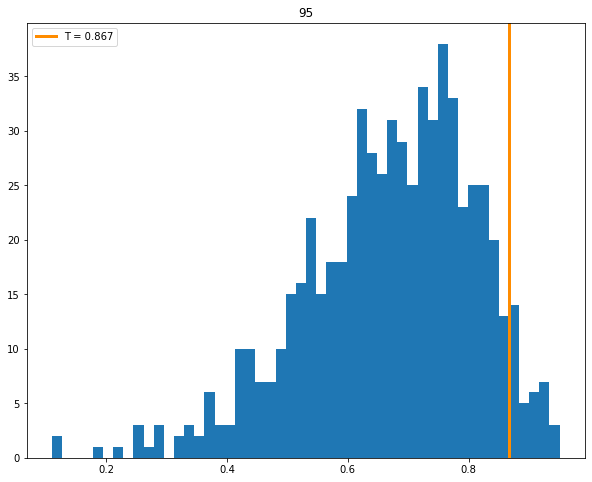

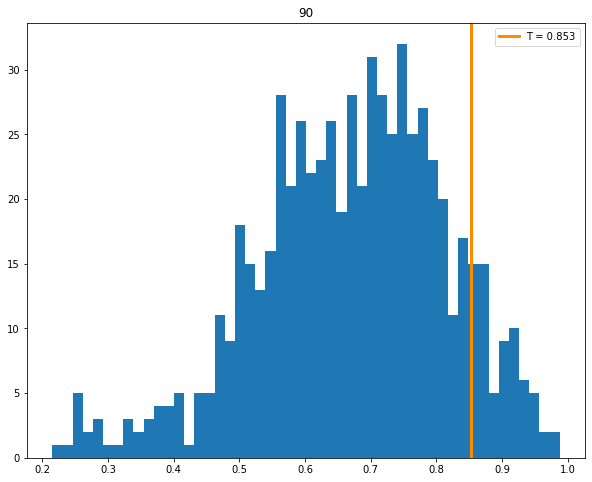

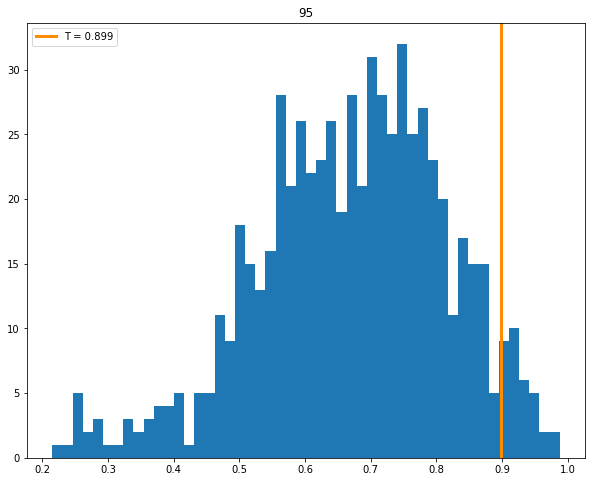

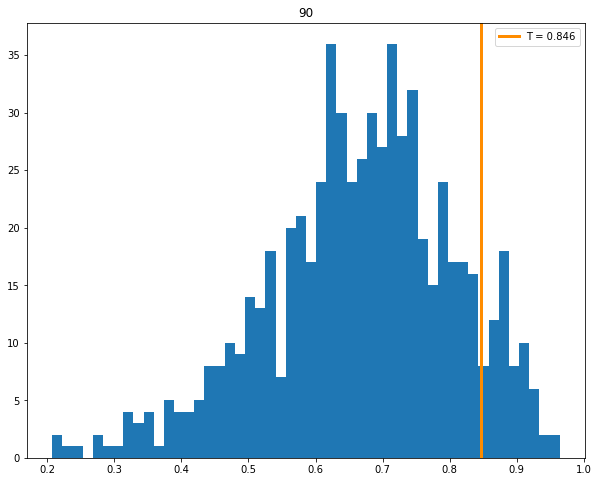

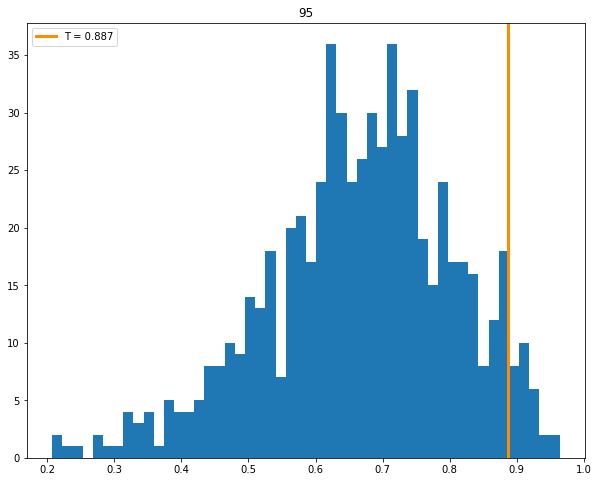

In [116]:
Sigma_s_s = [10, 55, 100]
Ns = np.arange(300, 651, 50).tolist()


all_T_av90 = []
all_T_av95 = []

for sigma_s in Sigma_s_s:
    print(sigma_s)
    T_N_av90 = []
    T_N_av95 = []
    for N in Ns:
        print('N = ', N)
        T90s = []
        T95s = []
        for i in range(5):
            T_90, T_95 = compute_T_90_95(N, sigma_s, x_lim = [0,2], y_lim = [0,2])
            T90s.append(T_90)
            T95s.append(T_95)
        T90s, T95s    = np.asarray(T90s), np.asarray(T95s)
        T_avg90 = np.mean(T90s)
        T_avg95 = np.mean(T95s)


        T_N_av90.append(T_avg90)
        T_N_av95.append(T_avg95)
        
    all_T_av90.append(T_N_av90)
    all_T_av95.append(T_N_av95)

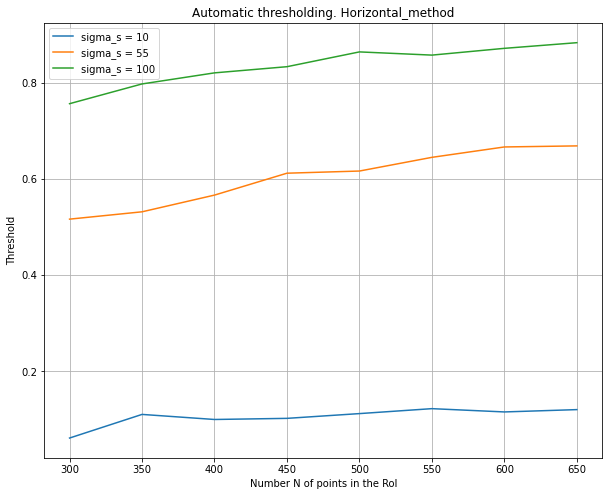

In [118]:
labels = ['sigma_s = ' + str(s) for s in Sigma_s_s]

x = Ns
plt.figure(figsize = (10,8))
for i, av in enumerate(all_T_av95):
    av = np.asarray(av)
    plt.plot(x,av, label = labels[i])

plt.title('Automatic thresholding. Horizontal_method')
plt.xlabel('Number N of points in the RoI')
plt.ylabel('Threshold')
plt.legend()
plt.grid()
plt.show()

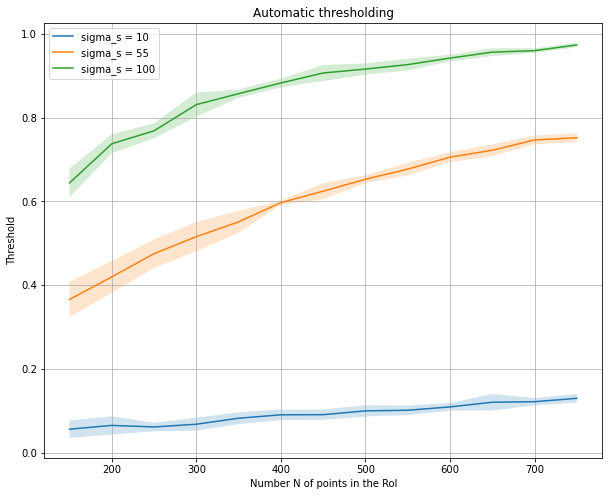

In [11]:

labels = ['sigma_s = ' + str(s) for s in Sigma_s_s]

x = Ns
plt.figure(figsize = (10,8))
for i, av in enumerate(all_T_av):
    av = np.asarray(av)
    sd = np.asarray(all_T_sd[i])
    plt.plot(x,av, label = labels[i])
    plt.fill_between(x, (av - sd), (av + sd), alpha=.2)

plt.title('Automatic thresholding')
plt.xlabel('Number N of points in the RoI')
plt.ylabel('Threshold')
plt.legend()
plt.grid()
plt.show()

## Voir la limitation que Manley redoute: 

In [66]:
param = Standard_Param()

param_NoNoise = Standard_Param()
param_NoNoise.NoisePercentage = 0

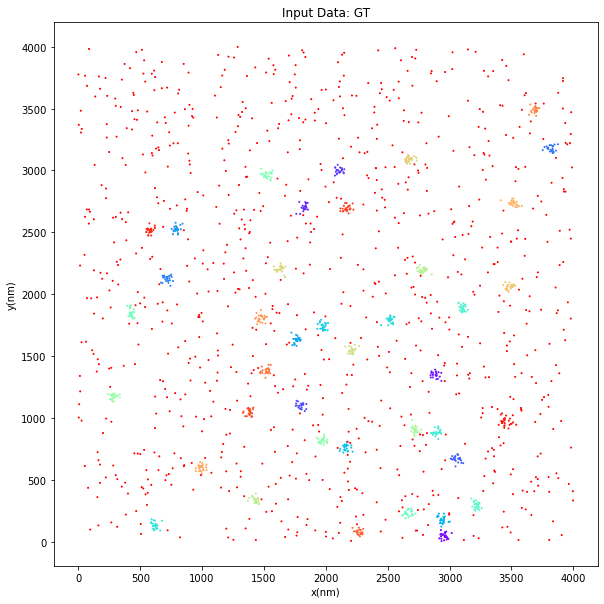

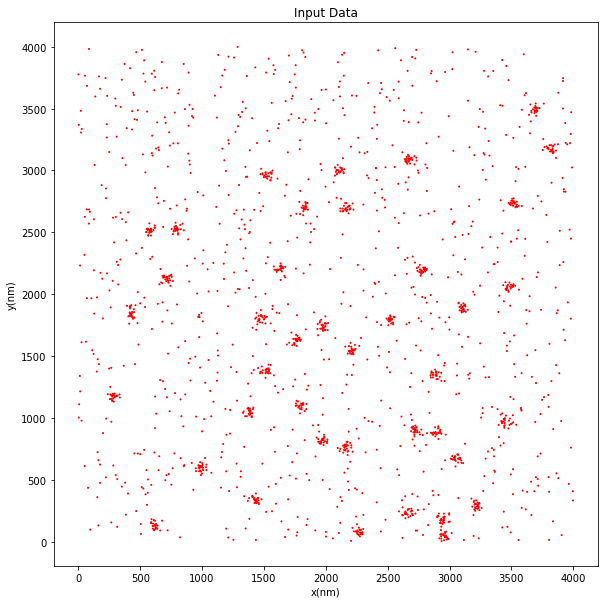

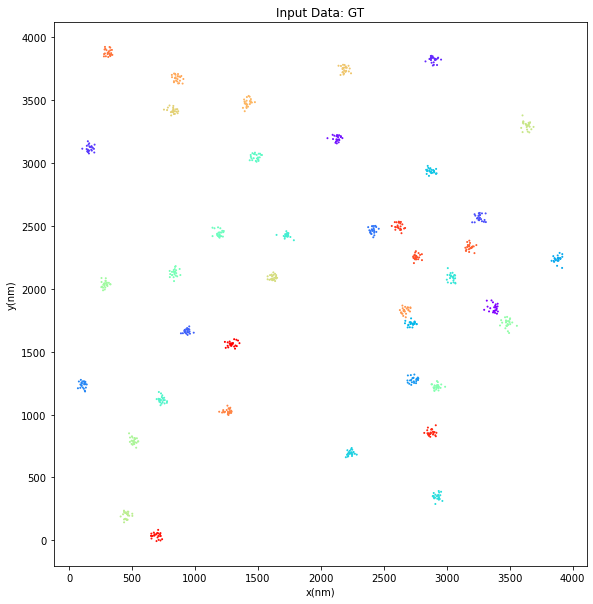

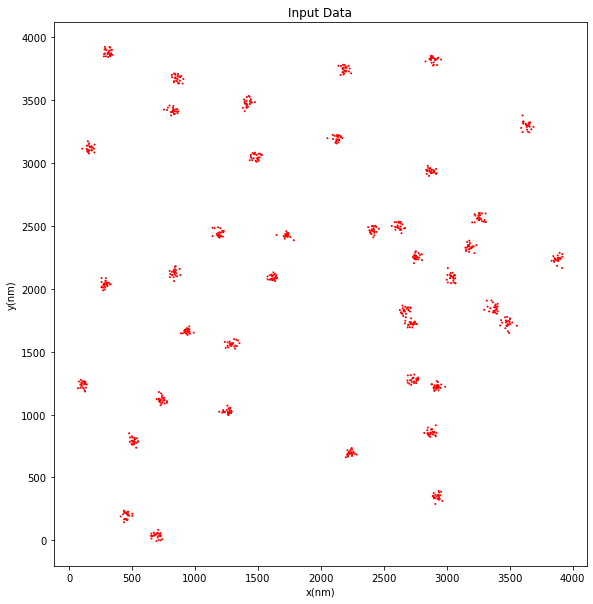

In [67]:
DataNoise = Call_DataGenerator(param)
DataNoise.plot_points()
DataNoNoise = Call_DataGenerator(param_NoNoise)
DataNoNoise.plot_points()

In [68]:
Noise_df = DataNoise.GetAllData()
N_Noise = len(DataNoise.GetPoints())
NoNoise_df = DataNoNoise.GetAllData()
N_NoNoise = len(DataNoNoise.GetPoints())
sigma_s = 35.0

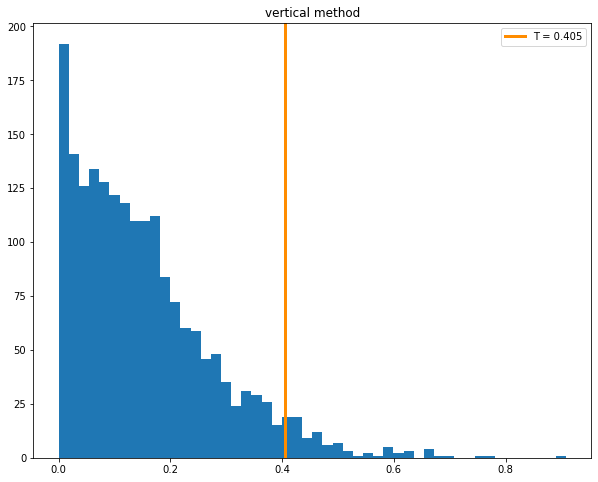

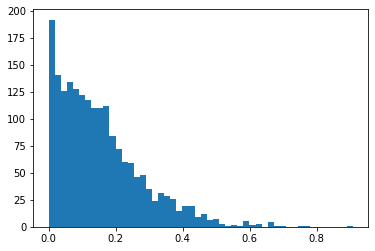

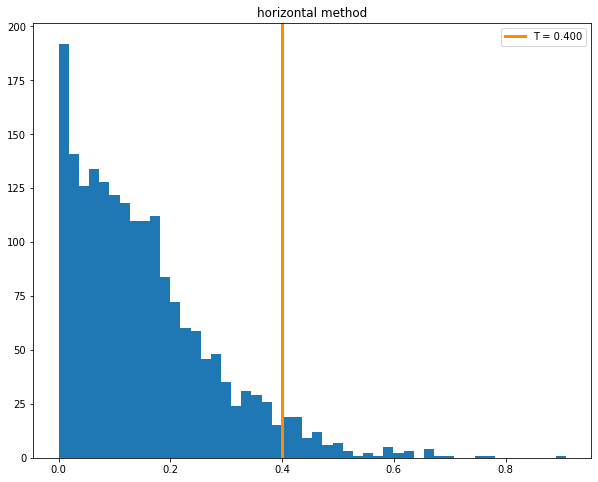

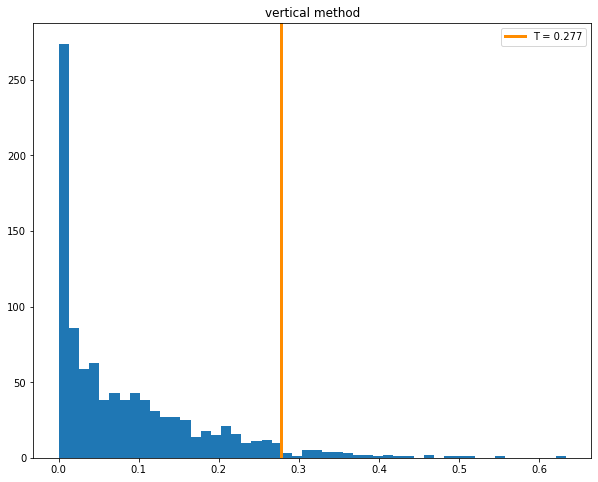

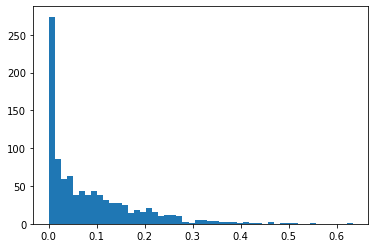

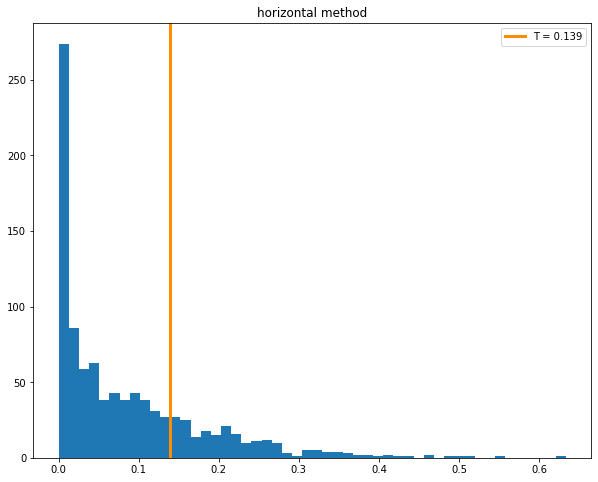

In [72]:
T_Noise, poubelle = compute_T(N_Noise, sigma_s)
T_NoNoise, poubelle = compute_T(N_NoNoise, sigma_s)

In [56]:
print('T_noise = ', T_Noise)
print('T_NoNoise = ', T_NoNoise)

T_noise =  0.40848280982367563
T_NoNoise =  0.2758114551728531


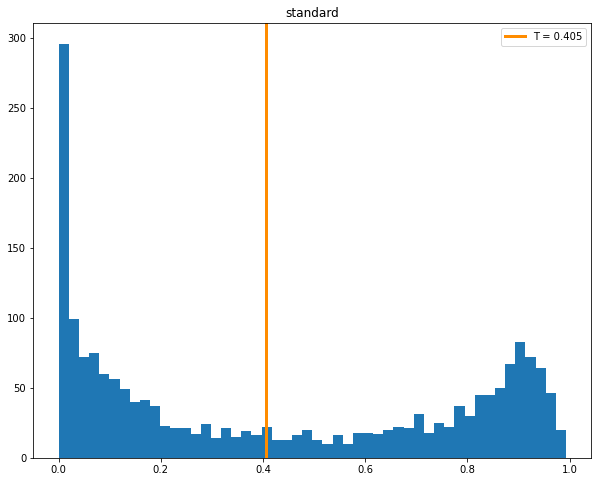

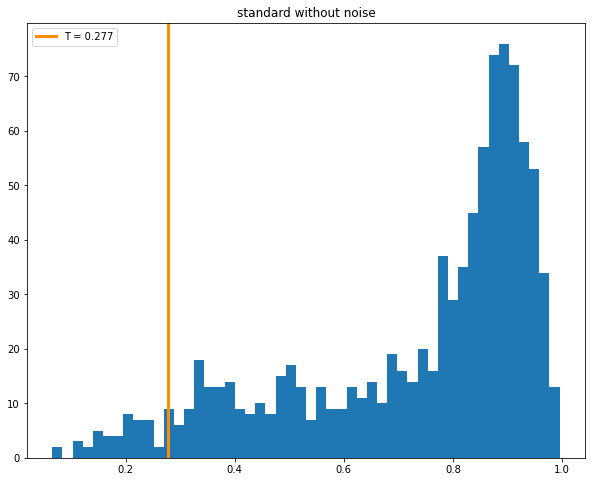

In [74]:
P_Noise = Noise_df[['x', 'y']].to_numpy()
P_NoNoise = NoNoise_df[['x', 'y']].to_numpy()

Sigma1          = np.ones((P_Noise.shape[0], 2, 2)) * 0
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P_Noise.shape[0], 1)).ravel()

density_Noise, G = compute_density(P_Noise, Sigma1, sigma_s)
see_histogram(density_Noise, T_Noise, 'standard')

Sigma1          = np.ones((P_NoNoise.shape[0], 2, 2)) * 0
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P_NoNoise.shape[0], 1)).ravel()

density_noNoise, G = compute_density(P_NoNoise, Sigma1, sigma_s)
see_histogram(density_noNoise, T_NoNoise, 'standard without noise')



T_Noise =  0.48199720541797286
T_NoNoise =  0.31839390778532173


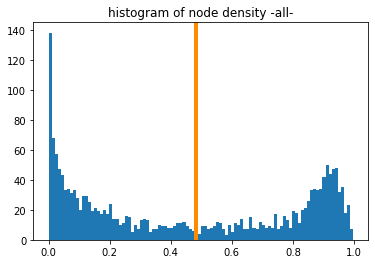

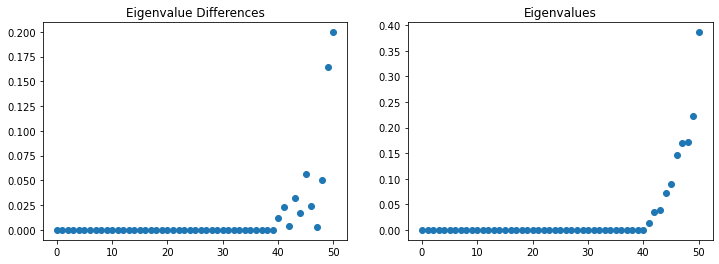

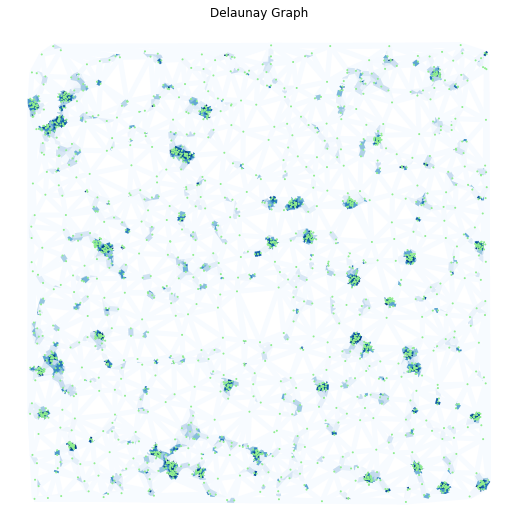

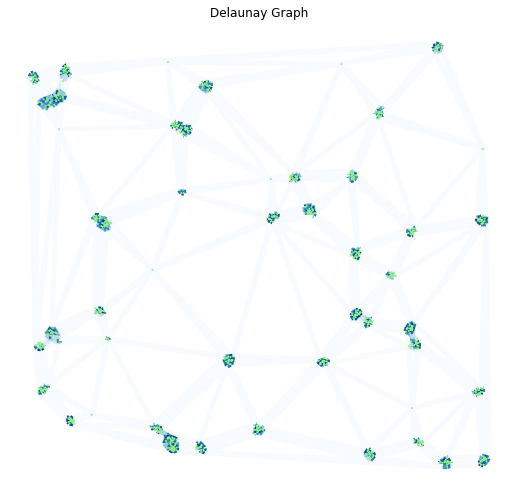

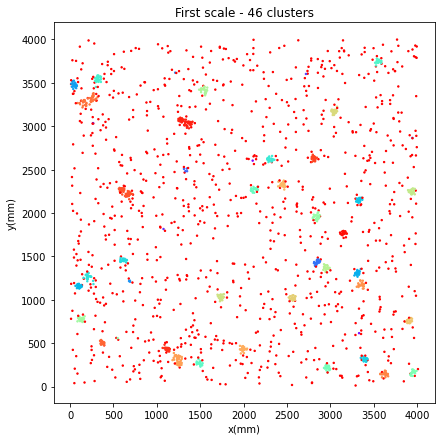

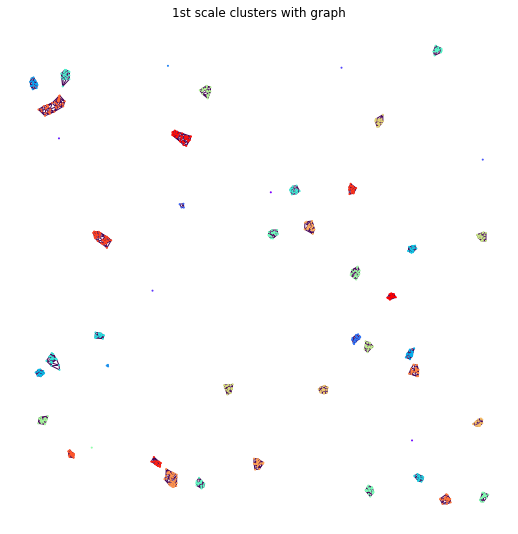

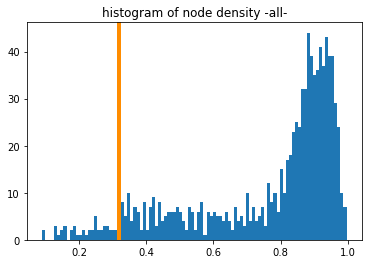

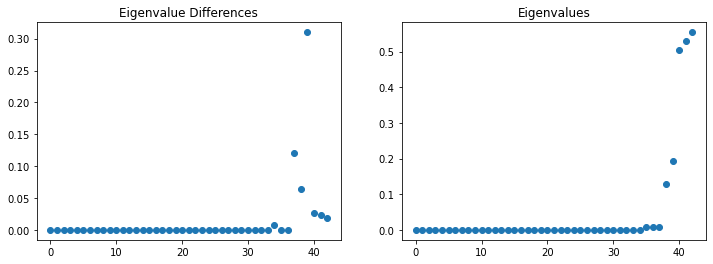

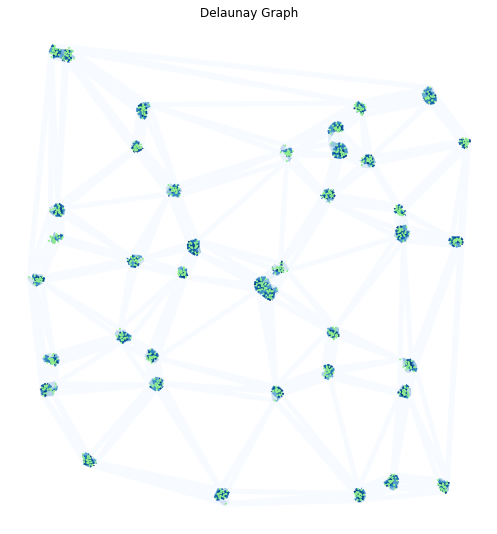

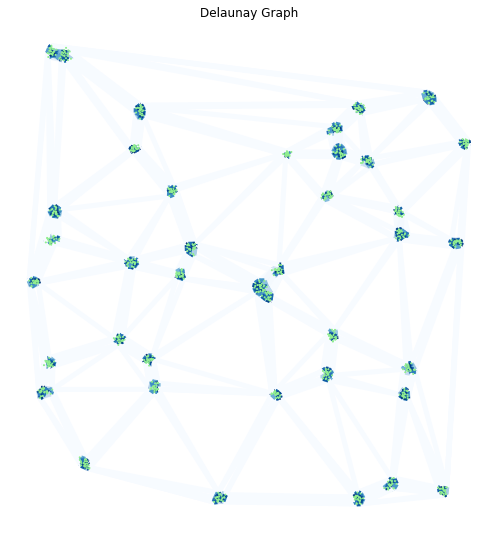

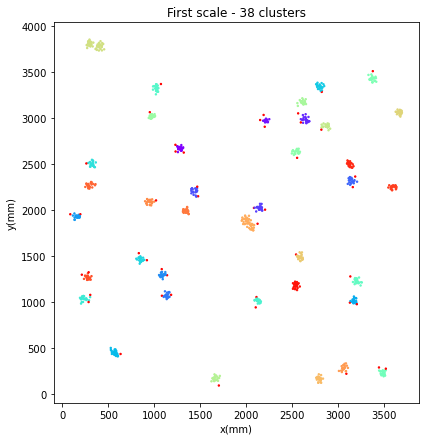

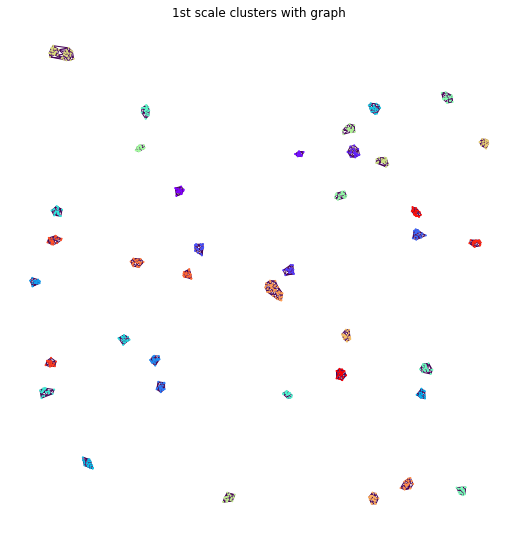

In [49]:
# CA CA A éTé OBTENU AVEC SIGMA_S = 40.0

# - T_noise =  0.48199720541797286
# - T_NoNoise =  0.31839390778532173

T_Noise =  0.4048880293696683
T_NoNoise =  0.2773844982933877


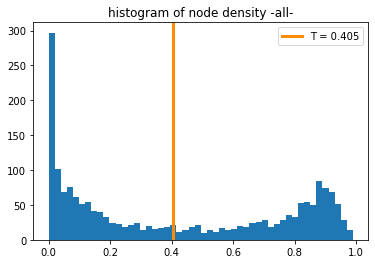

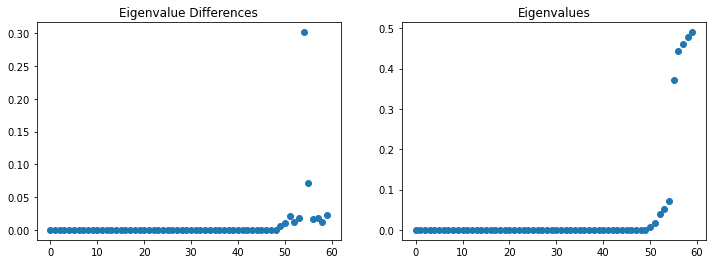

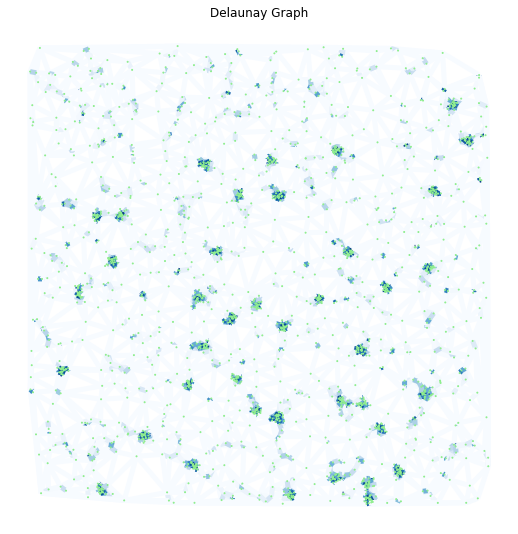

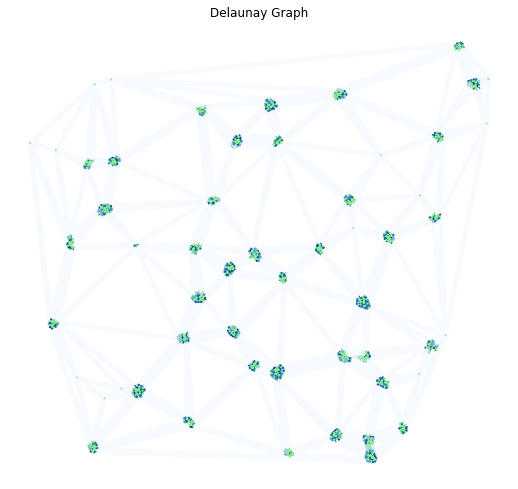

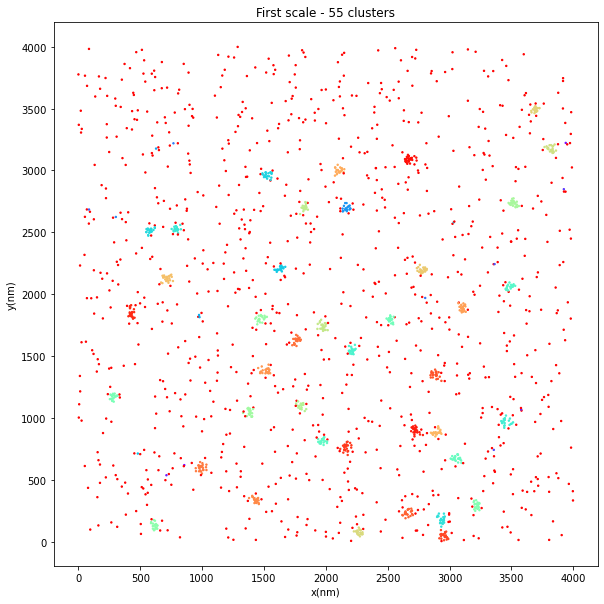

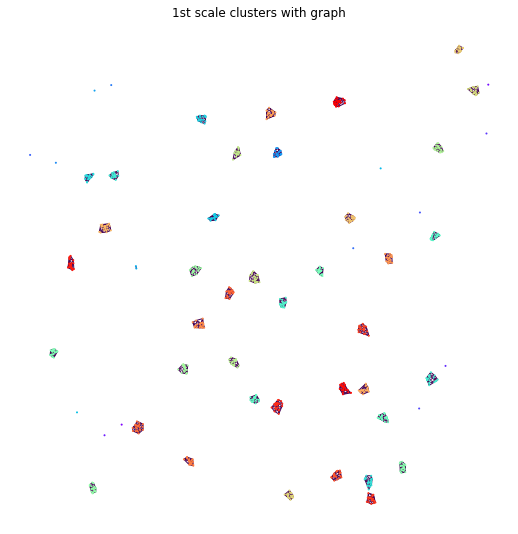

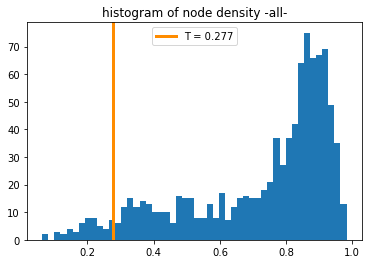

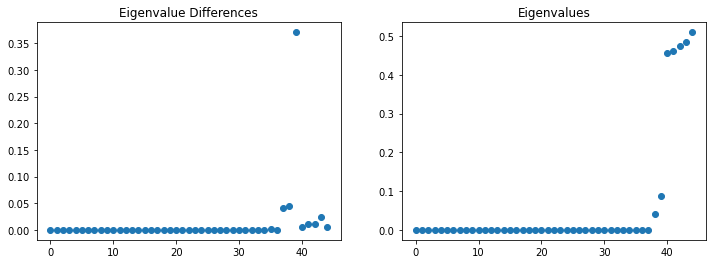

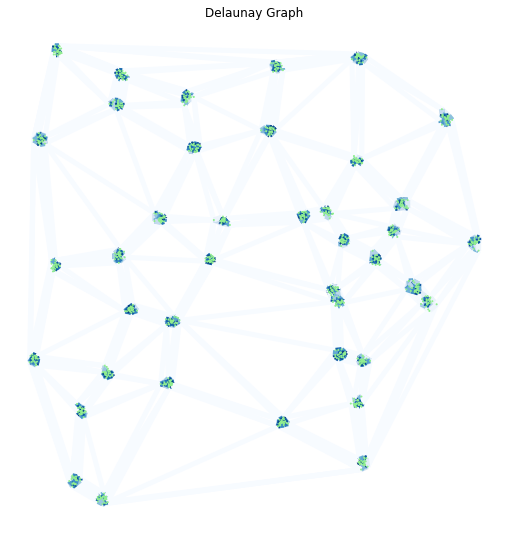

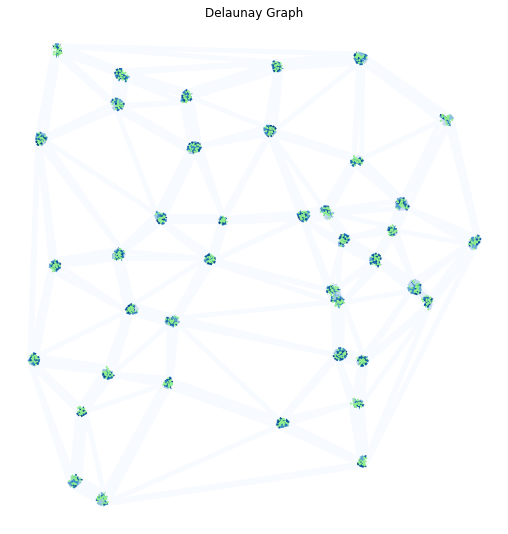

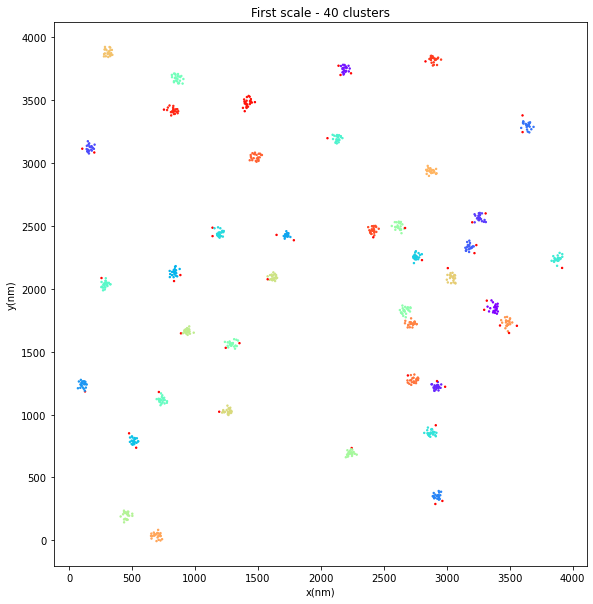

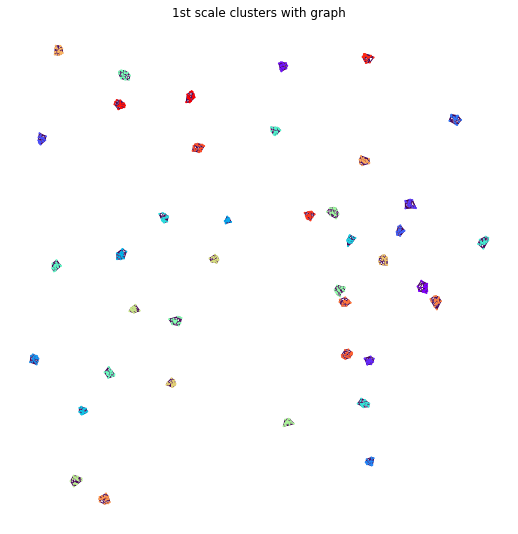

In [75]:
# Avec sigma = 35
print('T_Noise = ', T_Noise)
print('T_NoNoise = ', T_NoNoise)
labels_Noise = calling_graphic(Noise_df, sigma_s, T_Noise)
labels_Noise = calling_graphic(NoNoise_df, sigma_s, T_NoNoise)

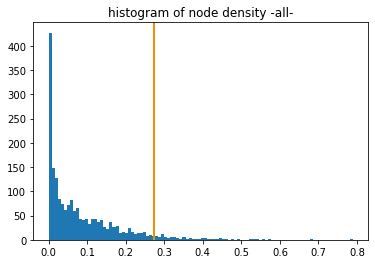

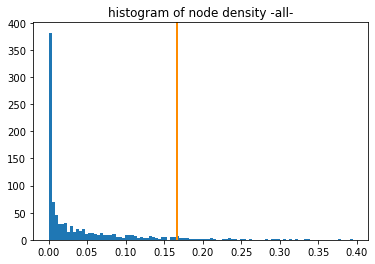

In [60]:
# EXACTEMENT LES MEMES DONNéES MAIS AVEC UN SIGMA PLUS PETIT. 
sigma_s = 25.0
T_Noise = compute_T(N_Noise, sigma_s)
T_NoNoise = compute_T(N_NoNoise, sigma_s)

T_Noise =  0.27420449667372176
T_NoNoise =  0.1666346050355632


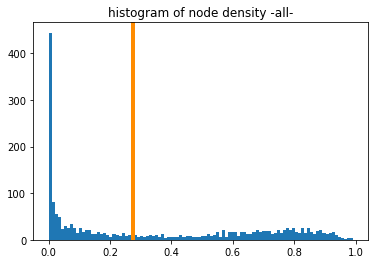

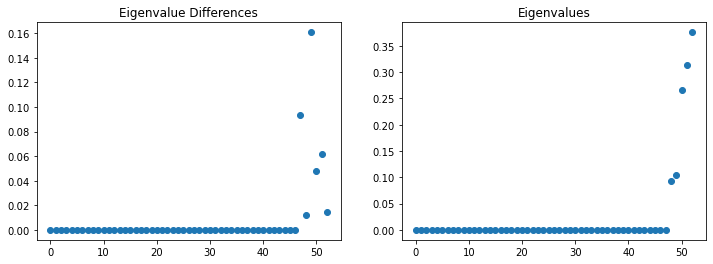

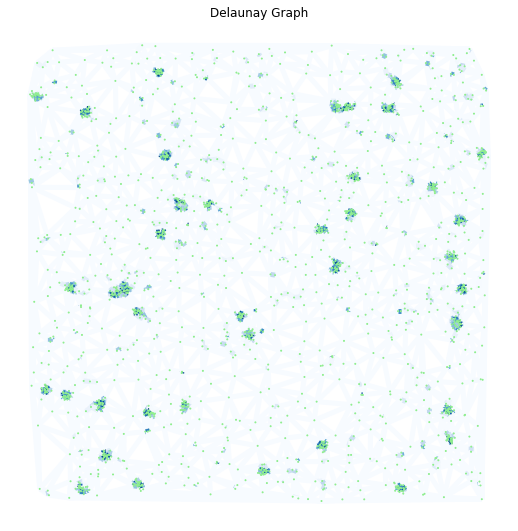

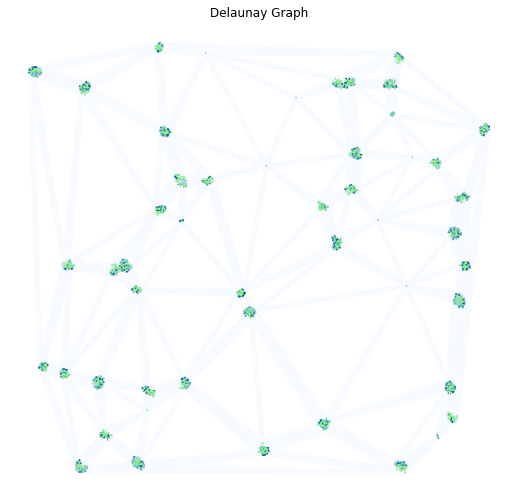

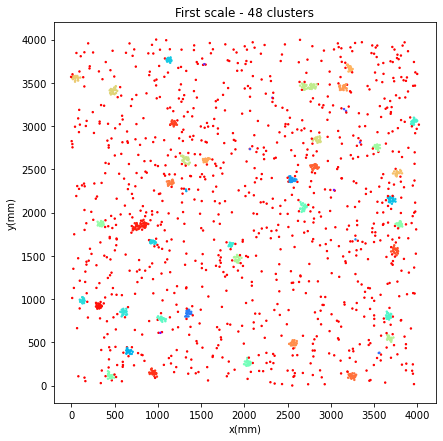

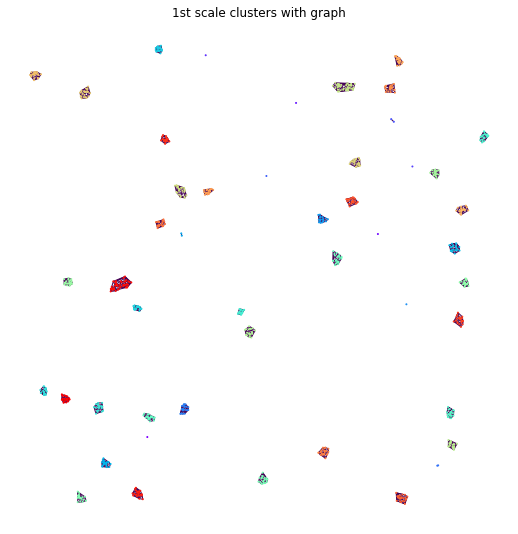

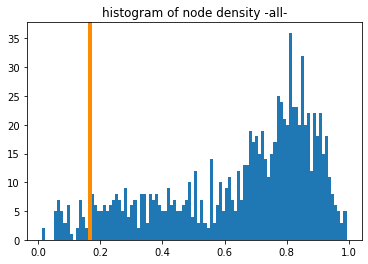

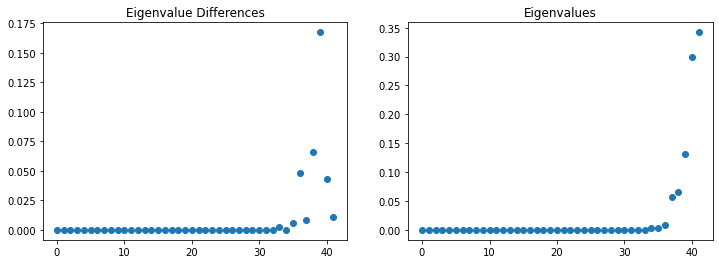

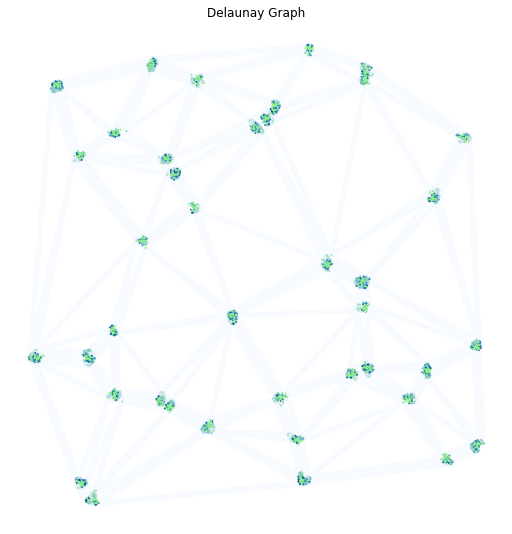

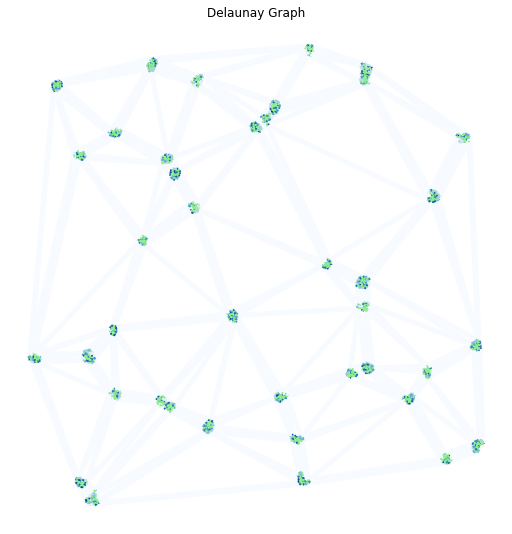

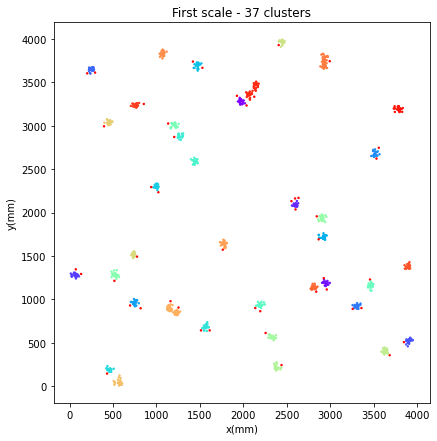

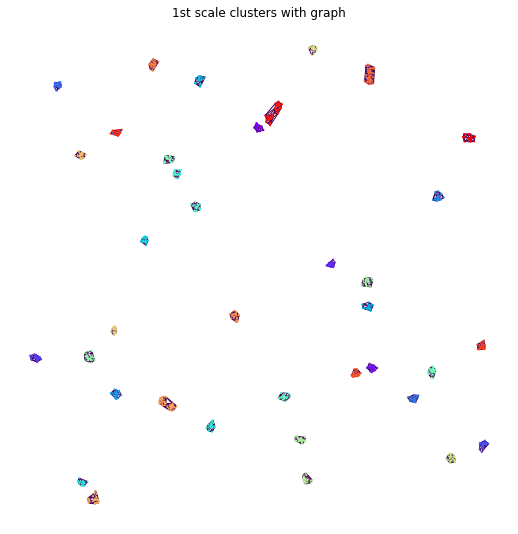

In [61]:
# Avec sigma = 25
print('T_Noise = ', T_Noise)
print('T_NoNoise = ', T_NoNoise)
labels_Noise = calling_graphic(Noise_df, sigma_s, T_Noise)
labels_Noise = calling_graphic(NoNoise_df, sigma_s, T_NoNoise)

In [76]:
# Another extreme situation that does not really make any sense

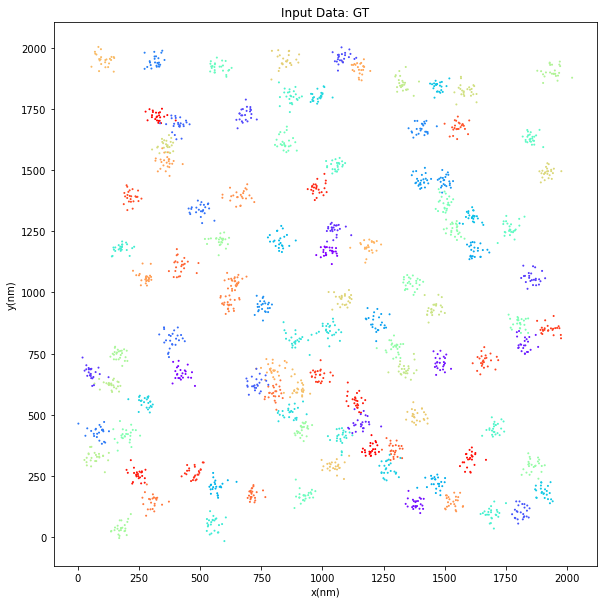

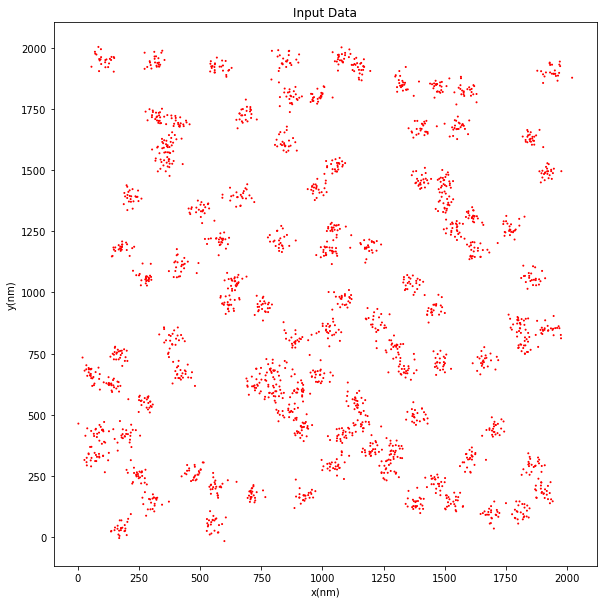

In [4]:
pcr = Standard_Param(NumberOfClusters = 100)
pcr.NoisePercentage = 0
pcr.x_lim = [0,2]
pcr.y_lim = [0,2]
DataCrowded = Call_DataGenerator(pcr)
DataCrowded.plot_points()

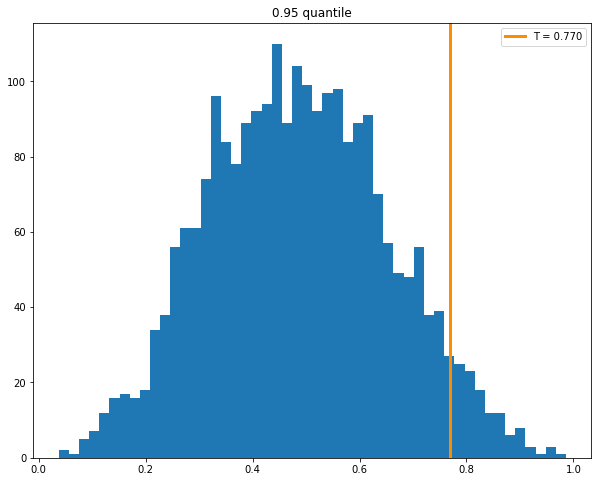

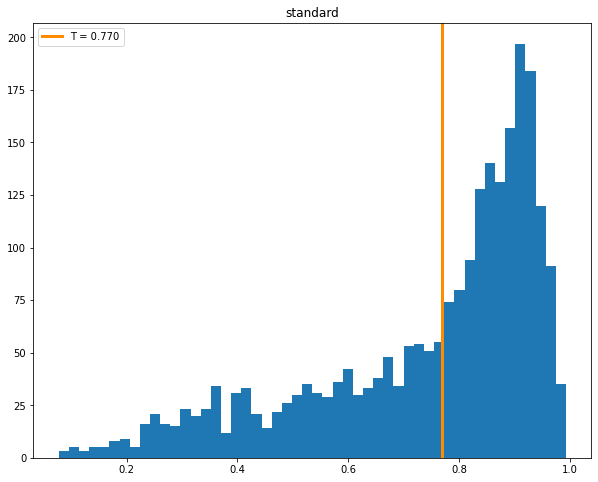

In [6]:
crowded_df = DataCrowded.GetAllData()
N_crowded = len(DataCrowded.GetPoints())

sigma_s = 35.0

T_crowded = compute_T_95(N_crowded, sigma_s = sigma_s, x_lim = [0,2], y_lim= [0,2])


P_crowded = crowded_df[['x', 'y']].to_numpy()

Sigma1          = np.ones((P_crowded.shape[0], 2, 2)) * 0
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P_crowded.shape[0], 1)).ravel()

density_crowded, G = compute_density(P_crowded, Sigma1, sigma_s)
see_histogram(density_crowded, T_crowded, 'standard')

In [7]:
T_crowded

0.7700123943656837

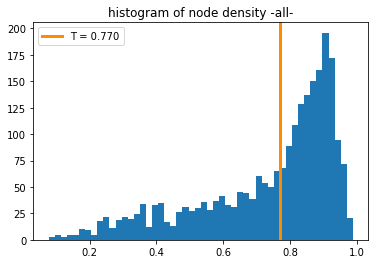

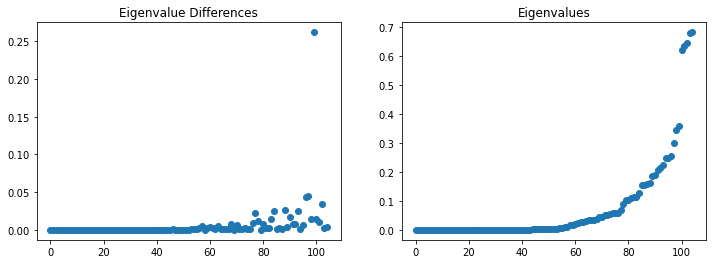

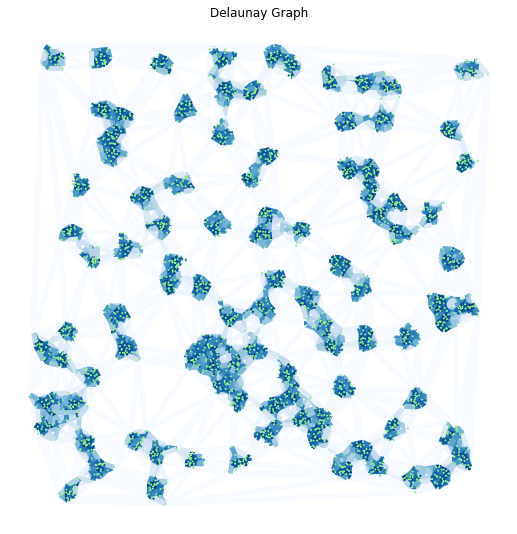

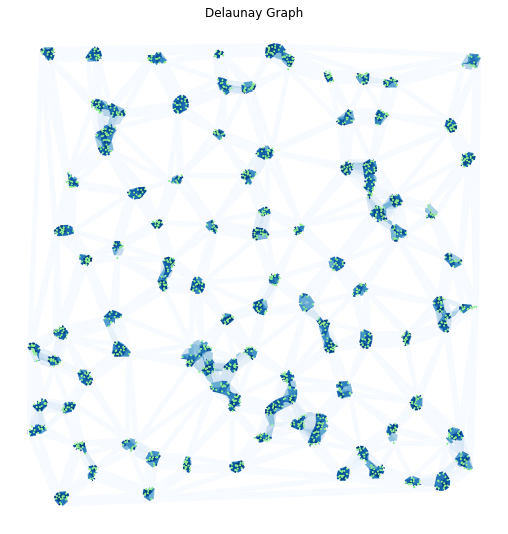

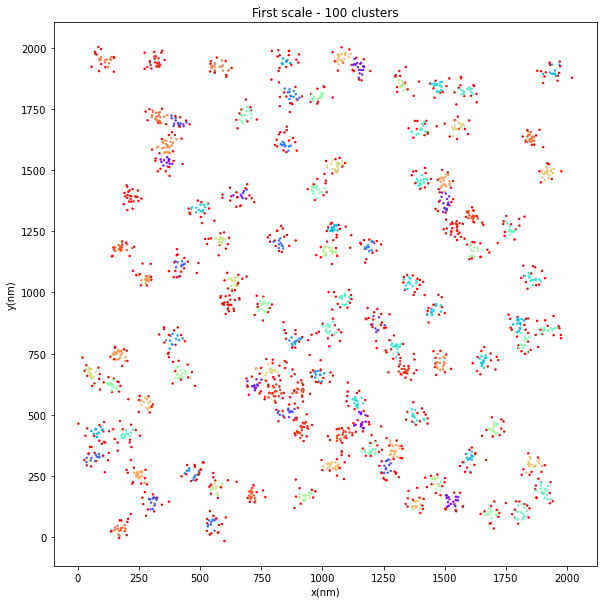

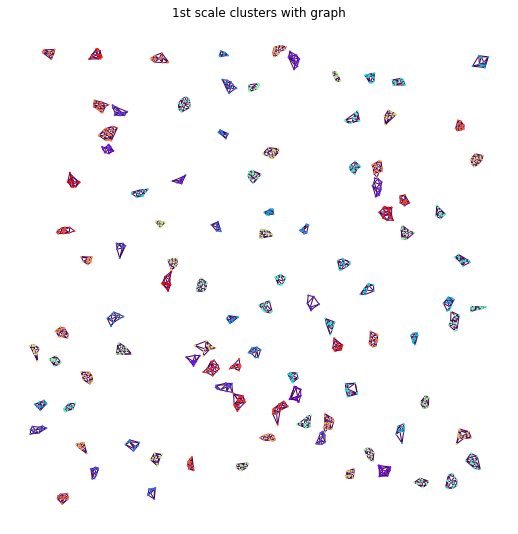

In [8]:
labels_crowded = calling_graphic(crowded_df, sigma_s, T_crowded)

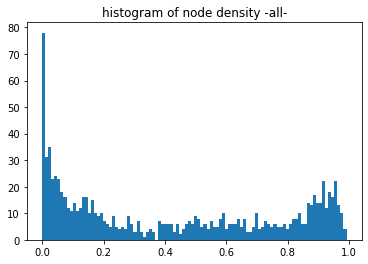

In [86]:
data_cluster = datagen.GetAllData()
P = data_cluster[['x', 'y']].to_numpy() # select the coordinates columns, and transform into a numpy object
truelabels = data_cluster['labels_1'].to_numpy()

Sigma1          = np.ones((P.shape[0], 2, 2)) * 0.5
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P.shape[0], 1)).ravel()

density1, G0 = see_histogram(P, Sigma1, sigma_s)

In [ ]:
def plot_with_error(distances, y_avg, y_std, NumberOfSim = 30,
                    title = 'Power Of Seperation',
                    xlabel = 'distance [nm]',
                    ylabel = 'FMI'):
    x = distances
    y_avg = np.asarray(y_avg)
    y_std = np.asarray(y_std) / np.sqrt(NumberOfSim) 
    plt.plot(x,y_avg, color ='b', label='GrapHiC')
    plt.fill_between(x, (y_avg - y_std), (y_avg + y_std), color='b', alpha=.1)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

New method: with quantile. THreshold at 90% or 95% of the points. 

In [99]:
csr = CsrGenerator(N=2000)
data = csr.GetAllData()
P = data[['x', 'y']].to_numpy() # select the coordinates columns, and transform into a numpy object
truelabels = data['labels_1'].to_numpy()

Sigma1          = np.ones((P.shape[0], 2, 2)) * 0
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P.shape[0], 1)).ravel()

density_csr, G0 = compute_density(P, Sigma1, sigma_s)

In [108]:
res = np.quantile(density_csr, 0.5)

In [109]:
res

0.13035068328045135

In [110]:
np.median(density_csr)

0.13035068328045135

(array([638., 543., 342., 229., 116.,  68.,  38.,  16.,   6.,   4.]),
 array([5.21026018e-06, 7.80780322e-02, 1.56150854e-01, 2.34223676e-01,
        3.12296498e-01, 3.90369320e-01, 4.68442142e-01, 5.46514964e-01,
        6.24587786e-01, 7.02660608e-01, 7.80733430e-01]),
 <BarContainer object of 10 artists>)

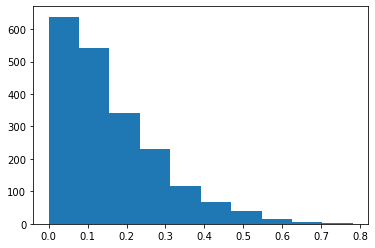

In [107]:
plt.hist(density_csr)

NameError: name 'title' is not defined

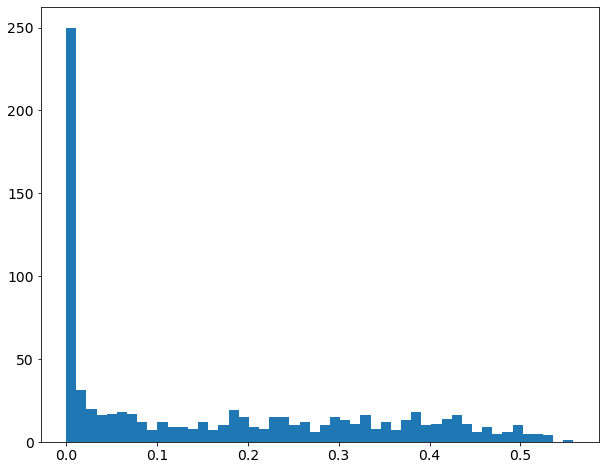

In [71]:
plt.figure(figsize = (10,8))
plt.hist(density, bins=50)
plt.title(title)
plt.axvline(x=noise_thrsh, label='T = ' + '%.3f'%(noise_thrsh), c='DarkOrange', linewidth=3)
plt.legend()
plt.show()